# Single-task finetuning

In [1]:
import os
import random
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import pandas as pd
import numpy as np
import warnings

import selfies as sf
from sklearn.metrics import average_precision_score, accuracy_score

/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
run_dir = "/rds/general/user/ssh22/home/FS-Tox/multirun/2023-08-16/15-09-01"
checkpoint = "ncfrey/ChemGPT-4.7M"
model_dir = "/rds/general/user/ssh22/home/FS-Tox/models"

In [3]:
warnings.filterwarnings('ignore', category=UserWarning, module='transformers')
from transformers import logging
logging.set_verbosity_error()

# Functions

In [27]:
def load_data(task_filepath):
    
    # Load a task
    task = pd.read_parquet(task_filepath)

    # Convert canonical SMILES to SELFIES
    selfies = task["canonical_smiles"].apply(convert_canonical_smiles_to_selfies)

    # Split task into support and query sets
    support_selfies = selfies[task["support_query"] == 0].tolist()
    query_selfies = selfies[task["support_query"] == 1].tolist()

    # Get support and query labels
    support_labels = torch.tensor(task["ground_truth"][task["support_query"] == 0].reset_index(drop=True))
    query_labels = torch.tensor(task["ground_truth"][task["support_query"] == 1].reset_index(drop=True))
    
    return support_selfies, support_labels, query_selfies, query_labels

In [28]:
def tokenize_data(data):

    # Tokenize the SELFIES
    return tokenizer(
        data, padding=True, truncation=True, return_tensors="pt", max_length=256
    )

In [29]:
# Create a PyTorch dataset for each task
class ChemDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [30]:
def finetune_model(support_dataset, query_dataset, model, model_path):
    
    # Define Trainer
    args = TrainingArguments(
        output_dir=model_path,
        evaluation_strategy="steps",
        eval_steps=500,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        seed=0,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=support_dataset,
        eval_dataset=query_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    
    trainer.save_model(model_path)

In [31]:
def generate_predictions(model, query_dataset):

    # Define test trainer
    trainer = Trainer(model)

    # Make prediction
    raw_pred, _, _ = trainer.predict(query_dataset)
    
    # Assuming true_labels is a numpy array containing the ground truth labels for query_dataset
    true_labels = np.array(query_dataset.labels)

    # Compute the probabilities for the positive class
    y_prob = raw_pred[:, 1]
    
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute AUC-PR
    return accuracy_score(true_labels, y_pred), average_precision_score(true_labels, y_prob)

In [32]:
def compute_metrics(p):
    pred, labels = p
    auc_pr = average_precision_score(y_true=labels, y_pred=pred)
    
    return {"auc_pr": auc_pr}

In [33]:
def convert_canonical_smiles_to_selfies(smiles_str):
    # Convert SMILES to SELFIES
    selfies_str = sf.encoder(smiles_str)
    return selfies_str

# Randomly select up to 400 tasks per dataset

In [13]:
dataset_dirs = [f"{run_dir}/{dataset_dir}" for dataset_dir in os.listdir(run_dir) if dataset_dir != ".ipynb_checkpoints"]

# Get list of datasets
datasets = [os.path.basename(dataset_dir).split("=")[1].split(',')[0] for dataset_dir in dataset_dirs]

# Add task paths to dataset_dirs
dataset_dirs = [f"{dataset_dir}/data/processed/task" for dataset_dir in dataset_dirs]

dataset_tasks = {}

for dataset, dataset_dir in zip(datasets, dataset_dirs):
    tasks = [f"{dataset_dir}/{task}" for task in os.listdir(dataset_dir)]
    
    if len(tasks) >= 200:
        tasks = random.sample(tasks, 200)
    
    dataset_tasks[dataset] = tasks

# Train and predict on each of the tasks and save the model

In [35]:
# Tokenize the SELFIES
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Adding a padding token
tokenizer.pad_token = "[PAD]"

In [36]:
finetuned_accuracy = []
finetuned_auc_pr = []
dataset_match = []
task_id_match = []

In [14]:
for dataset in datasets:
    tasks = dataset_tasks[dataset]
    print(dataset, ": beginning training")
    for task in tqdm(tasks):
        # Load data
        support_selfies, support_labels, query_selfies, query_labels = load_data(task)

        # Tokenize data
        support_encodings = tokenize_data(support_selfies)
        query_encodings = tokenize_data(query_selfies)

        # Create support and query data 
        support_dataset = ChemDataset(support_encodings, support_labels)
        query_dataset = ChemDataset(query_encodings, query_labels)

        # Get the finetuned model
        finetuned_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
        finetuned_model.config.pad_token_id = tokenizer.pad_token_id
        
        # Get task_id
        task_id = os.path.splitext(os.path.basename(task))[0]
        
        # Set finetuned model path
        model_path = os.path.join(model_dir, dataset, task_id)
        
        # Finetune model
        finetune_model(support_dataset, query_dataset, finetuned_model, model_path)

        # Load baseline and finetuned models 
        finetuned_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
        finetuned_model.config.pad_token_id = tokenizer.pad_token_id
        
        # Generate predictions
        finetune_acc, finetune_auc = generate_predictions(finetuned_model, query_dataset)
        finetuned_accuracy.append(finetune_acc)
        finetuned_auc_pr.append(finetune_auc)
        dataset_match.append(dataset)
        task_id_match.append(task_id)

acute_oral_toxicity : beginning training


  0%|          | 0/12 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8576, 'train_samples_per_second': 25.84, 'train_steps_per_second': 3.23, 'train_loss': 0.6808592478434244, 'epoch': 3.0}


  8%|▊         | 1/12 [00:32<05:56, 32.45s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.5694, 'train_samples_per_second': 122.343, 'train_steps_per_second': 15.293, 'train_loss': 0.7019791603088379, 'epoch': 3.0}


 17%|█▋        | 2/12 [00:56<04:37, 27.74s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2846, 'train_samples_per_second': 116.908, 'train_steps_per_second': 14.613, 'train_loss': 0.6726823647816976, 'epoch': 3.0}


 25%|██▌       | 3/12 [01:22<04:01, 26.82s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.5939, 'train_samples_per_second': 120.46, 'train_steps_per_second': 15.057, 'train_loss': 0.5960264603296915, 'epoch': 3.0}


 33%|███▎      | 4/12 [01:46<03:26, 25.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8359, 'train_samples_per_second': 114.845, 'train_steps_per_second': 14.356, 'train_loss': 0.7782847881317139, 'epoch': 3.0}


 42%|████▏     | 5/12 [02:10<02:54, 24.95s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6646, 'train_samples_per_second': 115.343, 'train_steps_per_second': 14.418, 'train_loss': 0.6529266834259033, 'epoch': 3.0}


 50%|█████     | 6/12 [02:34<02:28, 24.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8443, 'train_samples_per_second': 113.71, 'train_steps_per_second': 14.214, 'train_loss': 0.6165047486623129, 'epoch': 3.0}


 58%|█████▊    | 7/12 [02:58<02:01, 24.30s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8361, 'train_samples_per_second': 114.818, 'train_steps_per_second': 14.352, 'train_loss': 0.6951278845469157, 'epoch': 3.0}


 67%|██████▋   | 8/12 [03:21<01:36, 24.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4397, 'train_samples_per_second': 109.173, 'train_steps_per_second': 13.647, 'train_loss': 0.6346640586853027, 'epoch': 3.0}


 75%|███████▌  | 9/12 [03:44<01:11, 23.79s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4353, 'train_samples_per_second': 110.278, 'train_steps_per_second': 13.785, 'train_loss': 0.6161710818608602, 'epoch': 3.0}


 83%|████████▎ | 10/12 [04:07<00:47, 23.56s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2813, 'train_samples_per_second': 117.026, 'train_steps_per_second': 14.628, 'train_loss': 0.6325165828069051, 'epoch': 3.0}


 92%|█████████▏| 11/12 [04:33<00:24, 24.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2438, 'train_samples_per_second': 118.381, 'train_steps_per_second': 14.798, 'train_loss': 0.6782073179880778, 'epoch': 3.0}


100%|██████████| 12/12 [04:58<00:00, 24.91s/it]


cancerrx : beginning training


  0%|          | 0/200 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6774, 'train_samples_per_second': 114.461, 'train_steps_per_second': 14.308, 'train_loss': 0.6988959312438965, 'epoch': 3.0}


  0%|          | 1/200 [00:02<09:34,  2.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.439, 'train_samples_per_second': 109.334, 'train_steps_per_second': 13.667, 'train_loss': 0.6883614857991537, 'epoch': 3.0}


  1%|          | 2/200 [00:04<07:41,  2.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4651, 'train_samples_per_second': 103.193, 'train_steps_per_second': 12.899, 'train_loss': 0.668350617090861, 'epoch': 3.0}


  2%|▏         | 3/200 [00:06<07:03,  2.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8922, 'train_samples_per_second': 101.468, 'train_steps_per_second': 12.684, 'train_loss': 0.687270720799764, 'epoch': 3.0}


  2%|▏         | 4/200 [00:09<08:08,  2.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4459, 'train_samples_per_second': 107.656, 'train_steps_per_second': 13.457, 'train_loss': 0.6805313428243002, 'epoch': 3.0}


  2%|▎         | 5/200 [00:11<07:27,  2.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.715, 'train_samples_per_second': 103.364, 'train_steps_per_second': 12.92, 'train_loss': 0.6397326787312826, 'epoch': 3.0}


  3%|▎         | 6/200 [00:16<10:17,  3.18s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4508, 'train_samples_per_second': 106.475, 'train_steps_per_second': 13.309, 'train_loss': 0.7066575686136881, 'epoch': 3.0}


  4%|▎         | 7/200 [00:18<08:58,  2.79s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9766, 'train_samples_per_second': 98.299, 'train_steps_per_second': 12.287, 'train_loss': 0.7011120319366455, 'epoch': 3.0}


  4%|▍         | 8/200 [00:20<08:16,  2.59s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9161, 'train_samples_per_second': 100.201, 'train_steps_per_second': 12.525, 'train_loss': 0.6882103284200033, 'epoch': 3.0}


  4%|▍         | 9/200 [00:24<08:56,  2.81s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8502, 'train_samples_per_second': 99.735, 'train_steps_per_second': 12.467, 'train_loss': 0.6673029263814291, 'epoch': 3.0}


  5%|▌         | 10/200 [00:29<11:11,  3.53s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.898, 'train_samples_per_second': 101.158, 'train_steps_per_second': 12.645, 'train_loss': 0.6169615586598715, 'epoch': 3.0}


  6%|▌         | 11/200 [00:32<10:55,  3.47s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9007, 'train_samples_per_second': 101.013, 'train_steps_per_second': 12.627, 'train_loss': 0.5652680397033691, 'epoch': 3.0}


  6%|▌         | 12/200 [00:35<10:44,  3.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4709, 'train_samples_per_second': 101.94, 'train_steps_per_second': 12.742, 'train_loss': 0.6382124026616415, 'epoch': 3.0}


  6%|▋         | 13/200 [00:37<09:19,  2.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8739, 'train_samples_per_second': 109.848, 'train_steps_per_second': 13.731, 'train_loss': 0.7434863249460856, 'epoch': 3.0}


  7%|▋         | 14/200 [00:40<08:34,  2.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8738, 'train_samples_per_second': 109.869, 'train_steps_per_second': 13.734, 'train_loss': 0.7306352456410726, 'epoch': 3.0}


  8%|▊         | 15/200 [00:42<08:10,  2.65s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7359, 'train_samples_per_second': 102.788, 'train_steps_per_second': 12.848, 'train_loss': 0.6634531418482462, 'epoch': 3.0}


  8%|▊         | 16/200 [00:47<10:09,  3.31s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8768, 'train_samples_per_second': 109.483, 'train_steps_per_second': 13.685, 'train_loss': 0.6988143920898438, 'epoch': 3.0}


  8%|▊         | 17/200 [00:49<09:16,  3.04s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.988, 'train_samples_per_second': 97.164, 'train_steps_per_second': 12.145, 'train_loss': 0.7200659116109213, 'epoch': 3.0}


  9%|▉         | 18/200 [00:52<08:41,  2.87s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4724, 'train_samples_per_second': 101.619, 'train_steps_per_second': 12.702, 'train_loss': 0.5909073352813721, 'epoch': 3.0}


 10%|▉         | 19/200 [00:54<07:44,  2.57s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8589, 'train_samples_per_second': 111.777, 'train_steps_per_second': 13.972, 'train_loss': 0.6812402407328287, 'epoch': 3.0}


 10%|█         | 20/200 [00:56<07:28,  2.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8955, 'train_samples_per_second': 101.293, 'train_steps_per_second': 12.662, 'train_loss': 0.68216339747111, 'epoch': 3.0}


 10%|█         | 21/200 [00:59<08:10,  2.74s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7242, 'train_samples_per_second': 103.11, 'train_steps_per_second': 12.889, 'train_loss': 0.6984419822692871, 'epoch': 3.0}


 11%|█         | 22/200 [01:04<10:14,  3.45s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4363, 'train_samples_per_second': 110.015, 'train_steps_per_second': 13.752, 'train_loss': 0.6988679567972819, 'epoch': 3.0}


 12%|█▏        | 23/200 [01:06<08:51,  3.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8902, 'train_samples_per_second': 101.578, 'train_steps_per_second': 12.697, 'train_loss': 0.6422436237335205, 'epoch': 3.0}


 12%|█▏        | 24/200 [01:10<09:00,  3.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6693, 'train_samples_per_second': 115.015, 'train_steps_per_second': 14.377, 'train_loss': 0.6968787511189779, 'epoch': 3.0}


 12%|█▎        | 25/200 [01:12<08:52,  3.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7347, 'train_samples_per_second': 102.82, 'train_steps_per_second': 12.853, 'train_loss': 0.6112366914749146, 'epoch': 3.0}


 13%|█▎        | 26/200 [01:17<10:24,  3.59s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7264, 'train_samples_per_second': 103.05, 'train_steps_per_second': 12.881, 'train_loss': 0.6874981721242269, 'epoch': 3.0}


 14%|█▎        | 27/200 [01:22<11:29,  3.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8661, 'train_samples_per_second': 110.847, 'train_steps_per_second': 13.856, 'train_loss': 0.671361525853475, 'epoch': 3.0}


 14%|█▍        | 28/200 [01:24<09:41,  3.38s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8948, 'train_samples_per_second': 101.328, 'train_steps_per_second': 12.666, 'train_loss': 0.6533198753992716, 'epoch': 3.0}


 14%|█▍        | 29/200 [01:27<09:31,  3.34s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8592, 'train_samples_per_second': 111.736, 'train_steps_per_second': 13.967, 'train_loss': 0.6896440188090006, 'epoch': 3.0}


 15%|█▌        | 30/200 [01:30<08:36,  3.04s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4455, 'train_samples_per_second': 107.732, 'train_steps_per_second': 13.467, 'train_loss': 0.6944774786631266, 'epoch': 3.0}


 16%|█▌        | 31/200 [01:32<07:36,  2.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9743, 'train_samples_per_second': 98.536, 'train_steps_per_second': 12.317, 'train_loss': 0.7319697539011637, 'epoch': 3.0}


 16%|█▌        | 32/200 [01:34<07:08,  2.55s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9775, 'train_samples_per_second': 98.214, 'train_steps_per_second': 12.277, 'train_loss': 0.609316905339559, 'epoch': 3.0}


 16%|█▋        | 33/200 [01:36<06:59,  2.51s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8932, 'train_samples_per_second': 101.413, 'train_steps_per_second': 12.677, 'train_loss': 0.6250444253285726, 'epoch': 3.0}


 17%|█▋        | 34/200 [01:40<07:35,  2.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4487, 'train_samples_per_second': 106.969, 'train_steps_per_second': 13.371, 'train_loss': 0.6833397547403971, 'epoch': 3.0}


 18%|█▊        | 35/200 [01:42<06:55,  2.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8507, 'train_samples_per_second': 112.852, 'train_steps_per_second': 14.106, 'train_loss': 0.750536839167277, 'epoch': 3.0}


 18%|█▊        | 36/200 [01:44<06:41,  2.45s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8916, 'train_samples_per_second': 101.5, 'train_steps_per_second': 12.688, 'train_loss': 0.6426614125569662, 'epoch': 3.0}


 18%|█▊        | 37/200 [01:47<07:18,  2.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8603, 'train_samples_per_second': 111.595, 'train_steps_per_second': 13.949, 'train_loss': 0.7369752724965414, 'epoch': 3.0}


 19%|█▉        | 38/200 [01:49<06:57,  2.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6781, 'train_samples_per_second': 114.413, 'train_steps_per_second': 14.302, 'train_loss': 0.6718695958455404, 'epoch': 3.0}


 20%|█▉        | 39/200 [01:53<07:16,  2.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7206, 'train_samples_per_second': 103.208, 'train_steps_per_second': 12.901, 'train_loss': 0.6787053743998209, 'epoch': 3.0}


 20%|██        | 40/200 [01:57<08:55,  3.34s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8734, 'train_samples_per_second': 109.915, 'train_steps_per_second': 13.739, 'train_loss': 0.6986271540323893, 'epoch': 3.0}


 20%|██        | 41/200 [02:00<07:57,  3.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8986, 'train_samples_per_second': 101.129, 'train_steps_per_second': 12.641, 'train_loss': 0.675028403600057, 'epoch': 3.0}


 21%|██        | 42/200 [02:03<07:54,  3.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.465, 'train_samples_per_second': 103.225, 'train_steps_per_second': 12.903, 'train_loss': 0.7038005193074545, 'epoch': 3.0}


 22%|██▏       | 43/200 [02:05<07:02,  2.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.902, 'train_samples_per_second': 100.945, 'train_steps_per_second': 12.618, 'train_loss': 0.6805542310078939, 'epoch': 3.0}


 22%|██▏       | 44/200 [02:08<07:27,  2.87s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8691, 'train_samples_per_second': 110.457, 'train_steps_per_second': 13.807, 'train_loss': 0.714871327082316, 'epoch': 3.0}


 22%|██▎       | 45/200 [02:10<06:54,  2.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4309, 'train_samples_per_second': 111.391, 'train_steps_per_second': 13.924, 'train_loss': 0.6609253485997518, 'epoch': 3.0}


 23%|██▎       | 46/200 [02:12<06:16,  2.45s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2916, 'train_samples_per_second': 116.661, 'train_steps_per_second': 14.583, 'train_loss': 0.6347392797470093, 'epoch': 3.0}


 24%|██▎       | 47/200 [02:16<07:40,  3.01s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8949, 'train_samples_per_second': 101.323, 'train_steps_per_second': 12.665, 'train_loss': 0.6373302936553955, 'epoch': 3.0}


 24%|██▍       | 48/200 [02:20<07:50,  3.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8975, 'train_samples_per_second': 101.187, 'train_steps_per_second': 12.648, 'train_loss': 0.6465656757354736, 'epoch': 3.0}


 24%|██▍       | 49/200 [02:23<07:56,  3.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8714, 'train_samples_per_second': 110.169, 'train_steps_per_second': 13.771, 'train_loss': 0.6094348827997843, 'epoch': 3.0}


 25%|██▌       | 50/200 [02:25<07:14,  2.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4385, 'train_samples_per_second': 109.464, 'train_steps_per_second': 13.683, 'train_loss': 0.7043244043986002, 'epoch': 3.0}


 26%|██▌       | 51/200 [02:27<06:30,  2.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8763, 'train_samples_per_second': 109.545, 'train_steps_per_second': 13.693, 'train_loss': 0.6723024845123291, 'epoch': 3.0}


 26%|██▌       | 52/200 [02:29<06:13,  2.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7231, 'train_samples_per_second': 103.14, 'train_steps_per_second': 12.893, 'train_loss': 0.6272304455439249, 'epoch': 3.0}


 26%|██▋       | 53/200 [02:34<07:57,  3.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8478, 'train_samples_per_second': 113.231, 'train_steps_per_second': 14.154, 'train_loss': 0.6851890087127686, 'epoch': 3.0}


 27%|██▋       | 54/200 [02:37<07:14,  2.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4492, 'train_samples_per_second': 106.863, 'train_steps_per_second': 13.358, 'train_loss': 0.6027057965596517, 'epoch': 3.0}


 28%|██▊       | 55/200 [02:39<06:25,  2.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4295, 'train_samples_per_second': 111.763, 'train_steps_per_second': 13.97, 'train_loss': 0.718099037806193, 'epoch': 3.0}


 28%|██▊       | 56/200 [02:41<05:51,  2.44s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9055, 'train_samples_per_second': 100.759, 'train_steps_per_second': 12.595, 'train_loss': 0.7359972794850668, 'epoch': 3.0}


 28%|██▊       | 57/200 [02:44<06:23,  2.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8687, 'train_samples_per_second': 110.505, 'train_steps_per_second': 13.813, 'train_loss': 0.6538910865783691, 'epoch': 3.0}


 29%|██▉       | 58/200 [02:46<06:05,  2.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7208, 'train_samples_per_second': 103.202, 'train_steps_per_second': 12.9, 'train_loss': 0.6521206299463908, 'epoch': 3.0}


 30%|██▉       | 59/200 [02:51<07:42,  3.28s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.45, 'train_samples_per_second': 106.674, 'train_steps_per_second': 13.334, 'train_loss': 0.6771901448567709, 'epoch': 3.0}


 30%|███       | 60/200 [02:53<06:42,  2.88s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4315, 'train_samples_per_second': 111.237, 'train_steps_per_second': 13.905, 'train_loss': 0.7179883321126302, 'epoch': 3.0}


 30%|███       | 61/200 [02:55<05:59,  2.59s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6667, 'train_samples_per_second': 115.198, 'train_steps_per_second': 14.4, 'train_loss': 0.6383815209070841, 'epoch': 3.0}


 31%|███       | 62/200 [02:58<06:05,  2.65s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4669, 'train_samples_per_second': 102.815, 'train_steps_per_second': 12.852, 'train_loss': 0.6391634146372477, 'epoch': 3.0}


 32%|███▏      | 63/200 [03:00<05:34,  2.44s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9772, 'train_samples_per_second': 98.236, 'train_steps_per_second': 12.28, 'train_loss': 0.6423349777857462, 'epoch': 3.0}


 32%|███▏      | 64/200 [03:02<05:19,  2.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4545, 'train_samples_per_second': 105.619, 'train_steps_per_second': 13.202, 'train_loss': 0.5634146531422933, 'epoch': 3.0}


 32%|███▎      | 65/200 [03:04<04:57,  2.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.443, 'train_samples_per_second': 108.342, 'train_steps_per_second': 13.543, 'train_loss': 0.596580425898234, 'epoch': 3.0}


 33%|███▎      | 66/200 [03:06<04:44,  2.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4385, 'train_samples_per_second': 109.469, 'train_steps_per_second': 13.684, 'train_loss': 0.6631577809651693, 'epoch': 3.0}


 34%|███▎      | 67/200 [03:07<04:34,  2.06s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4682, 'train_samples_per_second': 102.53, 'train_steps_per_second': 12.816, 'train_loss': 0.692596435546875, 'epoch': 3.0}


 34%|███▍      | 68/200 [03:09<04:19,  1.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9823, 'train_samples_per_second': 97.729, 'train_steps_per_second': 12.216, 'train_loss': 0.7026322682698568, 'epoch': 3.0}


 34%|███▍      | 69/200 [03:12<04:37,  2.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8512, 'train_samples_per_second': 112.782, 'train_steps_per_second': 14.098, 'train_loss': 0.7388833363850912, 'epoch': 3.0}


 35%|███▌      | 70/200 [03:14<04:43,  2.18s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8659, 'train_samples_per_second': 110.866, 'train_steps_per_second': 13.858, 'train_loss': 0.656085729598999, 'epoch': 3.0}


 36%|███▌      | 71/200 [03:16<04:47,  2.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4663, 'train_samples_per_second': 102.944, 'train_steps_per_second': 12.868, 'train_loss': 0.7007548014322916, 'epoch': 3.0}


 36%|███▌      | 72/200 [03:18<04:34,  2.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9252, 'train_samples_per_second': 99.731, 'train_steps_per_second': 12.466, 'train_loss': 0.7064739863077799, 'epoch': 3.0}


 36%|███▋      | 73/200 [03:21<05:09,  2.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7303, 'train_samples_per_second': 102.94, 'train_steps_per_second': 12.868, 'train_loss': 0.6553963422775269, 'epoch': 3.0}


 37%|███▋      | 74/200 [03:26<06:40,  3.18s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9788, 'train_samples_per_second': 98.078, 'train_steps_per_second': 12.26, 'train_loss': 0.6639986435572306, 'epoch': 3.0}


 38%|███▊      | 75/200 [03:29<06:12,  2.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8778, 'train_samples_per_second': 109.361, 'train_steps_per_second': 13.67, 'train_loss': 0.6515615781148275, 'epoch': 3.0}


 38%|███▊      | 76/200 [03:31<05:42,  2.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9172, 'train_samples_per_second': 100.144, 'train_steps_per_second': 12.518, 'train_loss': 0.7340325514475504, 'epoch': 3.0}


 38%|███▊      | 77/200 [03:34<05:59,  2.92s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8986, 'train_samples_per_second': 101.129, 'train_steps_per_second': 12.641, 'train_loss': 0.6708191235860189, 'epoch': 3.0}


 39%|███▉      | 78/200 [03:37<06:00,  2.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8638, 'train_samples_per_second': 111.143, 'train_steps_per_second': 13.893, 'train_loss': 0.6585680246353149, 'epoch': 3.0}


 40%|███▉      | 79/200 [03:40<05:34,  2.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4375, 'train_samples_per_second': 109.708, 'train_steps_per_second': 13.714, 'train_loss': 0.7459294001261393, 'epoch': 3.0}


 40%|████      | 80/200 [03:42<04:57,  2.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7282, 'train_samples_per_second': 102.999, 'train_steps_per_second': 12.875, 'train_loss': 0.5922867854436239, 'epoch': 3.0}


 40%|████      | 81/200 [03:46<06:21,  3.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6591, 'train_samples_per_second': 115.727, 'train_steps_per_second': 14.466, 'train_loss': 0.6671020189921061, 'epoch': 3.0}


 41%|████      | 82/200 [03:50<06:12,  3.16s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4565, 'train_samples_per_second': 105.149, 'train_steps_per_second': 13.144, 'train_loss': 0.6589898268381754, 'epoch': 3.0}


 42%|████▏     | 83/200 [03:51<05:27,  2.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4394, 'train_samples_per_second': 109.238, 'train_steps_per_second': 13.655, 'train_loss': 0.6988679567972819, 'epoch': 3.0}


 42%|████▏     | 84/200 [03:53<04:53,  2.53s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.471, 'train_samples_per_second': 101.906, 'train_steps_per_second': 12.738, 'train_loss': 0.7265273729960123, 'epoch': 3.0}


 42%|████▎     | 85/200 [03:55<04:27,  2.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8969, 'train_samples_per_second': 101.219, 'train_steps_per_second': 12.652, 'train_loss': 0.6240196228027344, 'epoch': 3.0}


 43%|████▎     | 86/200 [03:58<04:57,  2.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4587, 'train_samples_per_second': 104.65, 'train_steps_per_second': 13.081, 'train_loss': 0.641104499499003, 'epoch': 3.0}


 44%|████▎     | 87/200 [04:00<04:31,  2.40s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7323, 'train_samples_per_second': 102.885, 'train_steps_per_second': 12.861, 'train_loss': 0.6851572195688883, 'epoch': 3.0}


 44%|████▍     | 88/200 [04:05<05:52,  3.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9071, 'train_samples_per_second': 100.678, 'train_steps_per_second': 12.585, 'train_loss': 0.6895308494567871, 'epoch': 3.0}


 44%|████▍     | 89/200 [04:09<05:54,  3.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9178, 'train_samples_per_second': 100.112, 'train_steps_per_second': 12.514, 'train_loss': 0.729961077372233, 'epoch': 3.0}


 45%|████▌     | 90/200 [04:12<05:56,  3.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8318, 'train_samples_per_second': 115.409, 'train_steps_per_second': 14.426, 'train_loss': 0.646033763885498, 'epoch': 3.0}


 46%|████▌     | 91/200 [04:14<05:22,  2.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9182, 'train_samples_per_second': 100.096, 'train_steps_per_second': 12.512, 'train_loss': 0.6802963415781657, 'epoch': 3.0}


 46%|████▌     | 92/200 [04:18<05:32,  3.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7312, 'train_samples_per_second': 102.917, 'train_steps_per_second': 12.865, 'train_loss': 0.6686362425486246, 'epoch': 3.0}


 46%|████▋     | 93/200 [04:23<06:28,  3.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9796, 'train_samples_per_second': 97.996, 'train_steps_per_second': 12.25, 'train_loss': 0.6723973751068115, 'epoch': 3.0}


 47%|████▋     | 94/200 [04:25<05:48,  3.28s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6754, 'train_samples_per_second': 114.597, 'train_steps_per_second': 14.325, 'train_loss': 0.696572462717692, 'epoch': 3.0}


 48%|████▊     | 95/200 [04:28<05:30,  3.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8995, 'train_samples_per_second': 101.08, 'train_steps_per_second': 12.635, 'train_loss': 0.7495598793029785, 'epoch': 3.0}


 48%|████▊     | 96/200 [04:31<05:25,  3.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8773, 'train_samples_per_second': 109.429, 'train_steps_per_second': 13.679, 'train_loss': 0.6791885693868002, 'epoch': 3.0}


 48%|████▊     | 97/200 [04:33<04:58,  2.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7417, 'train_samples_per_second': 102.628, 'train_steps_per_second': 12.829, 'train_loss': 0.6826707522074381, 'epoch': 3.0}


 49%|████▉     | 98/200 [04:38<05:54,  3.47s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6894, 'train_samples_per_second': 113.649, 'train_steps_per_second': 14.206, 'train_loss': 0.7222627003987631, 'epoch': 3.0}


 50%|████▉     | 99/200 [04:41<05:39,  3.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8786, 'train_samples_per_second': 109.267, 'train_steps_per_second': 13.658, 'train_loss': 0.6866039435068766, 'epoch': 3.0}


 50%|█████     | 100/200 [04:43<04:58,  2.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8998, 'train_samples_per_second': 101.064, 'train_steps_per_second': 12.633, 'train_loss': 0.6830908457438151, 'epoch': 3.0}


 50%|█████     | 101/200 [04:47<05:04,  3.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8924, 'train_samples_per_second': 101.46, 'train_steps_per_second': 12.683, 'train_loss': 0.5881708065668741, 'epoch': 3.0}


 51%|█████     | 102/200 [04:50<05:07,  3.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.45, 'train_samples_per_second': 106.662, 'train_steps_per_second': 13.333, 'train_loss': 0.6106460491816202, 'epoch': 3.0}


 52%|█████▏    | 103/200 [04:52<04:29,  2.78s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9772, 'train_samples_per_second': 98.237, 'train_steps_per_second': 12.28, 'train_loss': 0.7069225311279297, 'epoch': 3.0}


 52%|█████▏    | 104/200 [04:54<04:10,  2.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7178, 'train_samples_per_second': 103.287, 'train_steps_per_second': 12.911, 'train_loss': 0.665451447168986, 'epoch': 3.0}


 52%|█████▎    | 105/200 [04:59<05:14,  3.31s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7234, 'train_samples_per_second': 103.132, 'train_steps_per_second': 12.892, 'train_loss': 0.6520717144012451, 'epoch': 3.0}


 53%|█████▎    | 106/200 [05:04<05:54,  3.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7011, 'train_samples_per_second': 112.868, 'train_steps_per_second': 14.108, 'train_loss': 0.5994522174199423, 'epoch': 3.0}


 54%|█████▎    | 107/200 [05:07<05:36,  3.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7425, 'train_samples_per_second': 102.606, 'train_steps_per_second': 12.826, 'train_loss': 0.695207436879476, 'epoch': 3.0}


 54%|█████▍    | 108/200 [05:12<06:06,  3.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9004, 'train_samples_per_second': 101.031, 'train_steps_per_second': 12.629, 'train_loss': 0.7288331190745035, 'epoch': 3.0}


 55%|█████▍    | 109/200 [05:15<05:38,  3.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4431, 'train_samples_per_second': 108.322, 'train_steps_per_second': 13.54, 'train_loss': 0.6545936266581217, 'epoch': 3.0}


 55%|█████▌    | 110/200 [05:17<04:47,  3.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8995, 'train_samples_per_second': 101.079, 'train_steps_per_second': 12.635, 'train_loss': 0.6343053976694742, 'epoch': 3.0}


 56%|█████▌    | 111/200 [05:20<04:46,  3.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.736, 'train_samples_per_second': 102.785, 'train_steps_per_second': 12.848, 'train_loss': 0.656352162361145, 'epoch': 3.0}


 56%|█████▌    | 112/200 [05:25<05:25,  3.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7298, 'train_samples_per_second': 102.954, 'train_steps_per_second': 12.869, 'train_loss': 0.6665486892064413, 'epoch': 3.0}


 56%|█████▋    | 113/200 [05:30<05:53,  4.06s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9171, 'train_samples_per_second': 100.151, 'train_steps_per_second': 12.519, 'train_loss': 0.6854220231374105, 'epoch': 3.0}


 57%|█████▋    | 114/200 [05:33<05:29,  3.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8899, 'train_samples_per_second': 101.592, 'train_steps_per_second': 12.699, 'train_loss': 0.6508086125055949, 'epoch': 3.0}


 57%|█████▊    | 115/200 [05:37<05:12,  3.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4463, 'train_samples_per_second': 107.544, 'train_steps_per_second': 13.443, 'train_loss': 0.6711105505625407, 'epoch': 3.0}


 58%|█████▊    | 116/200 [05:39<04:24,  3.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7453, 'train_samples_per_second': 102.529, 'train_steps_per_second': 12.816, 'train_loss': 0.623210628827413, 'epoch': 3.0}


 58%|█████▊    | 117/200 [05:43<05:05,  3.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8923, 'train_samples_per_second': 101.464, 'train_steps_per_second': 12.683, 'train_loss': 0.7036329110463461, 'epoch': 3.0}


 59%|█████▉    | 118/200 [05:47<04:53,  3.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8554, 'train_samples_per_second': 112.224, 'train_steps_per_second': 14.028, 'train_loss': 0.7861011823018392, 'epoch': 3.0}


 60%|█████▉    | 119/200 [05:49<04:19,  3.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.718, 'train_samples_per_second': 103.282, 'train_steps_per_second': 12.91, 'train_loss': 0.6938819090525309, 'epoch': 3.0}


 60%|██████    | 120/200 [05:54<04:55,  3.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7211, 'train_samples_per_second': 103.195, 'train_steps_per_second': 12.899, 'train_loss': 0.6836138566335043, 'epoch': 3.0}


 60%|██████    | 121/200 [05:59<05:20,  4.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7187, 'train_samples_per_second': 103.263, 'train_steps_per_second': 12.908, 'train_loss': 0.6360763708750407, 'epoch': 3.0}


 61%|██████    | 122/200 [06:04<05:35,  4.31s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8859, 'train_samples_per_second': 108.364, 'train_steps_per_second': 13.545, 'train_loss': 0.6238808234532675, 'epoch': 3.0}


 62%|██████▏   | 123/200 [06:06<04:42,  3.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7574, 'train_samples_per_second': 102.199, 'train_steps_per_second': 12.775, 'train_loss': 0.649437427520752, 'epoch': 3.0}


 62%|██████▏   | 124/200 [06:11<05:08,  4.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4698, 'train_samples_per_second': 102.176, 'train_steps_per_second': 12.772, 'train_loss': 0.6904025077819824, 'epoch': 3.0}


 62%|██████▎   | 125/200 [06:13<04:17,  3.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6786, 'train_samples_per_second': 114.378, 'train_steps_per_second': 14.297, 'train_loss': 0.6431475877761841, 'epoch': 3.0}


 63%|██████▎   | 126/200 [06:16<04:03,  3.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9754, 'train_samples_per_second': 98.416, 'train_steps_per_second': 12.302, 'train_loss': 0.6524729331334432, 'epoch': 3.0}


 64%|██████▎   | 127/200 [06:18<03:38,  2.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5184, 'train_samples_per_second': 92.591, 'train_steps_per_second': 11.574, 'train_loss': 0.7113425731658936, 'epoch': 3.0}


 64%|██████▍   | 128/200 [06:20<03:13,  2.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7251, 'train_samples_per_second': 103.084, 'train_steps_per_second': 12.885, 'train_loss': 0.6128104527791342, 'epoch': 3.0}


 64%|██████▍   | 129/200 [06:25<03:57,  3.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7216, 'train_samples_per_second': 103.181, 'train_steps_per_second': 12.898, 'train_loss': 0.5991439819335938, 'epoch': 3.0}


 65%|██████▌   | 130/200 [06:30<04:26,  3.81s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3062, 'train_samples_per_second': 116.147, 'train_steps_per_second': 14.518, 'train_loss': 0.7165466149648031, 'epoch': 3.0}


 66%|██████▌   | 131/200 [06:34<04:37,  4.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8886, 'train_samples_per_second': 101.661, 'train_steps_per_second': 12.708, 'train_loss': 0.7271117369333903, 'epoch': 3.0}


 66%|██████▌   | 132/200 [06:37<04:14,  3.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8893, 'train_samples_per_second': 101.624, 'train_steps_per_second': 12.703, 'train_loss': 0.6542697747548422, 'epoch': 3.0}


 66%|██████▋   | 133/200 [06:41<04:01,  3.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7199, 'train_samples_per_second': 103.23, 'train_steps_per_second': 12.904, 'train_loss': 0.6518488725026449, 'epoch': 3.0}


 67%|██████▋   | 134/200 [06:46<04:22,  3.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.719, 'train_samples_per_second': 103.253, 'train_steps_per_second': 12.907, 'train_loss': 0.6407209634780884, 'epoch': 3.0}


 68%|██████▊   | 135/200 [06:51<04:41,  4.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7393, 'train_samples_per_second': 102.693, 'train_steps_per_second': 12.837, 'train_loss': 0.6795453230539957, 'epoch': 3.0}


 68%|██████▊   | 136/200 [06:56<04:46,  4.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5082, 'train_samples_per_second': 94.454, 'train_steps_per_second': 11.807, 'train_loss': 0.6813171704610189, 'epoch': 3.0}


 68%|██████▊   | 137/200 [06:58<03:56,  3.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8454, 'train_samples_per_second': 99.859, 'train_steps_per_second': 12.482, 'train_loss': 0.6543129682540894, 'epoch': 3.0}


 69%|██████▉   | 138/200 [07:03<04:20,  4.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8011, 'train_samples_per_second': 101.024, 'train_steps_per_second': 12.628, 'train_loss': 0.6411925554275513, 'epoch': 3.0}


 70%|██████▉   | 139/200 [07:08<04:34,  4.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4752, 'train_samples_per_second': 101.004, 'train_steps_per_second': 12.626, 'train_loss': 0.6579443613688151, 'epoch': 3.0}


 70%|███████   | 140/200 [07:10<03:42,  3.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6903, 'train_samples_per_second': 113.588, 'train_steps_per_second': 14.199, 'train_loss': 0.6589768330256144, 'epoch': 3.0}


 70%|███████   | 141/200 [07:13<03:20,  3.40s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4554, 'train_samples_per_second': 105.394, 'train_steps_per_second': 13.174, 'train_loss': 0.6711105505625407, 'epoch': 3.0}


 71%|███████   | 142/200 [07:15<02:52,  2.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7417, 'train_samples_per_second': 102.627, 'train_steps_per_second': 12.828, 'train_loss': 0.6342193682988485, 'epoch': 3.0}


 72%|███████▏  | 143/200 [07:20<03:22,  3.56s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9784, 'train_samples_per_second': 98.115, 'train_steps_per_second': 12.264, 'train_loss': 0.6295677423477173, 'epoch': 3.0}


 72%|███████▏  | 144/200 [07:22<02:57,  3.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5154, 'train_samples_per_second': 93.137, 'train_steps_per_second': 11.642, 'train_loss': 0.6926435629526774, 'epoch': 3.0}


 72%|███████▎  | 145/200 [07:24<02:37,  2.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4794, 'train_samples_per_second': 100.117, 'train_steps_per_second': 12.515, 'train_loss': 0.6988679567972819, 'epoch': 3.0}


 73%|███████▎  | 146/200 [07:26<02:23,  2.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5431, 'train_samples_per_second': 88.388, 'train_steps_per_second': 11.049, 'train_loss': 0.5258710384368896, 'epoch': 3.0}


 74%|███████▎  | 147/200 [07:28<02:13,  2.53s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9667, 'train_samples_per_second': 99.311, 'train_steps_per_second': 12.414, 'train_loss': 0.7016917069753011, 'epoch': 3.0}


 74%|███████▍  | 148/200 [07:31<02:13,  2.56s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5127, 'train_samples_per_second': 93.618, 'train_steps_per_second': 11.702, 'train_loss': 0.6432238022486368, 'epoch': 3.0}


 74%|███████▍  | 149/200 [07:33<02:03,  2.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8647, 'train_samples_per_second': 111.019, 'train_steps_per_second': 13.877, 'train_loss': 0.6404448747634888, 'epoch': 3.0}


 75%|███████▌  | 150/200 [07:36<02:01,  2.42s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5015, 'train_samples_per_second': 95.711, 'train_steps_per_second': 11.964, 'train_loss': 0.7444149653116862, 'epoch': 3.0}


 76%|███████▌  | 151/200 [07:37<01:51,  2.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4636, 'train_samples_per_second': 103.542, 'train_steps_per_second': 12.943, 'train_loss': 0.6311997572580973, 'epoch': 3.0}


 76%|███████▌  | 152/200 [07:39<01:41,  2.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7445, 'train_samples_per_second': 102.55, 'train_steps_per_second': 12.819, 'train_loss': 0.6304497321446737, 'epoch': 3.0}


 76%|███████▋  | 153/200 [07:44<02:19,  2.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4595, 'train_samples_per_second': 104.456, 'train_steps_per_second': 13.057, 'train_loss': 0.6643292109171549, 'epoch': 3.0}


 77%|███████▋  | 154/200 [07:46<02:01,  2.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7301, 'train_samples_per_second': 102.946, 'train_steps_per_second': 12.868, 'train_loss': 0.6906906763712565, 'epoch': 3.0}


 78%|███████▊  | 155/200 [07:51<02:29,  3.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8395, 'train_samples_per_second': 114.36, 'train_steps_per_second': 14.295, 'train_loss': 0.6380674441655477, 'epoch': 3.0}


 78%|███████▊  | 156/200 [07:53<02:07,  2.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.694, 'train_samples_per_second': 113.342, 'train_steps_per_second': 14.168, 'train_loss': 0.6880213419596354, 'epoch': 3.0}


 78%|███████▊  | 157/200 [07:56<02:05,  2.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4532, 'train_samples_per_second': 105.912, 'train_steps_per_second': 13.239, 'train_loss': 0.6680997212727865, 'epoch': 3.0}


 79%|███████▉  | 158/200 [07:58<01:50,  2.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8953, 'train_samples_per_second': 101.301, 'train_steps_per_second': 12.663, 'train_loss': 0.6831397215525309, 'epoch': 3.0}


 80%|███████▉  | 159/200 [08:01<01:53,  2.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7479, 'train_samples_per_second': 102.457, 'train_steps_per_second': 12.807, 'train_loss': 0.6975476741790771, 'epoch': 3.0}


 80%|████████  | 160/200 [08:06<02:17,  3.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9056, 'train_samples_per_second': 100.757, 'train_steps_per_second': 12.595, 'train_loss': 0.6291867891947428, 'epoch': 3.0}


 80%|████████  | 161/200 [08:09<02:12,  3.41s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9808, 'train_samples_per_second': 97.883, 'train_steps_per_second': 12.235, 'train_loss': 0.6736303965250651, 'epoch': 3.0}


 81%|████████  | 162/200 [08:12<02:01,  3.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4574, 'train_samples_per_second': 104.941, 'train_steps_per_second': 13.118, 'train_loss': 0.674384593963623, 'epoch': 3.0}


 82%|████████▏ | 163/200 [08:14<01:44,  2.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7196, 'train_samples_per_second': 103.237, 'train_steps_per_second': 12.905, 'train_loss': 0.6520977814992269, 'epoch': 3.0}


 82%|████████▏ | 164/200 [08:19<02:04,  3.46s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6809, 'train_samples_per_second': 104.322, 'train_steps_per_second': 13.04, 'train_loss': 0.6824936866760254, 'epoch': 3.0}


 82%|████████▎ | 165/200 [08:24<02:16,  3.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8741, 'train_samples_per_second': 109.832, 'train_steps_per_second': 13.729, 'train_loss': 0.732118288675944, 'epoch': 3.0}


 83%|████████▎ | 166/200 [08:26<01:56,  3.42s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8587, 'train_samples_per_second': 111.797, 'train_steps_per_second': 13.975, 'train_loss': 0.6745846271514893, 'epoch': 3.0}


 84%|████████▎ | 167/200 [08:28<01:42,  3.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6848, 'train_samples_per_second': 113.959, 'train_steps_per_second': 14.245, 'train_loss': 0.6384581724802653, 'epoch': 3.0}


 84%|████████▍ | 168/200 [08:31<01:37,  3.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4536, 'train_samples_per_second': 105.825, 'train_steps_per_second': 13.228, 'train_loss': 0.6727205117543539, 'epoch': 3.0}


 84%|████████▍ | 169/200 [08:33<01:24,  2.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8968, 'train_samples_per_second': 101.223, 'train_steps_per_second': 12.653, 'train_loss': 0.6711173057556152, 'epoch': 3.0}


 85%|████████▌ | 170/200 [08:37<01:26,  2.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8769, 'train_samples_per_second': 109.479, 'train_steps_per_second': 13.685, 'train_loss': 0.667941172917684, 'epoch': 3.0}


 86%|████████▌ | 171/200 [08:39<01:18,  2.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8631, 'train_samples_per_second': 111.223, 'train_steps_per_second': 13.903, 'train_loss': 0.7375148932139078, 'epoch': 3.0}


 86%|████████▌ | 172/200 [08:41<01:12,  2.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8999, 'train_samples_per_second': 101.059, 'train_steps_per_second': 12.632, 'train_loss': 0.6457791328430176, 'epoch': 3.0}


 86%|████████▋ | 173/200 [08:44<01:15,  2.79s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6882, 'train_samples_per_second': 104.117, 'train_steps_per_second': 13.015, 'train_loss': 0.6678080558776855, 'epoch': 3.0}


 87%|████████▋ | 174/200 [08:49<01:29,  3.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4751, 'train_samples_per_second': 101.023, 'train_steps_per_second': 12.628, 'train_loss': 0.6736101309458414, 'epoch': 3.0}


 88%|████████▊ | 175/200 [08:51<01:14,  2.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9012, 'train_samples_per_second': 100.988, 'train_steps_per_second': 12.623, 'train_loss': 0.688085158665975, 'epoch': 3.0}


 88%|████████▊ | 176/200 [08:54<01:12,  3.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8825, 'train_samples_per_second': 108.78, 'train_steps_per_second': 13.597, 'train_loss': 0.6699162324269613, 'epoch': 3.0}


 88%|████████▊ | 177/200 [08:57<01:04,  2.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4738, 'train_samples_per_second': 101.313, 'train_steps_per_second': 12.664, 'train_loss': 0.649445096651713, 'epoch': 3.0}


 89%|████████▉ | 178/200 [08:59<00:55,  2.54s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2764, 'train_samples_per_second': 117.202, 'train_steps_per_second': 14.65, 'train_loss': 0.6746755441029867, 'epoch': 3.0}


 90%|████████▉ | 179/200 [09:03<01:04,  3.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.435, 'train_samples_per_second': 110.336, 'train_steps_per_second': 13.792, 'train_loss': 0.6040041844050089, 'epoch': 3.0}


 90%|█████████ | 180/200 [09:05<00:54,  2.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4497, 'train_samples_per_second': 106.73, 'train_steps_per_second': 13.341, 'train_loss': 0.6131223440170288, 'epoch': 3.0}


 90%|█████████ | 181/200 [09:07<00:47,  2.50s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4474, 'train_samples_per_second': 107.298, 'train_steps_per_second': 13.412, 'train_loss': 0.6712950865427653, 'epoch': 3.0}


 91%|█████████ | 182/200 [09:09<00:42,  2.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8959, 'train_samples_per_second': 101.273, 'train_steps_per_second': 12.659, 'train_loss': 0.630366047223409, 'epoch': 3.0}


 92%|█████████▏| 183/200 [09:12<00:43,  2.54s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8642, 'train_samples_per_second': 111.084, 'train_steps_per_second': 13.885, 'train_loss': 0.6994635264078776, 'epoch': 3.0}


 92%|█████████▏| 184/200 [09:14<00:39,  2.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9829, 'train_samples_per_second': 97.668, 'train_steps_per_second': 12.208, 'train_loss': 0.6667969226837158, 'epoch': 3.0}


 92%|█████████▎| 185/200 [09:16<00:36,  2.41s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7447, 'train_samples_per_second': 102.545, 'train_steps_per_second': 12.818, 'train_loss': 0.679388682047526, 'epoch': 3.0}


 93%|█████████▎| 186/200 [09:21<00:44,  3.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7021, 'train_samples_per_second': 103.725, 'train_steps_per_second': 12.966, 'train_loss': 0.6636783679326376, 'epoch': 3.0}


 94%|█████████▎| 187/200 [09:26<00:47,  3.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8621, 'train_samples_per_second': 111.354, 'train_steps_per_second': 13.919, 'train_loss': 0.6564755439758301, 'epoch': 3.0}


 94%|█████████▍| 188/200 [09:28<00:38,  3.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3184, 'train_samples_per_second': 115.719, 'train_steps_per_second': 14.465, 'train_loss': 0.6594752868016561, 'epoch': 3.0}


 94%|█████████▍| 189/200 [09:33<00:39,  3.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4427, 'train_samples_per_second': 108.429, 'train_steps_per_second': 13.554, 'train_loss': 0.6615829865137736, 'epoch': 3.0}


 95%|█████████▌| 190/200 [09:35<00:30,  3.06s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7504, 'train_samples_per_second': 102.388, 'train_steps_per_second': 12.799, 'train_loss': 0.6819039185841879, 'epoch': 3.0}


 96%|█████████▌| 191/200 [09:39<00:32,  3.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7236, 'train_samples_per_second': 103.126, 'train_steps_per_second': 12.891, 'train_loss': 0.670835018157959, 'epoch': 3.0}


 96%|█████████▌| 192/200 [09:44<00:31,  3.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6834, 'train_samples_per_second': 114.056, 'train_steps_per_second': 14.257, 'train_loss': 0.6499703725179037, 'epoch': 3.0}


 96%|█████████▋| 193/200 [09:47<00:25,  3.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8327, 'train_samples_per_second': 115.285, 'train_steps_per_second': 14.411, 'train_loss': 0.6798667907714844, 'epoch': 3.0}


 97%|█████████▋| 194/200 [09:49<00:19,  3.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4559, 'train_samples_per_second': 105.296, 'train_steps_per_second': 13.162, 'train_loss': 0.7153090635935465, 'epoch': 3.0}


 98%|█████████▊| 195/200 [09:51<00:14,  2.85s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8669, 'train_samples_per_second': 110.734, 'train_steps_per_second': 13.842, 'train_loss': 0.6501655975977579, 'epoch': 3.0}


 98%|█████████▊| 196/200 [09:54<00:10,  2.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4703, 'train_samples_per_second': 102.053, 'train_steps_per_second': 12.757, 'train_loss': 0.6726397673288981, 'epoch': 3.0}


 98%|█████████▊| 197/200 [09:56<00:07,  2.47s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.742, 'train_samples_per_second': 102.619, 'train_steps_per_second': 12.827, 'train_loss': 0.6936487356821696, 'epoch': 3.0}


 99%|█████████▉| 198/200 [10:01<00:06,  3.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9712, 'train_samples_per_second': 97.404, 'train_steps_per_second': 12.176, 'train_loss': 0.7315968672434489, 'epoch': 3.0}


100%|█████████▉| 199/200 [10:04<00:03,  3.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7405, 'train_samples_per_second': 102.659, 'train_steps_per_second': 12.832, 'train_loss': 0.6175669431686401, 'epoch': 3.0}


100%|██████████| 200/200 [10:09<00:00,  3.05s/it]


toxcast : beginning training


  0%|          | 0/200 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4628, 'train_samples_per_second': 103.709, 'train_steps_per_second': 12.964, 'train_loss': 0.6709171136220297, 'epoch': 3.0}


  0%|          | 1/200 [00:01<05:19,  1.60s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2978, 'train_samples_per_second': 116.442, 'train_steps_per_second': 14.555, 'train_loss': 0.5626302560170492, 'epoch': 3.0}


  1%|          | 2/200 [00:09<17:55,  5.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6621, 'train_samples_per_second': 115.517, 'train_steps_per_second': 14.44, 'train_loss': 0.6289941867192587, 'epoch': 3.0}


  2%|▏         | 3/200 [00:12<13:43,  4.18s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8806, 'train_samples_per_second': 109.02, 'train_steps_per_second': 13.628, 'train_loss': 0.6000397602717081, 'epoch': 3.0}


  2%|▏         | 4/200 [00:14<10:52,  3.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9963, 'train_samples_per_second': 96.358, 'train_steps_per_second': 12.045, 'train_loss': 0.6585145394007365, 'epoch': 3.0}


  2%|▎         | 5/200 [00:16<09:42,  2.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8455, 'train_samples_per_second': 113.545, 'train_steps_per_second': 14.193, 'train_loss': 0.6295432647069296, 'epoch': 3.0}


  3%|▎         | 6/200 [00:18<08:23,  2.59s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9356, 'train_samples_per_second': 99.194, 'train_steps_per_second': 12.399, 'train_loss': 0.5964436531066895, 'epoch': 3.0}


  4%|▎         | 7/200 [00:21<08:42,  2.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5267, 'train_samples_per_second': 91.137, 'train_steps_per_second': 11.392, 'train_loss': 0.5950971444447836, 'epoch': 3.0}


  4%|▍         | 8/200 [00:23<07:32,  2.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4396, 'train_samples_per_second': 109.187, 'train_steps_per_second': 13.648, 'train_loss': 0.6760153770446777, 'epoch': 3.0}


  4%|▍         | 9/200 [00:34<16:26,  5.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4398, 'train_samples_per_second': 109.148, 'train_steps_per_second': 13.644, 'train_loss': 0.6360408862431844, 'epoch': 3.0}


  5%|▌         | 10/200 [00:36<12:53,  4.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6406, 'train_samples_per_second': 117.033, 'train_steps_per_second': 14.629, 'train_loss': 0.6953891118367513, 'epoch': 3.0}


  6%|▌         | 11/200 [00:38<11:32,  3.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4342, 'train_samples_per_second': 110.54, 'train_steps_per_second': 13.818, 'train_loss': 0.6580934921900431, 'epoch': 3.0}


  6%|▌         | 12/200 [00:40<09:29,  3.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8274, 'train_samples_per_second': 116.022, 'train_steps_per_second': 14.503, 'train_loss': 0.711565891901652, 'epoch': 3.0}


  6%|▋         | 13/200 [00:42<08:15,  2.65s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4378, 'train_samples_per_second': 109.646, 'train_steps_per_second': 13.706, 'train_loss': 0.6679772535959879, 'epoch': 3.0}


  7%|▋         | 14/200 [00:43<07:04,  2.28s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4484, 'train_samples_per_second': 107.046, 'train_steps_per_second': 13.381, 'train_loss': 0.6694243748982748, 'epoch': 3.0}


  8%|▊         | 15/200 [00:45<06:27,  2.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6563, 'train_samples_per_second': 115.924, 'train_steps_per_second': 14.49, 'train_loss': 0.5885810454686483, 'epoch': 3.0}


  8%|▊         | 16/200 [00:51<10:33,  3.44s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8267, 'train_samples_per_second': 116.127, 'train_steps_per_second': 14.516, 'train_loss': 0.48281745115915936, 'epoch': 3.0}


  8%|▊         | 17/200 [00:54<09:46,  3.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4695, 'train_samples_per_second': 102.232, 'train_steps_per_second': 12.779, 'train_loss': 0.7017079989115397, 'epoch': 3.0}


  9%|▉         | 18/200 [00:56<08:25,  2.78s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9176, 'train_samples_per_second': 104.622, 'train_steps_per_second': 13.078, 'train_loss': 0.5528528292973837, 'epoch': 3.0}


 10%|▉         | 19/200 [01:02<11:28,  3.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4737, 'train_samples_per_second': 101.324, 'train_steps_per_second': 12.665, 'train_loss': 0.6297104358673096, 'epoch': 3.0}


 10%|█         | 20/200 [01:04<09:38,  3.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.844, 'train_samples_per_second': 113.748, 'train_steps_per_second': 14.218, 'train_loss': 0.6631595293680826, 'epoch': 3.0}


 10%|█         | 21/200 [01:08<10:04,  3.38s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4503, 'train_samples_per_second': 106.585, 'train_steps_per_second': 13.323, 'train_loss': 0.6816090742746989, 'epoch': 3.0}


 11%|█         | 22/200 [01:09<08:38,  2.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4406, 'train_samples_per_second': 108.942, 'train_steps_per_second': 13.618, 'train_loss': 0.5562254985173544, 'epoch': 3.0}


 12%|█▏        | 23/200 [01:11<07:25,  2.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4604, 'train_samples_per_second': 104.257, 'train_steps_per_second': 13.032, 'train_loss': 0.5608015855153402, 'epoch': 3.0}


 12%|█▏        | 24/200 [01:13<06:42,  2.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.66, 'train_samples_per_second': 115.664, 'train_steps_per_second': 14.458, 'train_loss': 0.6743847529093424, 'epoch': 3.0}


 12%|█▎        | 25/200 [01:16<07:03,  2.42s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6641, 'train_samples_per_second': 115.377, 'train_steps_per_second': 14.422, 'train_loss': 0.6928095817565918, 'epoch': 3.0}


 13%|█▎        | 26/200 [01:18<07:16,  2.51s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4379, 'train_samples_per_second': 109.619, 'train_steps_per_second': 13.702, 'train_loss': 0.6396100521087646, 'epoch': 3.0}


 14%|█▎        | 27/200 [01:20<06:23,  2.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7111, 'train_samples_per_second': 112.21, 'train_steps_per_second': 14.026, 'train_loss': 0.5922706524531046, 'epoch': 3.0}


 14%|█▍        | 28/200 [01:22<06:45,  2.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2672, 'train_samples_per_second': 117.531, 'train_steps_per_second': 14.691, 'train_loss': 0.5833748976389567, 'epoch': 3.0}


 14%|█▍        | 29/200 [01:31<11:34,  4.06s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4591, 'train_samples_per_second': 104.548, 'train_steps_per_second': 13.069, 'train_loss': 0.6457584698994955, 'epoch': 3.0}


 15%|█▌        | 30/200 [01:32<09:30,  3.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8385, 'train_samples_per_second': 114.494, 'train_steps_per_second': 14.312, 'train_loss': 0.681255578994751, 'epoch': 3.0}


 16%|█▌        | 31/200 [01:38<11:35,  4.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6844, 'train_samples_per_second': 113.989, 'train_steps_per_second': 14.249, 'train_loss': 0.6556582053502401, 'epoch': 3.0}


 16%|█▌        | 32/200 [01:41<10:22,  3.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6657, 'train_samples_per_second': 115.27, 'train_steps_per_second': 14.409, 'train_loss': 0.6737966537475586, 'epoch': 3.0}


 16%|█▋        | 33/200 [01:44<09:53,  3.56s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4408, 'train_samples_per_second': 108.884, 'train_steps_per_second': 13.611, 'train_loss': 0.5567413965861002, 'epoch': 3.0}


 17%|█▋        | 34/200 [01:46<08:22,  3.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6365, 'train_samples_per_second': 117.327, 'train_steps_per_second': 14.666, 'train_loss': 0.6681094169616699, 'epoch': 3.0}


 18%|█▊        | 35/200 [01:49<08:04,  2.94s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4302, 'train_samples_per_second': 111.571, 'train_steps_per_second': 13.946, 'train_loss': 0.6270626783370972, 'epoch': 3.0}


 18%|█▊        | 36/200 [01:54<10:06,  3.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8989, 'train_samples_per_second': 101.11, 'train_steps_per_second': 12.639, 'train_loss': 0.6161442597707113, 'epoch': 3.0}


 18%|█▊        | 37/200 [01:58<09:56,  3.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.5969, 'train_samples_per_second': 120.23, 'train_steps_per_second': 15.029, 'train_loss': 0.6569461822509766, 'epoch': 3.0}


 19%|█▉        | 38/200 [02:01<09:27,  3.50s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0078, 'train_samples_per_second': 95.256, 'train_steps_per_second': 11.907, 'train_loss': 0.6202003558476766, 'epoch': 3.0}


 20%|█▉        | 39/200 [02:03<08:16,  3.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.273, 'train_samples_per_second': 117.322, 'train_steps_per_second': 14.665, 'train_loss': 0.5440777142842611, 'epoch': 3.0}


 20%|██        | 40/200 [02:11<12:13,  4.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4644, 'train_samples_per_second': 103.362, 'train_steps_per_second': 12.92, 'train_loss': 0.6407968203226725, 'epoch': 3.0}


 20%|██        | 41/200 [02:17<12:57,  4.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.462, 'train_samples_per_second': 103.896, 'train_steps_per_second': 12.987, 'train_loss': 0.6892071564992269, 'epoch': 3.0}


 21%|██        | 42/200 [02:18<10:20,  3.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.832, 'train_samples_per_second': 115.386, 'train_steps_per_second': 14.423, 'train_loss': 0.5726808706919352, 'epoch': 3.0}


 22%|██▏       | 43/200 [02:24<11:51,  4.53s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6402, 'train_samples_per_second': 117.061, 'train_steps_per_second': 14.633, 'train_loss': 0.6336881717046102, 'epoch': 3.0}


 22%|██▏       | 44/200 [02:27<10:24,  4.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.937, 'train_samples_per_second': 99.122, 'train_steps_per_second': 12.39, 'train_loss': 0.6435087124506632, 'epoch': 3.0}


 22%|██▎       | 45/200 [02:30<09:28,  3.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.915, 'train_samples_per_second': 104.913, 'train_steps_per_second': 13.114, 'train_loss': 0.6335967381795248, 'epoch': 3.0}


 23%|██▎       | 46/200 [02:36<11:21,  4.42s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9165, 'train_samples_per_second': 104.751, 'train_steps_per_second': 13.094, 'train_loss': 0.6462119817733765, 'epoch': 3.0}


 24%|██▎       | 47/200 [02:38<09:28,  3.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7944, 'train_samples_per_second': 106.999, 'train_steps_per_second': 13.375, 'train_loss': 0.5591631333033243, 'epoch': 3.0}


 24%|██▍       | 48/200 [02:45<11:50,  4.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9123, 'train_samples_per_second': 105.223, 'train_steps_per_second': 13.153, 'train_loss': 0.7131924629211426, 'epoch': 3.0}


 24%|██▍       | 49/200 [02:48<10:12,  4.06s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9137, 'train_samples_per_second': 105.069, 'train_steps_per_second': 13.134, 'train_loss': 0.5786891380945841, 'epoch': 3.0}


 25%|██▌       | 50/200 [02:54<11:40,  4.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8328, 'train_samples_per_second': 104.76, 'train_steps_per_second': 13.095, 'train_loss': 0.6810129483540853, 'epoch': 3.0}


 26%|██▌       | 51/200 [02:57<10:33,  4.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9335, 'train_samples_per_second': 102.843, 'train_steps_per_second': 12.855, 'train_loss': 0.6530056794484457, 'epoch': 3.0}


 26%|██▌       | 52/200 [02:59<08:54,  3.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8414, 'train_samples_per_second': 104.268, 'train_steps_per_second': 13.034, 'train_loss': 0.6506539583206177, 'epoch': 3.0}


 26%|██▋       | 53/200 [03:03<08:54,  3.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8259, 'train_samples_per_second': 105.154, 'train_steps_per_second': 13.144, 'train_loss': 0.7205731074015299, 'epoch': 3.0}


 27%|██▋       | 54/200 [03:06<08:43,  3.59s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8378, 'train_samples_per_second': 104.474, 'train_steps_per_second': 13.059, 'train_loss': 0.6704293886820475, 'epoch': 3.0}


 28%|██▊       | 55/200 [03:09<08:19,  3.45s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8006, 'train_samples_per_second': 106.629, 'train_steps_per_second': 13.329, 'train_loss': 0.6626116832097372, 'epoch': 3.0}


 28%|██▊       | 56/200 [03:13<08:13,  3.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6099, 'train_samples_per_second': 106.373, 'train_steps_per_second': 13.297, 'train_loss': 0.5860249598821005, 'epoch': 3.0}


 28%|██▊       | 57/200 [03:21<11:52,  4.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.932, 'train_samples_per_second': 103.007, 'train_steps_per_second': 12.876, 'train_loss': 0.5770766735076904, 'epoch': 3.0}


 29%|██▉       | 58/200 [03:24<09:49,  4.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4146, 'train_samples_per_second': 112.457, 'train_steps_per_second': 14.057, 'train_loss': 0.6672077178955078, 'epoch': 3.0}


 30%|██▉       | 59/200 [03:32<12:36,  5.37s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4536, 'train_samples_per_second': 105.831, 'train_steps_per_second': 13.229, 'train_loss': 0.7406315803527832, 'epoch': 3.0}


 30%|███       | 60/200 [03:34<09:57,  4.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4955, 'train_samples_per_second': 96.878, 'train_steps_per_second': 12.11, 'train_loss': 0.5941331386566162, 'epoch': 3.0}


 30%|███       | 61/200 [03:36<08:41,  3.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8539, 'train_samples_per_second': 112.42, 'train_steps_per_second': 14.053, 'train_loss': 0.6785167853037516, 'epoch': 3.0}


 31%|███       | 62/200 [03:38<07:23,  3.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6602, 'train_samples_per_second': 115.649, 'train_steps_per_second': 14.456, 'train_loss': 0.5636186599731445, 'epoch': 3.0}


 32%|███▏      | 63/200 [03:41<07:21,  3.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4445, 'train_samples_per_second': 107.987, 'train_steps_per_second': 13.498, 'train_loss': 0.6408554712931315, 'epoch': 3.0}


 32%|███▏      | 64/200 [03:44<06:43,  2.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4252, 'train_samples_per_second': 112.886, 'train_steps_per_second': 14.111, 'train_loss': 0.6680396397908529, 'epoch': 3.0}


 32%|███▎      | 65/200 [03:45<05:53,  2.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4255, 'train_samples_per_second': 112.821, 'train_steps_per_second': 14.103, 'train_loss': 0.6136697133382162, 'epoch': 3.0}


 33%|███▎      | 66/200 [03:47<05:05,  2.28s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4431, 'train_samples_per_second': 108.333, 'train_steps_per_second': 13.542, 'train_loss': 0.6002251307169596, 'epoch': 3.0}


 34%|███▎      | 67/200 [03:52<07:13,  3.26s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6771, 'train_samples_per_second': 114.486, 'train_steps_per_second': 14.311, 'train_loss': 0.5275524854660034, 'epoch': 3.0}


 34%|███▍      | 68/200 [03:57<07:59,  3.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8455, 'train_samples_per_second': 104.037, 'train_steps_per_second': 13.005, 'train_loss': 0.6387354930241903, 'epoch': 3.0}


 34%|███▍      | 69/200 [04:00<07:33,  3.46s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4772, 'train_samples_per_second': 100.584, 'train_steps_per_second': 12.573, 'train_loss': 0.5510780413945516, 'epoch': 3.0}


 35%|███▌      | 70/200 [04:02<06:33,  3.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.863, 'train_samples_per_second': 111.246, 'train_steps_per_second': 13.906, 'train_loss': 0.6480927467346191, 'epoch': 3.0}


 36%|███▌      | 71/200 [04:04<06:06,  2.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6719, 'train_samples_per_second': 114.836, 'train_steps_per_second': 14.355, 'train_loss': 0.6523162921269735, 'epoch': 3.0}


 36%|███▌      | 72/200 [04:08<06:13,  2.92s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3447, 'train_samples_per_second': 114.807, 'train_steps_per_second': 14.351, 'train_loss': 0.5511883099873861, 'epoch': 3.0}


 36%|███▋      | 73/200 [04:16<09:30,  4.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6727, 'train_samples_per_second': 114.785, 'train_steps_per_second': 14.348, 'train_loss': 0.5441611210505167, 'epoch': 3.0}


 37%|███▋      | 74/200 [04:19<08:35,  4.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4502, 'train_samples_per_second': 106.627, 'train_steps_per_second': 13.328, 'train_loss': 0.625542402267456, 'epoch': 3.0}


 38%|███▊      | 75/200 [04:21<07:00,  3.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8987, 'train_samples_per_second': 106.819, 'train_steps_per_second': 13.352, 'train_loss': 0.7133668263753256, 'epoch': 3.0}


 38%|███▊      | 76/200 [04:23<06:22,  3.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4604, 'train_samples_per_second': 104.246, 'train_steps_per_second': 13.031, 'train_loss': 0.7468323707580566, 'epoch': 3.0}


 38%|███▊      | 77/200 [04:24<05:20,  2.60s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6943, 'train_samples_per_second': 113.323, 'train_steps_per_second': 14.165, 'train_loss': 0.5867375135421753, 'epoch': 3.0}


 39%|███▉      | 78/200 [04:31<07:46,  3.82s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7177, 'train_samples_per_second': 111.775, 'train_steps_per_second': 13.972, 'train_loss': 0.682459274927775, 'epoch': 3.0}


 40%|███▉      | 79/200 [04:34<07:04,  3.51s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9589, 'train_samples_per_second': 98.013, 'train_steps_per_second': 12.252, 'train_loss': 0.6860315004984537, 'epoch': 3.0}


 40%|████      | 80/200 [04:37<06:41,  3.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8652, 'train_samples_per_second': 110.961, 'train_steps_per_second': 13.87, 'train_loss': 0.6708753903706869, 'epoch': 3.0}


 40%|████      | 81/200 [04:39<05:52,  2.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.452, 'train_samples_per_second': 106.203, 'train_steps_per_second': 13.275, 'train_loss': 0.5233283440272013, 'epoch': 3.0}


 41%|████      | 82/200 [04:41<05:04,  2.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.892, 'train_samples_per_second': 107.623, 'train_steps_per_second': 13.453, 'train_loss': 0.6919019222259521, 'epoch': 3.0}


 42%|████▏     | 83/200 [04:43<04:38,  2.38s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4476, 'train_samples_per_second': 107.25, 'train_steps_per_second': 13.406, 'train_loss': 0.6714499791463217, 'epoch': 3.0}


 42%|████▏     | 84/200 [04:44<04:07,  2.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3529, 'train_samples_per_second': 114.528, 'train_steps_per_second': 14.316, 'train_loss': 0.5556596120198568, 'epoch': 3.0}


 42%|████▎     | 85/200 [04:49<05:49,  3.04s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.453, 'train_samples_per_second': 105.962, 'train_steps_per_second': 13.245, 'train_loss': 0.6284255186716715, 'epoch': 3.0}


 43%|████▎     | 86/200 [04:51<04:57,  2.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0032, 'train_samples_per_second': 95.689, 'train_steps_per_second': 11.961, 'train_loss': 0.571369449297587, 'epoch': 3.0}


 44%|████▎     | 87/200 [04:53<04:36,  2.45s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8788, 'train_samples_per_second': 109.237, 'train_steps_per_second': 13.655, 'train_loss': 0.5903893311818441, 'epoch': 3.0}


 44%|████▍     | 88/200 [04:55<04:15,  2.28s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8583, 'train_samples_per_second': 111.854, 'train_steps_per_second': 13.982, 'train_loss': 0.5967774788538615, 'epoch': 3.0}


 44%|████▍     | 89/200 [04:57<04:03,  2.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4433, 'train_samples_per_second': 108.29, 'train_steps_per_second': 13.536, 'train_loss': 0.7464353243509928, 'epoch': 3.0}


 45%|████▌     | 90/200 [04:58<03:40,  2.01s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4396, 'train_samples_per_second': 109.18, 'train_steps_per_second': 13.647, 'train_loss': 0.5684564908345541, 'epoch': 3.0}


 46%|████▌     | 91/200 [05:04<05:35,  3.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.1054, 'train_samples_per_second': 123.654, 'train_steps_per_second': 15.457, 'train_loss': 0.6348947286605835, 'epoch': 3.0}


 46%|████▌     | 92/200 [05:12<08:10,  4.54s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7106, 'train_samples_per_second': 112.24, 'train_steps_per_second': 14.03, 'train_loss': 0.6583013931910197, 'epoch': 3.0}


 46%|████▋     | 93/200 [05:15<07:13,  4.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6817, 'train_samples_per_second': 114.171, 'train_steps_per_second': 14.271, 'train_loss': 0.6594857374827067, 'epoch': 3.0}


 47%|████▋     | 94/200 [05:18<06:28,  3.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7425, 'train_samples_per_second': 110.183, 'train_steps_per_second': 13.773, 'train_loss': 0.6693329016367594, 'epoch': 3.0}


 48%|████▊     | 95/200 [05:21<06:20,  3.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8669, 'train_samples_per_second': 110.735, 'train_steps_per_second': 13.842, 'train_loss': 0.4989045063654582, 'epoch': 3.0}


 48%|████▊     | 96/200 [05:23<05:26,  3.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8934, 'train_samples_per_second': 107.458, 'train_steps_per_second': 13.432, 'train_loss': 0.6893705526987711, 'epoch': 3.0}


 48%|████▊     | 97/200 [05:26<05:01,  2.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9127, 'train_samples_per_second': 100.383, 'train_steps_per_second': 12.548, 'train_loss': 0.6483903725941976, 'epoch': 3.0}


 49%|████▉     | 98/200 [05:29<05:02,  2.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8711, 'train_samples_per_second': 110.201, 'train_steps_per_second': 13.775, 'train_loss': 0.6611506144205729, 'epoch': 3.0}


 50%|████▉     | 99/200 [05:31<04:30,  2.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4354, 'train_samples_per_second': 110.255, 'train_steps_per_second': 13.782, 'train_loss': 0.7176775932312012, 'epoch': 3.0}


 50%|█████     | 100/200 [05:33<04:18,  2.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8618, 'train_samples_per_second': 111.393, 'train_steps_per_second': 13.924, 'train_loss': 0.6762508551279703, 'epoch': 3.0}


 50%|█████     | 101/200 [05:35<04:11,  2.54s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.671, 'train_samples_per_second': 114.901, 'train_steps_per_second': 14.363, 'train_loss': 0.6692463556925455, 'epoch': 3.0}


 51%|█████     | 102/200 [05:38<04:17,  2.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4865, 'train_samples_per_second': 98.672, 'train_steps_per_second': 12.334, 'train_loss': 0.6343001127243042, 'epoch': 3.0}


 52%|█████▏    | 103/200 [05:40<03:47,  2.34s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.848, 'train_samples_per_second': 113.211, 'train_steps_per_second': 14.151, 'train_loss': 0.6527545054753622, 'epoch': 3.0}


 52%|█████▏    | 104/200 [05:42<03:34,  2.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4187, 'train_samples_per_second': 114.641, 'train_steps_per_second': 14.33, 'train_loss': 0.6114992698033651, 'epoch': 3.0}


 52%|█████▎    | 105/200 [05:44<03:25,  2.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.5612, 'train_samples_per_second': 122.98, 'train_steps_per_second': 15.373, 'train_loss': 0.6890269120534261, 'epoch': 3.0}


 53%|█████▎    | 106/200 [05:47<03:48,  2.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8209, 'train_samples_per_second': 116.947, 'train_steps_per_second': 14.618, 'train_loss': 0.6636496782302856, 'epoch': 3.0}


 54%|█████▎    | 107/200 [05:49<03:38,  2.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4421, 'train_samples_per_second': 108.584, 'train_steps_per_second': 13.573, 'train_loss': 0.6976723670959473, 'epoch': 3.0}


 54%|█████▍    | 108/200 [05:51<03:13,  2.10s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9476, 'train_samples_per_second': 98.58, 'train_steps_per_second': 12.323, 'train_loss': 0.5716396570205688, 'epoch': 3.0}


 55%|█████▍    | 109/200 [05:54<03:34,  2.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4601, 'train_samples_per_second': 104.329, 'train_steps_per_second': 13.041, 'train_loss': 0.5924956003824869, 'epoch': 3.0}


 55%|█████▌    | 110/200 [05:59<05:01,  3.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7234, 'train_samples_per_second': 111.41, 'train_steps_per_second': 13.926, 'train_loss': 0.6411577860514323, 'epoch': 3.0}


 56%|█████▌    | 111/200 [06:02<04:53,  3.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4443, 'train_samples_per_second': 108.04, 'train_steps_per_second': 13.505, 'train_loss': 0.654604991277059, 'epoch': 3.0}


 56%|█████▌    | 112/200 [06:04<04:08,  2.82s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8941, 'train_samples_per_second': 107.368, 'train_steps_per_second': 13.421, 'train_loss': 0.6937057177225748, 'epoch': 3.0}


 56%|█████▋    | 113/200 [06:10<05:25,  3.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7136, 'train_samples_per_second': 112.042, 'train_steps_per_second': 14.005, 'train_loss': 0.6661792993545532, 'epoch': 3.0}


 57%|█████▋    | 114/200 [06:13<04:55,  3.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4397, 'train_samples_per_second': 111.637, 'train_steps_per_second': 13.955, 'train_loss': 0.6492655277252197, 'epoch': 3.0}


 57%|█████▊    | 115/200 [06:18<05:26,  3.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6815, 'train_samples_per_second': 114.186, 'train_steps_per_second': 14.273, 'train_loss': 0.6353044112523397, 'epoch': 3.0}


 58%|█████▊    | 116/200 [06:21<05:07,  3.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8992, 'train_samples_per_second': 106.763, 'train_steps_per_second': 13.345, 'train_loss': 0.5834769805272421, 'epoch': 3.0}


 58%|█████▊    | 117/200 [06:27<06:14,  4.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4741, 'train_samples_per_second': 101.246, 'train_steps_per_second': 12.656, 'train_loss': 0.6611487865447998, 'epoch': 3.0}


 59%|█████▉    | 118/200 [06:33<06:39,  4.87s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9229, 'train_samples_per_second': 99.847, 'train_steps_per_second': 12.481, 'train_loss': 0.6777017911275228, 'epoch': 3.0}


 60%|█████▉    | 119/200 [06:36<05:49,  4.32s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8436, 'train_samples_per_second': 113.796, 'train_steps_per_second': 14.225, 'train_loss': 0.6265869140625, 'epoch': 3.0}


 60%|██████    | 120/200 [06:42<06:29,  4.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9254, 'train_samples_per_second': 103.739, 'train_steps_per_second': 12.967, 'train_loss': 0.5497627258300781, 'epoch': 3.0}


 60%|██████    | 121/200 [06:45<05:30,  4.18s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5835, 'train_samples_per_second': 107.157, 'train_steps_per_second': 13.395, 'train_loss': 0.613791306813558, 'epoch': 3.0}


 61%|██████    | 122/200 [06:50<05:57,  4.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4704, 'train_samples_per_second': 102.031, 'train_steps_per_second': 12.754, 'train_loss': 0.6881518363952637, 'epoch': 3.0}


 62%|██████▏   | 123/200 [06:57<06:31,  5.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5943, 'train_samples_per_second': 106.836, 'train_steps_per_second': 13.354, 'train_loss': 0.6355063517888387, 'epoch': 3.0}


 62%|██████▏   | 124/200 [07:02<06:40,  5.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7911, 'train_samples_per_second': 101.29, 'train_steps_per_second': 12.661, 'train_loss': 0.7024025917053223, 'epoch': 3.0}


 62%|██████▎   | 125/200 [07:08<06:47,  5.44s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.915, 'train_samples_per_second': 104.921, 'train_steps_per_second': 13.115, 'train_loss': 0.623477578163147, 'epoch': 3.0}


 63%|██████▎   | 126/200 [07:11<05:38,  4.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4728, 'train_samples_per_second': 101.521, 'train_steps_per_second': 12.69, 'train_loss': 0.6690232753753662, 'epoch': 3.0}


 64%|██████▎   | 127/200 [07:13<04:45,  3.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3953, 'train_samples_per_second': 113.098, 'train_steps_per_second': 14.137, 'train_loss': 0.6574709018071493, 'epoch': 3.0}


 64%|██████▍   | 128/200 [07:18<04:58,  4.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9098, 'train_samples_per_second': 105.516, 'train_steps_per_second': 13.189, 'train_loss': 0.6130927006403605, 'epoch': 3.0}


 64%|██████▍   | 129/200 [07:20<04:12,  3.56s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9567, 'train_samples_per_second': 100.349, 'train_steps_per_second': 12.544, 'train_loss': 0.6965713500976562, 'epoch': 3.0}


 65%|██████▌   | 130/200 [07:22<03:43,  3.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.475, 'train_samples_per_second': 101.058, 'train_steps_per_second': 12.632, 'train_loss': 0.6686890125274658, 'epoch': 3.0}


 66%|██████▌   | 131/200 [07:24<03:07,  2.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9975, 'train_samples_per_second': 96.118, 'train_steps_per_second': 12.015, 'train_loss': 0.6315443913141886, 'epoch': 3.0}


 66%|██████▌   | 132/200 [07:27<03:15,  2.87s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4774, 'train_samples_per_second': 100.549, 'train_steps_per_second': 12.569, 'train_loss': 0.6850879987080892, 'epoch': 3.0}


 66%|██████▋   | 133/200 [07:29<02:59,  2.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.773, 'train_samples_per_second': 108.294, 'train_steps_per_second': 13.537, 'train_loss': 0.5904059012730917, 'epoch': 3.0}


 67%|██████▋   | 134/200 [07:36<04:18,  3.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8004, 'train_samples_per_second': 106.645, 'train_steps_per_second': 13.331, 'train_loss': 0.6843385696411133, 'epoch': 3.0}


 68%|██████▊   | 135/200 [07:43<05:12,  4.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8809, 'train_samples_per_second': 108.978, 'train_steps_per_second': 13.622, 'train_loss': 0.644572893778483, 'epoch': 3.0}


 68%|██████▊   | 136/200 [07:50<05:44,  5.38s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7614, 'train_samples_per_second': 109.006, 'train_steps_per_second': 13.626, 'train_loss': 0.6078733205795288, 'epoch': 3.0}


 68%|██████▊   | 137/200 [07:53<04:53,  4.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8873, 'train_samples_per_second': 108.19, 'train_steps_per_second': 13.524, 'train_loss': 0.5903002023696899, 'epoch': 3.0}


 69%|██████▉   | 138/200 [07:55<04:06,  3.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4587, 'train_samples_per_second': 104.647, 'train_steps_per_second': 13.081, 'train_loss': 0.4882723887761434, 'epoch': 3.0}


 70%|██████▉   | 139/200 [07:57<03:19,  3.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.891, 'train_samples_per_second': 107.739, 'train_steps_per_second': 13.467, 'train_loss': 0.5587833722432455, 'epoch': 3.0}


 70%|███████   | 140/200 [07:59<03:02,  3.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9231, 'train_samples_per_second': 103.998, 'train_steps_per_second': 13.0, 'train_loss': 0.6711756388346354, 'epoch': 3.0}


 70%|███████   | 141/200 [08:02<02:54,  2.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4839, 'train_samples_per_second': 99.201, 'train_steps_per_second': 12.4, 'train_loss': 0.6237305005391439, 'epoch': 3.0}


 71%|███████   | 142/200 [08:04<02:32,  2.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.924, 'train_samples_per_second': 103.893, 'train_steps_per_second': 12.987, 'train_loss': 0.6360669930775961, 'epoch': 3.0}


 72%|███████▏  | 143/200 [08:06<02:23,  2.51s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9249, 'train_samples_per_second': 103.8, 'train_steps_per_second': 12.975, 'train_loss': 0.7144161065419515, 'epoch': 3.0}


 72%|███████▏  | 144/200 [08:08<02:12,  2.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9196, 'train_samples_per_second': 104.391, 'train_steps_per_second': 13.049, 'train_loss': 0.544322689374288, 'epoch': 3.0}


 72%|███████▎  | 145/200 [08:14<03:12,  3.50s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4604, 'train_samples_per_second': 104.246, 'train_steps_per_second': 13.031, 'train_loss': 0.7310098807017008, 'epoch': 3.0}


 73%|███████▎  | 146/200 [08:16<02:45,  3.06s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7732, 'train_samples_per_second': 108.282, 'train_steps_per_second': 13.535, 'train_loss': 0.6810155709584554, 'epoch': 3.0}


 74%|███████▎  | 147/200 [08:29<05:12,  5.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7309, 'train_samples_per_second': 110.928, 'train_steps_per_second': 13.866, 'train_loss': 0.7267379760742188, 'epoch': 3.0}


 74%|███████▍  | 148/200 [08:33<04:35,  5.30s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4606, 'train_samples_per_second': 104.213, 'train_steps_per_second': 13.027, 'train_loss': 0.7342004776000977, 'epoch': 3.0}


 74%|███████▍  | 149/200 [08:38<04:34,  5.38s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5738, 'train_samples_per_second': 107.449, 'train_steps_per_second': 13.431, 'train_loss': 0.5939666827519735, 'epoch': 3.0}


 75%|███████▌  | 150/200 [08:53<06:44,  8.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.466, 'train_samples_per_second': 103.008, 'train_steps_per_second': 12.876, 'train_loss': 0.6646338303883871, 'epoch': 3.0}


 76%|███████▌  | 151/200 [08:55<05:04,  6.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4654, 'train_samples_per_second': 103.132, 'train_steps_per_second': 12.891, 'train_loss': 0.5749708414077759, 'epoch': 3.0}


 76%|███████▌  | 152/200 [08:56<03:52,  4.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.795, 'train_samples_per_second': 106.963, 'train_steps_per_second': 13.37, 'train_loss': 0.6252752939860026, 'epoch': 3.0}


 76%|███████▋  | 153/200 [09:03<04:18,  5.50s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4786, 'train_samples_per_second': 100.296, 'train_steps_per_second': 12.537, 'train_loss': 0.5396223068237305, 'epoch': 3.0}


 77%|███████▋  | 154/200 [09:05<03:22,  4.40s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4792, 'train_samples_per_second': 100.163, 'train_steps_per_second': 12.52, 'train_loss': 0.6187184651692709, 'epoch': 3.0}


 78%|███████▊  | 155/200 [09:07<02:41,  3.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9762, 'train_samples_per_second': 97.158, 'train_steps_per_second': 12.145, 'train_loss': 0.6082797845204672, 'epoch': 3.0}


 78%|███████▊  | 156/200 [09:10<02:30,  3.42s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4745, 'train_samples_per_second': 101.157, 'train_steps_per_second': 12.645, 'train_loss': 0.6918084621429443, 'epoch': 3.0}


 78%|███████▊  | 157/200 [09:12<02:06,  2.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4898, 'train_samples_per_second': 97.992, 'train_steps_per_second': 12.249, 'train_loss': 0.7261025110880533, 'epoch': 3.0}


 79%|███████▉  | 158/200 [09:13<01:48,  2.59s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4998, 'train_samples_per_second': 96.03, 'train_steps_per_second': 12.004, 'train_loss': 0.7222196261088053, 'epoch': 3.0}


 80%|███████▉  | 159/200 [09:15<01:35,  2.32s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6515, 'train_samples_per_second': 116.259, 'train_steps_per_second': 14.532, 'train_loss': 0.6415778001149496, 'epoch': 3.0}


 80%|████████  | 160/200 [09:18<01:36,  2.42s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9108, 'train_samples_per_second': 105.407, 'train_steps_per_second': 13.176, 'train_loss': 0.6632880767186483, 'epoch': 3.0}


 80%|████████  | 161/200 [09:20<01:28,  2.26s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4707, 'train_samples_per_second': 101.975, 'train_steps_per_second': 12.747, 'train_loss': 0.6128682295481364, 'epoch': 3.0}


 81%|████████  | 162/200 [09:21<01:17,  2.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5896, 'train_samples_per_second': 106.976, 'train_steps_per_second': 13.372, 'train_loss': 0.616399884223938, 'epoch': 3.0}


 82%|████████▏ | 163/200 [09:28<02:12,  3.59s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.688, 'train_samples_per_second': 113.743, 'train_steps_per_second': 14.218, 'train_loss': 0.6790188948313395, 'epoch': 3.0}


 82%|████████▏ | 164/200 [09:31<02:01,  3.37s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9558, 'train_samples_per_second': 100.44, 'train_steps_per_second': 12.555, 'train_loss': 0.667807420094808, 'epoch': 3.0}


 82%|████████▎ | 165/200 [09:34<01:47,  3.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4754, 'train_samples_per_second': 100.973, 'train_steps_per_second': 12.622, 'train_loss': 0.6214075088500977, 'epoch': 3.0}


 83%|████████▎ | 166/200 [09:35<01:30,  2.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5061, 'train_samples_per_second': 109.523, 'train_steps_per_second': 13.69, 'train_loss': 0.6209933360417684, 'epoch': 3.0}


 84%|████████▎ | 167/200 [09:40<01:48,  3.28s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8955, 'train_samples_per_second': 107.203, 'train_steps_per_second': 13.4, 'train_loss': 0.6294499635696411, 'epoch': 3.0}


 84%|████████▍ | 168/200 [09:46<02:12,  4.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4657, 'train_samples_per_second': 103.062, 'train_steps_per_second': 12.883, 'train_loss': 0.6334726413091024, 'epoch': 3.0}


 84%|████████▍ | 169/200 [09:48<01:46,  3.45s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5306, 'train_samples_per_second': 108.765, 'train_steps_per_second': 13.596, 'train_loss': 0.5799904664357504, 'epoch': 3.0}


 85%|████████▌ | 170/200 [09:53<01:58,  3.95s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8897, 'train_samples_per_second': 107.901, 'train_steps_per_second': 13.488, 'train_loss': 0.7231561342875162, 'epoch': 3.0}


 86%|████████▌ | 171/200 [09:56<01:42,  3.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5485, 'train_samples_per_second': 108.215, 'train_steps_per_second': 13.527, 'train_loss': 0.6470534404118856, 'epoch': 3.0}


 86%|████████▌ | 172/200 [10:00<01:47,  3.85s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7951, 'train_samples_per_second': 106.959, 'train_steps_per_second': 13.37, 'train_loss': 0.6804085572560629, 'epoch': 3.0}


 86%|████████▋ | 173/200 [10:03<01:37,  3.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4641, 'train_samples_per_second': 103.429, 'train_steps_per_second': 12.929, 'train_loss': 0.651100238164266, 'epoch': 3.0}


 87%|████████▋ | 174/200 [10:05<01:18,  3.01s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5615, 'train_samples_per_second': 107.82, 'train_steps_per_second': 13.478, 'train_loss': 0.6357863346735636, 'epoch': 3.0}


 88%|████████▊ | 175/200 [10:10<01:28,  3.55s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5451, 'train_samples_per_second': 88.054, 'train_steps_per_second': 11.007, 'train_loss': 0.6730244954427084, 'epoch': 3.0}


 88%|████████▊ | 176/200 [10:12<01:13,  3.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4691, 'train_samples_per_second': 102.332, 'train_steps_per_second': 12.792, 'train_loss': 0.6648377180099487, 'epoch': 3.0}


 88%|████████▊ | 177/200 [10:13<01:00,  2.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4259, 'train_samples_per_second': 112.709, 'train_steps_per_second': 14.089, 'train_loss': 0.647928794225057, 'epoch': 3.0}


 89%|████████▉ | 178/200 [10:15<00:50,  2.31s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8129, 'train_samples_per_second': 118.099, 'train_steps_per_second': 14.762, 'train_loss': 0.6484387318293253, 'epoch': 3.0}


 90%|████████▉ | 179/200 [10:17<00:46,  2.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0614, 'train_samples_per_second': 90.444, 'train_steps_per_second': 11.305, 'train_loss': 0.6083482106526693, 'epoch': 3.0}


 90%|█████████ | 180/200 [10:19<00:44,  2.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4641, 'train_samples_per_second': 103.421, 'train_steps_per_second': 12.928, 'train_loss': 0.6974906126658121, 'epoch': 3.0}


 90%|█████████ | 181/200 [10:21<00:39,  2.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7765, 'train_samples_per_second': 108.078, 'train_steps_per_second': 13.51, 'train_loss': 0.6521368821461996, 'epoch': 3.0}


 91%|█████████ | 182/200 [10:27<01:02,  3.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9052, 'train_samples_per_second': 106.054, 'train_steps_per_second': 13.257, 'train_loss': 0.7245093186696371, 'epoch': 3.0}


 92%|█████████▏| 183/200 [10:29<00:51,  3.04s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9068, 'train_samples_per_second': 105.871, 'train_steps_per_second': 13.234, 'train_loss': 0.582906444867452, 'epoch': 3.0}


 92%|█████████▏| 184/200 [10:32<00:46,  2.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8854, 'train_samples_per_second': 108.424, 'train_steps_per_second': 13.553, 'train_loss': 0.6734473705291748, 'epoch': 3.0}


 92%|█████████▎| 185/200 [10:38<00:57,  3.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8991, 'train_samples_per_second': 106.769, 'train_steps_per_second': 13.346, 'train_loss': 0.6192161242167155, 'epoch': 3.0}


 93%|█████████▎| 186/200 [10:40<00:46,  3.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8395, 'train_samples_per_second': 104.378, 'train_steps_per_second': 13.047, 'train_loss': 0.6631952921549479, 'epoch': 3.0}


 94%|█████████▎| 187/200 [10:43<00:41,  3.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4947, 'train_samples_per_second': 97.028, 'train_steps_per_second': 12.129, 'train_loss': 0.6249379316965739, 'epoch': 3.0}


 94%|█████████▍| 188/200 [10:45<00:33,  2.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6701, 'train_samples_per_second': 114.967, 'train_steps_per_second': 14.371, 'train_loss': 0.5184929370880127, 'epoch': 3.0}


 94%|█████████▍| 189/200 [10:49<00:33,  3.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5473, 'train_samples_per_second': 87.696, 'train_steps_per_second': 10.962, 'train_loss': 0.6449056466420492, 'epoch': 3.0}


 95%|█████████▌| 190/200 [10:50<00:26,  2.65s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6232, 'train_samples_per_second': 105.984, 'train_steps_per_second': 13.248, 'train_loss': 0.5967559019724528, 'epoch': 3.0}


 96%|█████████▌| 191/200 [10:59<00:39,  4.44s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8895, 'train_samples_per_second': 107.922, 'train_steps_per_second': 13.49, 'train_loss': 0.6534344355265299, 'epoch': 3.0}


 96%|█████████▌| 192/200 [11:02<00:31,  3.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4736, 'train_samples_per_second': 101.351, 'train_steps_per_second': 12.669, 'train_loss': 0.6448294321695963, 'epoch': 3.0}


 96%|█████████▋| 193/200 [11:03<00:22,  3.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9825, 'train_samples_per_second': 97.707, 'train_steps_per_second': 12.213, 'train_loss': 0.6231613159179688, 'epoch': 3.0}


 97%|█████████▋| 194/200 [11:05<00:17,  2.87s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9248, 'train_samples_per_second': 103.801, 'train_steps_per_second': 12.975, 'train_loss': 0.6369941631952921, 'epoch': 3.0}


 98%|█████████▊| 195/200 [11:11<00:19,  3.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7982, 'train_samples_per_second': 106.773, 'train_steps_per_second': 13.347, 'train_loss': 0.6653417348861694, 'epoch': 3.0}


 98%|█████████▊| 196/200 [11:15<00:14,  3.73s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8371, 'train_samples_per_second': 104.511, 'train_steps_per_second': 13.064, 'train_loss': 0.5855477650960287, 'epoch': 3.0}


 98%|█████████▊| 197/200 [11:19<00:11,  3.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8111, 'train_samples_per_second': 106.014, 'train_steps_per_second': 13.252, 'train_loss': 0.5570656458536783, 'epoch': 3.0}


 99%|█████████▉| 198/200 [11:26<00:09,  4.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8801, 'train_samples_per_second': 109.084, 'train_steps_per_second': 13.635, 'train_loss': 0.6060357888539633, 'epoch': 3.0}


100%|█████████▉| 199/200 [11:28<00:03,  3.94s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7833, 'train_samples_per_second': 107.666, 'train_steps_per_second': 13.458, 'train_loss': 0.5705399115880331, 'epoch': 3.0}


100%|██████████| 200/200 [11:32<00:00,  3.46s/it]


meic : beginning training


  0%|          | 0/18 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4611, 'train_samples_per_second': 104.099, 'train_steps_per_second': 13.012, 'train_loss': 0.6756751537322998, 'epoch': 3.0}


  6%|▌         | 1/18 [00:01<00:27,  1.60s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8826, 'train_samples_per_second': 108.771, 'train_steps_per_second': 13.596, 'train_loss': 0.6084771951039633, 'epoch': 3.0}


 11%|█         | 2/18 [00:03<00:28,  1.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4622, 'train_samples_per_second': 103.847, 'train_steps_per_second': 12.981, 'train_loss': 0.7306011517842611, 'epoch': 3.0}


 17%|█▋        | 3/18 [00:05<00:26,  1.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9031, 'train_samples_per_second': 106.296, 'train_steps_per_second': 13.287, 'train_loss': 0.6709878444671631, 'epoch': 3.0}


 22%|██▏       | 4/18 [00:07<00:25,  1.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4636, 'train_samples_per_second': 103.545, 'train_steps_per_second': 12.943, 'train_loss': 0.6777459780375162, 'epoch': 3.0}


 28%|██▊       | 5/18 [00:08<00:23,  1.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9191, 'train_samples_per_second': 104.453, 'train_steps_per_second': 13.057, 'train_loss': 0.6732376416524252, 'epoch': 3.0}


 33%|███▎      | 6/18 [00:10<00:22,  1.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4643, 'train_samples_per_second': 103.388, 'train_steps_per_second': 12.924, 'train_loss': 0.6740900675455729, 'epoch': 3.0}


 39%|███▉      | 7/18 [00:12<00:19,  1.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4815, 'train_samples_per_second': 99.683, 'train_steps_per_second': 12.46, 'train_loss': 0.6376477082570394, 'epoch': 3.0}


 44%|████▍     | 8/18 [00:14<00:17,  1.73s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8836, 'train_samples_per_second': 108.648, 'train_steps_per_second': 13.581, 'train_loss': 0.6366738478342692, 'epoch': 3.0}


 50%|█████     | 9/18 [00:16<00:16,  1.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4474, 'train_samples_per_second': 107.281, 'train_steps_per_second': 13.41, 'train_loss': 0.6471627553304037, 'epoch': 3.0}


 56%|█████▌    | 10/18 [00:17<00:13,  1.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4807, 'train_samples_per_second': 99.844, 'train_steps_per_second': 12.481, 'train_loss': 0.5713499387105306, 'epoch': 3.0}


 61%|██████    | 11/18 [00:19<00:11,  1.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9165, 'train_samples_per_second': 104.741, 'train_steps_per_second': 13.093, 'train_loss': 0.6475878953933716, 'epoch': 3.0}


 67%|██████▋   | 12/18 [00:21<00:10,  1.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4625, 'train_samples_per_second': 103.794, 'train_steps_per_second': 12.974, 'train_loss': 0.6207863887151083, 'epoch': 3.0}


 72%|███████▏  | 13/18 [00:22<00:08,  1.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8817, 'train_samples_per_second': 108.881, 'train_steps_per_second': 13.61, 'train_loss': 0.6235802173614502, 'epoch': 3.0}


 78%|███████▊  | 14/18 [00:24<00:07,  1.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4663, 'train_samples_per_second': 102.935, 'train_steps_per_second': 12.867, 'train_loss': 0.5267742077509562, 'epoch': 3.0}


 83%|████████▎ | 15/18 [00:26<00:05,  1.73s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8809, 'train_samples_per_second': 108.979, 'train_steps_per_second': 13.622, 'train_loss': 0.6506353219350179, 'epoch': 3.0}


 89%|████████▉ | 16/18 [00:28<00:03,  1.81s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9087, 'train_samples_per_second': 105.648, 'train_steps_per_second': 13.206, 'train_loss': 0.6529035568237305, 'epoch': 3.0}


 94%|█████████▍| 17/18 [00:30<00:01,  1.87s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8777, 'train_samples_per_second': 109.38, 'train_steps_per_second': 13.672, 'train_loss': 0.6277830600738525, 'epoch': 3.0}


100%|██████████| 18/18 [00:32<00:00,  1.80s/it]


nci60 : beginning training


  0%|          | 0/200 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0232, 'train_samples_per_second': 93.824, 'train_steps_per_second': 11.728, 'train_loss': 0.5214728514353434, 'epoch': 3.0}


  0%|          | 1/200 [00:02<07:26,  2.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9959, 'train_samples_per_second': 96.398, 'train_steps_per_second': 12.05, 'train_loss': 0.5962848663330078, 'epoch': 3.0}


  1%|          | 2/200 [00:04<07:08,  2.16s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9564, 'train_samples_per_second': 100.381, 'train_steps_per_second': 12.548, 'train_loss': 0.6213987668355306, 'epoch': 3.0}


  2%|▏         | 3/200 [00:07<09:07,  2.78s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0102, 'train_samples_per_second': 95.031, 'train_steps_per_second': 11.879, 'train_loss': 0.44812758763631183, 'epoch': 3.0}


  2%|▏         | 4/200 [00:09<08:09,  2.50s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9387, 'train_samples_per_second': 99.036, 'train_steps_per_second': 12.379, 'train_loss': 0.5593932469685873, 'epoch': 3.0}


  2%|▎         | 5/200 [00:12<08:38,  2.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9038, 'train_samples_per_second': 106.213, 'train_steps_per_second': 13.277, 'train_loss': 0.6021208763122559, 'epoch': 3.0}


  3%|▎         | 6/200 [00:14<07:48,  2.41s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4533, 'train_samples_per_second': 105.879, 'train_steps_per_second': 13.235, 'train_loss': 0.5176872809727987, 'epoch': 3.0}


  4%|▎         | 7/200 [00:16<06:50,  2.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4556, 'train_samples_per_second': 105.359, 'train_steps_per_second': 13.17, 'train_loss': 0.6390871206919352, 'epoch': 3.0}


  4%|▍         | 8/200 [00:17<06:16,  1.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9519, 'train_samples_per_second': 98.367, 'train_steps_per_second': 12.296, 'train_loss': 0.5656223694483439, 'epoch': 3.0}


  4%|▍         | 9/200 [00:20<07:13,  2.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8417, 'train_samples_per_second': 104.252, 'train_steps_per_second': 13.032, 'train_loss': 0.6120392481486002, 'epoch': 3.0}


  5%|▌         | 10/200 [00:25<09:55,  3.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3702, 'train_samples_per_second': 113.939, 'train_steps_per_second': 14.242, 'train_loss': 0.6230749289194742, 'epoch': 3.0}


  6%|▌         | 11/200 [01:52<1:30:22, 28.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9424, 'train_samples_per_second': 98.847, 'train_steps_per_second': 12.356, 'train_loss': 0.6274652083714803, 'epoch': 3.0}


  6%|▌         | 12/200 [01:59<1:08:39, 21.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8185, 'train_samples_per_second': 100.564, 'train_steps_per_second': 12.57, 'train_loss': 0.6180537939071655, 'epoch': 3.0}


  6%|▋         | 13/200 [02:45<1:31:03, 29.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0082, 'train_samples_per_second': 95.221, 'train_steps_per_second': 11.903, 'train_loss': 0.546284000078837, 'epoch': 3.0}


  7%|▋         | 14/200 [02:47<1:05:26, 21.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4798, 'train_samples_per_second': 100.035, 'train_steps_per_second': 12.504, 'train_loss': 0.653031587600708, 'epoch': 3.0}


  8%|▊         | 15/200 [02:49<46:58, 15.23s/it]  /rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0191, 'train_samples_per_second': 94.2, 'train_steps_per_second': 11.775, 'train_loss': 0.6144603490829468, 'epoch': 3.0}


  8%|▊         | 16/200 [02:51<34:34, 11.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4772, 'train_samples_per_second': 100.584, 'train_steps_per_second': 12.573, 'train_loss': 0.6189936399459839, 'epoch': 3.0}


  8%|▊         | 17/200 [02:52<25:31,  8.37s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4762, 'train_samples_per_second': 100.805, 'train_steps_per_second': 12.601, 'train_loss': 0.6139395236968994, 'epoch': 3.0}


  9%|▉         | 18/200 [02:54<19:18,  6.37s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5102, 'train_samples_per_second': 94.09, 'train_steps_per_second': 11.761, 'train_loss': 0.6075621048609415, 'epoch': 3.0}


 10%|▉         | 19/200 [02:56<15:02,  4.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4746, 'train_samples_per_second': 101.129, 'train_steps_per_second': 12.641, 'train_loss': 0.6271554231643677, 'epoch': 3.0}


 10%|█         | 20/200 [02:57<12:03,  4.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4927, 'train_samples_per_second': 97.414, 'train_steps_per_second': 12.177, 'train_loss': 0.631377657254537, 'epoch': 3.0}


 10%|█         | 21/200 [02:59<09:55,  3.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9289, 'train_samples_per_second': 99.539, 'train_steps_per_second': 12.442, 'train_loss': 0.5998684565226237, 'epoch': 3.0}


 11%|█         | 22/200 [03:02<09:39,  3.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9651, 'train_samples_per_second': 97.705, 'train_steps_per_second': 12.213, 'train_loss': 0.6209288835525513, 'epoch': 3.0}


 12%|█▏        | 23/200 [03:05<09:33,  3.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0099, 'train_samples_per_second': 95.062, 'train_steps_per_second': 11.883, 'train_loss': 0.5987217028935751, 'epoch': 3.0}


 12%|█▏        | 24/200 [03:08<08:38,  2.94s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0022, 'train_samples_per_second': 95.786, 'train_steps_per_second': 11.973, 'train_loss': 0.5798321962356567, 'epoch': 3.0}


 12%|█▎        | 25/200 [03:10<07:49,  2.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.454, 'train_samples_per_second': 105.735, 'train_steps_per_second': 13.217, 'train_loss': 0.6851591269175211, 'epoch': 3.0}


 13%|█▎        | 26/200 [03:11<06:50,  2.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.002, 'train_samples_per_second': 95.804, 'train_steps_per_second': 11.975, 'train_loss': 0.6632245779037476, 'epoch': 3.0}


 14%|█▎        | 27/200 [03:13<06:28,  2.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9207, 'train_samples_per_second': 104.272, 'train_steps_per_second': 13.034, 'train_loss': 0.7229819297790527, 'epoch': 3.0}


 14%|█▍        | 28/200 [03:15<06:09,  2.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9466, 'train_samples_per_second': 98.633, 'train_steps_per_second': 12.329, 'train_loss': 0.57896622021993, 'epoch': 3.0}


 14%|█▍        | 29/200 [03:18<06:47,  2.39s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4925, 'train_samples_per_second': 97.463, 'train_steps_per_second': 12.183, 'train_loss': 0.4795447587966919, 'epoch': 3.0}


 15%|█▌        | 30/200 [04:01<41:09, 14.53s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4955, 'train_samples_per_second': 96.863, 'train_steps_per_second': 12.108, 'train_loss': 0.6528554757436117, 'epoch': 3.0}


 16%|█▌        | 31/200 [04:03<30:14, 10.74s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7522, 'train_samples_per_second': 109.578, 'train_steps_per_second': 13.697, 'train_loss': 0.6205928325653076, 'epoch': 3.0}


 16%|█▌        | 32/200 [04:06<23:21,  8.34s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9479, 'train_samples_per_second': 98.566, 'train_steps_per_second': 12.321, 'train_loss': 0.573614756266276, 'epoch': 3.0}


 16%|█▋        | 33/200 [04:09<18:41,  6.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7578, 'train_samples_per_second': 109.227, 'train_steps_per_second': 13.653, 'train_loss': 0.5139920314153036, 'epoch': 3.0}


 17%|█▋        | 34/200 [04:12<15:31,  5.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9437, 'train_samples_per_second': 98.782, 'train_steps_per_second': 12.348, 'train_loss': 0.6412618160247803, 'epoch': 3.0}


 18%|█▊        | 35/200 [04:15<13:14,  4.82s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4863, 'train_samples_per_second': 98.712, 'train_steps_per_second': 12.339, 'train_loss': 0.5441910823186239, 'epoch': 3.0}


 18%|█▊        | 36/200 [04:18<11:41,  4.28s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0028, 'train_samples_per_second': 95.736, 'train_steps_per_second': 11.967, 'train_loss': 0.6194984515508016, 'epoch': 3.0}


 18%|█▊        | 37/200 [04:20<09:46,  3.60s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9387, 'train_samples_per_second': 99.035, 'train_steps_per_second': 12.379, 'train_loss': 0.683442751566569, 'epoch': 3.0}


 19%|█▉        | 38/200 [04:25<11:03,  4.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9456, 'train_samples_per_second': 101.526, 'train_steps_per_second': 12.691, 'train_loss': 0.7049667835235596, 'epoch': 3.0}


 20%|█▉        | 39/200 [04:29<11:11,  4.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9302, 'train_samples_per_second': 99.47, 'train_steps_per_second': 12.434, 'train_loss': 0.5600781043370565, 'epoch': 3.0}


 20%|██        | 40/200 [04:32<10:12,  3.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4464, 'train_samples_per_second': 111.422, 'train_steps_per_second': 13.928, 'train_loss': 0.64271612962087, 'epoch': 3.0}


 20%|██        | 41/200 [04:43<15:21,  5.79s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4955, 'train_samples_per_second': 96.879, 'train_steps_per_second': 12.11, 'train_loss': 0.6269980271657308, 'epoch': 3.0}


 21%|██        | 42/200 [04:44<12:00,  4.56s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7916, 'train_samples_per_second': 107.17, 'train_steps_per_second': 13.396, 'train_loss': 0.5486807425816854, 'epoch': 3.0}


 22%|██▏       | 43/200 [05:34<47:09, 18.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.921, 'train_samples_per_second': 99.95, 'train_steps_per_second': 12.494, 'train_loss': 0.6444894075393677, 'epoch': 3.0}


 22%|██▏       | 44/200 [05:37<35:14, 13.55s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.464, 'train_samples_per_second': 110.854, 'train_steps_per_second': 13.857, 'train_loss': 0.6261404355367025, 'epoch': 3.0}


 22%|██▎       | 45/200 [07:03<1:31:18, 35.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0034, 'train_samples_per_second': 95.676, 'train_steps_per_second': 11.96, 'train_loss': 0.6629475752512614, 'epoch': 3.0}


 23%|██▎       | 46/200 [07:06<1:05:56, 25.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4581, 'train_samples_per_second': 104.788, 'train_steps_per_second': 13.098, 'train_loss': 0.6528624693552653, 'epoch': 3.0}


 24%|██▎       | 47/200 [07:08<47:03, 18.45s/it]  /rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4936, 'train_samples_per_second': 97.254, 'train_steps_per_second': 12.157, 'train_loss': 0.6364113489786783, 'epoch': 3.0}


 24%|██▍       | 48/200 [07:09<33:55, 13.39s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9161, 'train_samples_per_second': 104.793, 'train_steps_per_second': 13.099, 'train_loss': 0.6149326165517172, 'epoch': 3.0}


 24%|██▍       | 49/200 [07:11<25:06,  9.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4944, 'train_samples_per_second': 97.093, 'train_steps_per_second': 12.137, 'train_loss': 0.5910576979319254, 'epoch': 3.0}


 25%|██▌       | 50/200 [07:13<18:39,  7.46s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4835, 'train_samples_per_second': 99.277, 'train_steps_per_second': 12.41, 'train_loss': 0.4891880750656128, 'epoch': 3.0}


 26%|██▌       | 51/200 [07:15<14:12,  5.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9518, 'train_samples_per_second': 98.372, 'train_steps_per_second': 12.296, 'train_loss': 0.5400829712549845, 'epoch': 3.0}


 26%|██▌       | 52/200 [07:18<12:03,  4.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4761, 'train_samples_per_second': 100.82, 'train_steps_per_second': 12.602, 'train_loss': 0.7848393122355143, 'epoch': 3.0}


 26%|██▋       | 53/200 [07:19<09:33,  3.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.481, 'train_samples_per_second': 99.797, 'train_steps_per_second': 12.475, 'train_loss': 0.6377832889556885, 'epoch': 3.0}


 27%|██▋       | 54/200 [07:21<07:47,  3.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0053, 'train_samples_per_second': 95.49, 'train_steps_per_second': 11.936, 'train_loss': 0.645792563756307, 'epoch': 3.0}


 28%|██▊       | 55/200 [07:23<06:54,  2.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4685, 'train_samples_per_second': 102.459, 'train_steps_per_second': 12.807, 'train_loss': 0.6428566376368204, 'epoch': 3.0}


 28%|██▊       | 56/200 [07:25<05:58,  2.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4424, 'train_samples_per_second': 111.549, 'train_steps_per_second': 13.944, 'train_loss': 0.5761615037918091, 'epoch': 3.0}


 28%|██▊       | 57/200 [08:15<40:24, 16.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0029, 'train_samples_per_second': 95.723, 'train_steps_per_second': 11.965, 'train_loss': 0.6568895975748698, 'epoch': 3.0}


 29%|██▉       | 58/200 [08:18<29:44, 12.57s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0, 'train_samples_per_second': 96.002, 'train_steps_per_second': 12.0, 'train_loss': 0.6638108094533285, 'epoch': 3.0}


 30%|██▉       | 59/200 [08:20<22:16,  9.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8994, 'train_samples_per_second': 106.742, 'train_steps_per_second': 13.343, 'train_loss': 0.4735272725423177, 'epoch': 3.0}


 30%|███       | 60/200 [08:22<16:49,  7.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.919, 'train_samples_per_second': 104.466, 'train_steps_per_second': 13.058, 'train_loss': 0.6309067805608114, 'epoch': 3.0}


 30%|███       | 61/200 [08:25<14:04,  6.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4798, 'train_samples_per_second': 100.035, 'train_steps_per_second': 12.504, 'train_loss': 0.5774085521697998, 'epoch': 3.0}


 31%|███       | 62/200 [08:27<10:57,  4.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7561, 'train_samples_per_second': 109.331, 'train_steps_per_second': 13.666, 'train_loss': 0.61513352394104, 'epoch': 3.0}


 32%|███▏      | 63/200 [08:31<10:30,  4.60s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7578, 'train_samples_per_second': 109.225, 'train_steps_per_second': 13.653, 'train_loss': 0.580421527226766, 'epoch': 3.0}


 32%|███▏      | 64/200 [09:15<37:11, 16.41s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6516, 'train_samples_per_second': 105.159, 'train_steps_per_second': 13.145, 'train_loss': 0.560473640759786, 'epoch': 3.0}


 32%|███▎      | 65/200 [09:20<29:06, 12.94s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9298, 'train_samples_per_second': 103.252, 'train_steps_per_second': 12.906, 'train_loss': 0.4866063594818115, 'epoch': 3.0}


 33%|███▎      | 66/200 [09:22<21:31,  9.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5326, 'train_samples_per_second': 90.119, 'train_steps_per_second': 11.265, 'train_loss': 0.590813954671224, 'epoch': 3.0}


 34%|███▎      | 67/200 [09:23<16:01,  7.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9377, 'train_samples_per_second': 99.085, 'train_steps_per_second': 12.386, 'train_loss': 0.5894161860148112, 'epoch': 3.0}


 34%|███▍      | 68/200 [09:29<14:30,  6.60s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0172, 'train_samples_per_second': 94.378, 'train_steps_per_second': 11.797, 'train_loss': 0.6897891362508138, 'epoch': 3.0}


 34%|███▍      | 69/200 [09:31<11:24,  5.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6735, 'train_samples_per_second': 104.532, 'train_steps_per_second': 13.067, 'train_loss': 0.6431010166803995, 'epoch': 3.0}


 35%|███▌      | 70/200 [09:37<12:21,  5.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4804, 'train_samples_per_second': 99.914, 'train_steps_per_second': 12.489, 'train_loss': 0.709640105565389, 'epoch': 3.0}


 36%|███▌      | 71/200 [09:39<09:37,  4.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8312, 'train_samples_per_second': 100.23, 'train_steps_per_second': 12.529, 'train_loss': 0.6716658274332682, 'epoch': 3.0}


 36%|███▌      | 72/200 [09:46<11:09,  5.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0022, 'train_samples_per_second': 95.794, 'train_steps_per_second': 11.974, 'train_loss': 0.542118231455485, 'epoch': 3.0}


 36%|███▋      | 73/200 [09:49<09:28,  4.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0039, 'train_samples_per_second': 95.623, 'train_steps_per_second': 11.953, 'train_loss': 0.6239380439122518, 'epoch': 3.0}


 37%|███▋      | 74/200 [09:51<07:57,  3.79s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9099, 'train_samples_per_second': 105.509, 'train_steps_per_second': 13.189, 'train_loss': 0.5883094072341919, 'epoch': 3.0}


 38%|███▊      | 75/200 [09:53<06:47,  3.26s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4607, 'train_samples_per_second': 104.198, 'train_steps_per_second': 13.025, 'train_loss': 0.6154291232426962, 'epoch': 3.0}


 38%|███▊      | 76/200 [09:55<05:41,  2.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4778, 'train_samples_per_second': 100.467, 'train_steps_per_second': 12.558, 'train_loss': 0.6699253718058268, 'epoch': 3.0}


 38%|███▊      | 77/200 [09:56<04:54,  2.39s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9085, 'train_samples_per_second': 105.668, 'train_steps_per_second': 13.208, 'train_loss': 0.6169172922770182, 'epoch': 3.0}


 39%|███▉      | 78/200 [10:00<05:29,  2.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9254, 'train_samples_per_second': 103.74, 'train_steps_per_second': 12.967, 'train_loss': 0.6381115516026815, 'epoch': 3.0}


 40%|███▉      | 79/200 [10:01<05:00,  2.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0015, 'train_samples_per_second': 95.859, 'train_steps_per_second': 11.982, 'train_loss': 0.6318302949269613, 'epoch': 3.0}


 40%|████      | 80/200 [10:04<04:43,  2.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.477, 'train_samples_per_second': 100.62, 'train_steps_per_second': 12.578, 'train_loss': 0.5883599122365316, 'epoch': 3.0}


 40%|████      | 81/200 [10:05<04:10,  2.10s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9321, 'train_samples_per_second': 102.994, 'train_steps_per_second': 12.874, 'train_loss': 0.6346931060155233, 'epoch': 3.0}


 41%|████      | 82/200 [10:07<04:10,  2.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4793, 'train_samples_per_second': 100.141, 'train_steps_per_second': 12.518, 'train_loss': 0.7076470057169596, 'epoch': 3.0}


 42%|████▏     | 83/200 [10:09<03:49,  1.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4823, 'train_samples_per_second': 99.528, 'train_steps_per_second': 12.441, 'train_loss': 0.6840740839640299, 'epoch': 3.0}


 42%|████▏     | 84/200 [10:13<04:48,  2.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9326, 'train_samples_per_second': 99.349, 'train_steps_per_second': 12.419, 'train_loss': 0.6500252882639567, 'epoch': 3.0}


 42%|████▎     | 85/200 [10:15<04:59,  2.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9015, 'train_samples_per_second': 106.486, 'train_steps_per_second': 13.311, 'train_loss': 0.6391506592432658, 'epoch': 3.0}


 43%|████▎     | 86/200 [11:04<31:05, 16.37s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8135, 'train_samples_per_second': 100.696, 'train_steps_per_second': 12.587, 'train_loss': 0.6181720097859701, 'epoch': 3.0}


 44%|████▎     | 87/200 [11:11<25:31, 13.56s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9589, 'train_samples_per_second': 98.014, 'train_steps_per_second': 12.252, 'train_loss': 0.606703003247579, 'epoch': 3.0}


 44%|████▍     | 88/200 [11:14<19:23, 10.39s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9258, 'train_samples_per_second': 103.69, 'train_steps_per_second': 12.961, 'train_loss': 0.6511499484380087, 'epoch': 3.0}


 44%|████▍     | 89/200 [11:18<15:52,  8.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0033, 'train_samples_per_second': 95.68, 'train_steps_per_second': 11.96, 'train_loss': 0.65874711672465, 'epoch': 3.0}


 45%|████▌     | 90/200 [11:20<12:08,  6.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7577, 'train_samples_per_second': 109.235, 'train_steps_per_second': 13.654, 'train_loss': 0.5423595507939657, 'epoch': 3.0}


 46%|████▌     | 91/200 [11:23<10:02,  5.53s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0078, 'train_samples_per_second': 95.253, 'train_steps_per_second': 11.907, 'train_loss': 0.6575109958648682, 'epoch': 3.0}


 46%|████▌     | 92/200 [11:25<08:05,  4.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9042, 'train_samples_per_second': 106.176, 'train_steps_per_second': 13.272, 'train_loss': 0.5487192471822103, 'epoch': 3.0}


 46%|████▋     | 93/200 [11:27<06:39,  3.73s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9347, 'train_samples_per_second': 99.242, 'train_steps_per_second': 12.405, 'train_loss': 0.6225480635960897, 'epoch': 3.0}


 47%|████▋     | 94/200 [11:30<06:09,  3.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9391, 'train_samples_per_second': 99.016, 'train_steps_per_second': 12.377, 'train_loss': 0.5892152786254883, 'epoch': 3.0}


 48%|████▊     | 95/200 [11:33<05:47,  3.31s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9085, 'train_samples_per_second': 105.672, 'train_steps_per_second': 13.209, 'train_loss': 0.5422061681747437, 'epoch': 3.0}


 48%|████▊     | 96/200 [11:35<05:01,  2.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4796, 'train_samples_per_second': 100.091, 'train_steps_per_second': 12.511, 'train_loss': 0.5799531936645508, 'epoch': 3.0}


 48%|████▊     | 97/200 [11:37<04:16,  2.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4667, 'train_samples_per_second': 102.841, 'train_steps_per_second': 12.855, 'train_loss': 0.5460311969121298, 'epoch': 3.0}


 49%|████▉     | 98/200 [11:38<03:47,  2.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5347, 'train_samples_per_second': 89.767, 'train_steps_per_second': 11.221, 'train_loss': 0.6382696231206259, 'epoch': 3.0}


 50%|████▉     | 99/200 [11:40<03:28,  2.06s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4557, 'train_samples_per_second': 111.121, 'train_steps_per_second': 13.89, 'train_loss': 0.6873354117075602, 'epoch': 3.0}


 50%|█████     | 100/200 [11:50<07:35,  4.55s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9324, 'train_samples_per_second': 99.356, 'train_steps_per_second': 12.42, 'train_loss': 0.5828959544499716, 'epoch': 3.0}


 50%|█████     | 101/200 [11:53<06:42,  4.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7354, 'train_samples_per_second': 110.634, 'train_steps_per_second': 13.829, 'train_loss': 0.6082525253295898, 'epoch': 3.0}


 51%|█████     | 102/200 [12:43<28:49, 17.65s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9987, 'train_samples_per_second': 96.125, 'train_steps_per_second': 12.016, 'train_loss': 0.7457441488901774, 'epoch': 3.0}


 52%|█████▏    | 103/200 [12:47<22:10, 13.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9413, 'train_samples_per_second': 98.903, 'train_steps_per_second': 12.363, 'train_loss': 0.6892432371775309, 'epoch': 3.0}


 52%|█████▏    | 104/200 [12:50<16:46, 10.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4938, 'train_samples_per_second': 97.214, 'train_steps_per_second': 12.152, 'train_loss': 0.6919600168863932, 'epoch': 3.0}


 52%|█████▎    | 105/200 [12:52<12:24,  7.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.926, 'train_samples_per_second': 103.668, 'train_steps_per_second': 12.958, 'train_loss': 0.6911586920420328, 'epoch': 3.0}


 53%|█████▎    | 106/200 [12:54<09:38,  6.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5112, 'train_samples_per_second': 93.905, 'train_steps_per_second': 11.738, 'train_loss': 0.6214890082677206, 'epoch': 3.0}


 54%|█████▎    | 107/200 [12:56<07:32,  4.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8084, 'train_samples_per_second': 100.829, 'train_steps_per_second': 12.604, 'train_loss': 0.6571005980173746, 'epoch': 3.0}


 54%|█████▍    | 108/200 [13:03<08:22,  5.46s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9347, 'train_samples_per_second': 99.241, 'train_steps_per_second': 12.405, 'train_loss': 0.644688884417216, 'epoch': 3.0}


 55%|█████▍    | 109/200 [13:06<07:08,  4.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9532, 'train_samples_per_second': 98.302, 'train_steps_per_second': 12.288, 'train_loss': 0.5816382169723511, 'epoch': 3.0}


 55%|█████▌    | 110/200 [13:09<06:19,  4.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5126, 'train_samples_per_second': 109.321, 'train_steps_per_second': 13.665, 'train_loss': 0.6349910895029703, 'epoch': 3.0}


 56%|█████▌    | 111/200 [13:14<06:57,  4.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4783, 'train_samples_per_second': 100.361, 'train_steps_per_second': 12.545, 'train_loss': 0.721510092417399, 'epoch': 3.0}


 56%|█████▌    | 112/200 [13:16<05:31,  3.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5396, 'train_samples_per_second': 88.952, 'train_steps_per_second': 11.119, 'train_loss': 0.6238859097162882, 'epoch': 3.0}


 56%|█████▋    | 113/200 [13:18<04:32,  3.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0011, 'train_samples_per_second': 95.892, 'train_steps_per_second': 11.986, 'train_loss': 0.6082979440689087, 'epoch': 3.0}


 57%|█████▋    | 114/200 [13:20<04:01,  2.81s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4822, 'train_samples_per_second': 99.539, 'train_steps_per_second': 12.442, 'train_loss': 0.5896610816319784, 'epoch': 3.0}


 57%|█████▊    | 115/200 [13:21<03:27,  2.44s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0447, 'train_samples_per_second': 91.888, 'train_steps_per_second': 11.486, 'train_loss': 0.6177687644958496, 'epoch': 3.0}


 58%|█████▊    | 116/200 [13:23<03:14,  2.32s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0046, 'train_samples_per_second': 95.563, 'train_steps_per_second': 11.945, 'train_loss': 0.6224764982859293, 'epoch': 3.0}


 58%|█████▊    | 117/200 [13:26<03:08,  2.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9581, 'train_samples_per_second': 98.054, 'train_steps_per_second': 12.257, 'train_loss': 0.649798313776652, 'epoch': 3.0}


 59%|█████▉    | 118/200 [13:31<04:19,  3.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8965, 'train_samples_per_second': 107.085, 'train_steps_per_second': 13.386, 'train_loss': 0.656128446261088, 'epoch': 3.0}


 60%|█████▉    | 119/200 [13:33<03:48,  2.82s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.916, 'train_samples_per_second': 104.803, 'train_steps_per_second': 13.1, 'train_loss': 0.5977540016174316, 'epoch': 3.0}


 60%|██████    | 120/200 [13:35<03:25,  2.57s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5463, 'train_samples_per_second': 87.867, 'train_steps_per_second': 10.983, 'train_loss': 0.6176873048146566, 'epoch': 3.0}


 60%|██████    | 121/200 [13:36<03:01,  2.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4975, 'train_samples_per_second': 96.479, 'train_steps_per_second': 12.06, 'train_loss': 0.6915757656097412, 'epoch': 3.0}


 61%|██████    | 122/200 [13:38<02:44,  2.10s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4408, 'train_samples_per_second': 111.603, 'train_steps_per_second': 13.95, 'train_loss': 0.5798778533935547, 'epoch': 3.0}


 62%|██████▏   | 123/200 [14:24<19:24, 15.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9981, 'train_samples_per_second': 96.183, 'train_steps_per_second': 12.023, 'train_loss': 0.652752161026001, 'epoch': 3.0}


 62%|██████▏   | 124/200 [14:26<14:18, 11.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0082, 'train_samples_per_second': 95.221, 'train_steps_per_second': 11.903, 'train_loss': 0.5617841879526774, 'epoch': 3.0}


 62%|██████▎   | 125/200 [15:09<26:01, 20.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9218, 'train_samples_per_second': 104.139, 'train_steps_per_second': 13.017, 'train_loss': 0.6727555592854818, 'epoch': 3.0}


 63%|██████▎   | 126/200 [15:11<18:46, 15.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4928, 'train_samples_per_second': 97.407, 'train_steps_per_second': 12.176, 'train_loss': 0.6643238067626953, 'epoch': 3.0}


 64%|██████▎   | 127/200 [15:13<13:32, 11.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.734, 'train_samples_per_second': 110.724, 'train_steps_per_second': 13.84, 'train_loss': 0.6089636484781901, 'epoch': 3.0}


 64%|██████▍   | 128/200 [16:02<27:02, 22.53s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4786, 'train_samples_per_second': 100.301, 'train_steps_per_second': 12.538, 'train_loss': 0.5077926715215048, 'epoch': 3.0}


 64%|██████▍   | 129/200 [16:04<19:32, 16.51s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4487, 'train_samples_per_second': 106.968, 'train_steps_per_second': 13.371, 'train_loss': 0.553962230682373, 'epoch': 3.0}


 65%|██████▌   | 130/200 [17:28<42:45, 36.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9373, 'train_samples_per_second': 99.109, 'train_steps_per_second': 12.389, 'train_loss': 0.6079365412394205, 'epoch': 3.0}


 66%|██████▌   | 131/200 [17:32<30:51, 26.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6353, 'train_samples_per_second': 105.631, 'train_steps_per_second': 13.204, 'train_loss': 0.6724891662597656, 'epoch': 3.0}


 66%|██████▌   | 132/200 [17:42<24:51, 21.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0073, 'train_samples_per_second': 95.308, 'train_steps_per_second': 11.914, 'train_loss': 0.6076303323109945, 'epoch': 3.0}


 66%|██████▋   | 133/200 [17:44<17:50, 15.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5067, 'train_samples_per_second': 94.732, 'train_steps_per_second': 11.842, 'train_loss': 0.5868863662083944, 'epoch': 3.0}


 67%|██████▋   | 134/200 [17:46<12:53, 11.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9317, 'train_samples_per_second': 99.395, 'train_steps_per_second': 12.424, 'train_loss': 0.6550527413686117, 'epoch': 3.0}


 68%|██████▊   | 135/200 [17:49<09:53,  9.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9241, 'train_samples_per_second': 99.789, 'train_steps_per_second': 12.474, 'train_loss': 0.5372899770736694, 'epoch': 3.0}


 68%|██████▊   | 136/200 [17:52<07:48,  7.32s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9933, 'train_samples_per_second': 96.646, 'train_steps_per_second': 12.081, 'train_loss': 0.6205487251281738, 'epoch': 3.0}


 68%|██████▊   | 137/200 [17:55<06:04,  5.78s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7544, 'train_samples_per_second': 109.44, 'train_steps_per_second': 13.68, 'train_loss': 0.6789970397949219, 'epoch': 3.0}


 69%|██████▉   | 138/200 [18:04<06:59,  6.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9362, 'train_samples_per_second': 99.163, 'train_steps_per_second': 12.395, 'train_loss': 0.6535433133443197, 'epoch': 3.0}


 70%|██████▉   | 139/200 [18:07<05:42,  5.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4785, 'train_samples_per_second': 100.317, 'train_steps_per_second': 12.54, 'train_loss': 0.6334671179453532, 'epoch': 3.0}


 70%|███████   | 140/200 [18:08<04:24,  4.41s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9998, 'train_samples_per_second': 96.023, 'train_steps_per_second': 12.003, 'train_loss': 0.6229038635889689, 'epoch': 3.0}


 70%|███████   | 141/200 [18:10<03:38,  3.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9479, 'train_samples_per_second': 98.566, 'train_steps_per_second': 12.321, 'train_loss': 0.6116832892100016, 'epoch': 3.0}


 71%|███████   | 142/200 [18:13<03:21,  3.47s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9497, 'train_samples_per_second': 98.474, 'train_steps_per_second': 12.309, 'train_loss': 0.669180154800415, 'epoch': 3.0}


 72%|███████▏  | 143/200 [18:16<03:09,  3.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4923, 'train_samples_per_second': 97.496, 'train_steps_per_second': 12.187, 'train_loss': 0.6435263554255167, 'epoch': 3.0}


 72%|███████▏  | 144/200 [18:20<03:17,  3.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4812, 'train_samples_per_second': 99.756, 'train_steps_per_second': 12.469, 'train_loss': 0.6539955933888754, 'epoch': 3.0}


 72%|███████▎  | 145/200 [18:22<02:42,  2.95s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.894, 'train_samples_per_second': 107.383, 'train_steps_per_second': 13.423, 'train_loss': 0.6670869191487631, 'epoch': 3.0}


 73%|███████▎  | 146/200 [18:24<02:23,  2.65s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4827, 'train_samples_per_second': 99.433, 'train_steps_per_second': 12.429, 'train_loss': 0.6597422361373901, 'epoch': 3.0}


 74%|███████▎  | 147/200 [18:25<02:03,  2.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9988, 'train_samples_per_second': 96.111, 'train_steps_per_second': 12.014, 'train_loss': 0.6077184279759725, 'epoch': 3.0}


 74%|███████▍  | 148/200 [18:27<01:56,  2.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9308, 'train_samples_per_second': 103.133, 'train_steps_per_second': 12.892, 'train_loss': 0.678142786026001, 'epoch': 3.0}


 74%|███████▍  | 149/200 [18:29<01:52,  2.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.446, 'train_samples_per_second': 107.632, 'train_steps_per_second': 13.454, 'train_loss': 0.6951921780904134, 'epoch': 3.0}


 75%|███████▌  | 150/200 [18:31<01:40,  2.01s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7807, 'train_samples_per_second': 101.568, 'train_steps_per_second': 12.696, 'train_loss': 0.584640105565389, 'epoch': 3.0}


 76%|███████▌  | 151/200 [18:36<02:19,  2.85s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0008, 'train_samples_per_second': 95.923, 'train_steps_per_second': 11.99, 'train_loss': 0.6824912230173746, 'epoch': 3.0}


 76%|███████▌  | 152/200 [18:38<02:05,  2.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4818, 'train_samples_per_second': 99.634, 'train_steps_per_second': 12.454, 'train_loss': 0.6779449780782064, 'epoch': 3.0}


 76%|███████▋  | 153/200 [18:40<01:50,  2.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8993, 'train_samples_per_second': 106.748, 'train_steps_per_second': 13.343, 'train_loss': 0.48251835505167645, 'epoch': 3.0}


 77%|███████▋  | 154/200 [18:42<01:41,  2.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4909, 'train_samples_per_second': 97.777, 'train_steps_per_second': 12.222, 'train_loss': 0.6430700222651163, 'epoch': 3.0}


 78%|███████▊  | 155/200 [18:43<01:31,  2.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4967, 'train_samples_per_second': 96.643, 'train_steps_per_second': 12.08, 'train_loss': 0.5156613985697428, 'epoch': 3.0}


 78%|███████▊  | 156/200 [18:45<01:23,  1.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0012, 'train_samples_per_second': 95.88, 'train_steps_per_second': 11.985, 'train_loss': 0.5978692372639974, 'epoch': 3.0}


 78%|███████▊  | 157/200 [18:47<01:23,  1.94s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4988, 'train_samples_per_second': 96.232, 'train_steps_per_second': 12.029, 'train_loss': 0.7199256420135498, 'epoch': 3.0}


 79%|███████▉  | 158/200 [18:48<01:17,  1.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9204, 'train_samples_per_second': 104.308, 'train_steps_per_second': 13.038, 'train_loss': 0.6784977118174235, 'epoch': 3.0}


 80%|███████▉  | 159/200 [18:50<01:18,  1.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4599, 'train_samples_per_second': 104.369, 'train_steps_per_second': 13.046, 'train_loss': 0.6949846744537354, 'epoch': 3.0}


 80%|████████  | 160/200 [18:52<01:11,  1.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4827, 'train_samples_per_second': 99.439, 'train_steps_per_second': 12.43, 'train_loss': 0.6188031037648519, 'epoch': 3.0}


 80%|████████  | 161/200 [18:54<01:07,  1.73s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.457, 'train_samples_per_second': 105.033, 'train_steps_per_second': 13.129, 'train_loss': 0.6491777499516805, 'epoch': 3.0}


 81%|████████  | 162/200 [18:55<01:03,  1.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9336, 'train_samples_per_second': 99.295, 'train_steps_per_second': 12.412, 'train_loss': 0.5536090930302938, 'epoch': 3.0}


 82%|████████▏ | 163/200 [18:58<01:17,  2.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.999, 'train_samples_per_second': 96.101, 'train_steps_per_second': 12.013, 'train_loss': 0.6134911775588989, 'epoch': 3.0}


 82%|████████▏ | 164/200 [19:00<01:14,  2.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4571, 'train_samples_per_second': 105.02, 'train_steps_per_second': 13.127, 'train_loss': 0.6407055854797363, 'epoch': 3.0}


 82%|████████▎ | 165/200 [19:02<01:07,  1.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9408, 'train_samples_per_second': 98.929, 'train_steps_per_second': 12.366, 'train_loss': 0.662049134572347, 'epoch': 3.0}


 83%|████████▎ | 166/200 [19:05<01:15,  2.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5085, 'train_samples_per_second': 94.4, 'train_steps_per_second': 11.8, 'train_loss': 0.5863264004389445, 'epoch': 3.0}


 84%|████████▎ | 167/200 [19:08<01:23,  2.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4626, 'train_samples_per_second': 103.75, 'train_steps_per_second': 12.969, 'train_loss': 0.2973809043566386, 'epoch': 3.0}


 84%|████████▍ | 168/200 [19:09<01:10,  2.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8975, 'train_samples_per_second': 106.964, 'train_steps_per_second': 13.37, 'train_loss': 0.6859510739644369, 'epoch': 3.0}


 84%|████████▍ | 169/200 [19:11<01:06,  2.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4567, 'train_samples_per_second': 105.103, 'train_steps_per_second': 13.138, 'train_loss': 0.6206903457641602, 'epoch': 3.0}


 85%|████████▌ | 170/200 [20:35<13:21, 26.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9364, 'train_samples_per_second': 99.155, 'train_steps_per_second': 12.394, 'train_loss': 0.5925904909769694, 'epoch': 3.0}


 86%|████████▌ | 171/200 [20:39<09:32, 19.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.919, 'train_samples_per_second': 104.465, 'train_steps_per_second': 13.058, 'train_loss': 0.6385085185368856, 'epoch': 3.0}


 86%|████████▌ | 172/200 [20:41<06:43, 14.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4722, 'train_samples_per_second': 101.649, 'train_steps_per_second': 12.706, 'train_loss': 0.6824591954549154, 'epoch': 3.0}


 86%|████████▋ | 173/200 [20:43<04:45, 10.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4909, 'train_samples_per_second': 97.778, 'train_steps_per_second': 12.222, 'train_loss': 0.7530897458394369, 'epoch': 3.0}


 87%|████████▋ | 174/200 [20:44<03:24,  7.87s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9981, 'train_samples_per_second': 96.184, 'train_steps_per_second': 12.023, 'train_loss': 0.6229291359583536, 'epoch': 3.0}


 88%|████████▊ | 175/200 [20:46<02:33,  6.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7476, 'train_samples_per_second': 109.864, 'train_steps_per_second': 13.733, 'train_loss': 0.5397071838378906, 'epoch': 3.0}


 88%|████████▊ | 176/200 [20:50<02:13,  5.54s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9323, 'train_samples_per_second': 99.362, 'train_steps_per_second': 12.42, 'train_loss': 0.6208663781483968, 'epoch': 3.0}


 88%|████████▊ | 177/200 [20:53<01:49,  4.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9337, 'train_samples_per_second': 99.291, 'train_steps_per_second': 12.411, 'train_loss': 0.5527326265970866, 'epoch': 3.0}


 89%|████████▉ | 178/200 [20:56<01:32,  4.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.896, 'train_samples_per_second': 107.148, 'train_steps_per_second': 13.393, 'train_loss': 0.4869825839996338, 'epoch': 3.0}


 90%|████████▉ | 179/200 [20:58<01:13,  3.50s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8003, 'train_samples_per_second': 101.044, 'train_steps_per_second': 12.631, 'train_loss': 0.5059287150700887, 'epoch': 3.0}


 90%|█████████ | 180/200 [22:25<09:29, 28.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4693, 'train_samples_per_second': 102.289, 'train_steps_per_second': 12.786, 'train_loss': 0.5643959045410156, 'epoch': 3.0}


 90%|█████████ | 181/200 [22:27<06:30, 20.54s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0021, 'train_samples_per_second': 95.796, 'train_steps_per_second': 11.974, 'train_loss': 0.4866137107213338, 'epoch': 3.0}


 91%|█████████ | 182/200 [22:29<04:31, 15.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4946, 'train_samples_per_second': 97.04, 'train_steps_per_second': 12.13, 'train_loss': 0.6405337254206339, 'epoch': 3.0}


 92%|█████████▏| 183/200 [22:31<03:07, 11.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9436, 'train_samples_per_second': 98.788, 'train_steps_per_second': 12.348, 'train_loss': 0.504823644955953, 'epoch': 3.0}


 92%|█████████▏| 184/200 [22:34<02:17,  8.60s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9214, 'train_samples_per_second': 104.187, 'train_steps_per_second': 13.023, 'train_loss': 0.623393694559733, 'epoch': 3.0}


 92%|█████████▎| 185/200 [22:36<01:39,  6.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4933, 'train_samples_per_second': 97.294, 'train_steps_per_second': 12.162, 'train_loss': 0.6109926303227743, 'epoch': 3.0}


 93%|█████████▎| 186/200 [22:37<01:11,  5.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9986, 'train_samples_per_second': 96.134, 'train_steps_per_second': 12.017, 'train_loss': 0.701954205830892, 'epoch': 3.0}


 94%|█████████▎| 187/200 [22:39<00:54,  4.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4773, 'train_samples_per_second': 100.57, 'train_steps_per_second': 12.571, 'train_loss': 0.36473743120829266, 'epoch': 3.0}


 94%|█████████▍| 188/200 [22:41<00:40,  3.41s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.0038, 'train_samples_per_second': 95.638, 'train_steps_per_second': 11.955, 'train_loss': 0.5575650930404663, 'epoch': 3.0}


 94%|█████████▍| 189/200 [22:43<00:32,  2.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8069, 'train_samples_per_second': 100.87, 'train_steps_per_second': 12.609, 'train_loss': 0.6151699622472128, 'epoch': 3.0}


 95%|█████████▌| 190/200 [23:28<02:37, 15.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5341, 'train_samples_per_second': 89.879, 'train_steps_per_second': 11.235, 'train_loss': 0.6961179574330648, 'epoch': 3.0}


 96%|█████████▌| 191/200 [23:30<01:44, 11.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.493, 'train_samples_per_second': 97.366, 'train_steps_per_second': 12.171, 'train_loss': 0.6008851925532023, 'epoch': 3.0}


 96%|█████████▌| 192/200 [23:32<01:09,  8.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.961, 'train_samples_per_second': 97.911, 'train_steps_per_second': 12.239, 'train_loss': 0.5545813242594401, 'epoch': 3.0}


 96%|█████████▋| 193/200 [24:22<02:27, 21.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9129, 'train_samples_per_second': 105.162, 'train_steps_per_second': 13.145, 'train_loss': 0.6706000963846842, 'epoch': 3.0}


 97%|█████████▋| 194/200 [24:24<01:32, 15.38s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.944, 'train_samples_per_second': 98.768, 'train_steps_per_second': 12.346, 'train_loss': 0.5715696414311727, 'epoch': 3.0}


 98%|█████████▊| 195/200 [24:27<00:58, 11.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5176, 'train_samples_per_second': 92.736, 'train_steps_per_second': 11.592, 'train_loss': 0.6311596234639486, 'epoch': 3.0}


 98%|█████████▊| 196/200 [24:31<00:37,  9.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4865, 'train_samples_per_second': 98.672, 'train_steps_per_second': 12.334, 'train_loss': 0.6343452135721842, 'epoch': 3.0}


 98%|█████████▊| 197/200 [25:20<01:03, 21.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5322, 'train_samples_per_second': 90.199, 'train_steps_per_second': 11.275, 'train_loss': 0.5461616516113281, 'epoch': 3.0}


 99%|█████████▉| 198/200 [25:23<00:31, 15.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4846, 'train_samples_per_second': 99.058, 'train_steps_per_second': 12.382, 'train_loss': 0.6624148686726888, 'epoch': 3.0}


100%|█████████▉| 199/200 [25:24<00:11, 11.41s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9657, 'train_samples_per_second': 97.675, 'train_steps_per_second': 12.209, 'train_loss': 0.56773308912913, 'epoch': 3.0}


100%|██████████| 200/200 [25:27<00:00,  7.64s/it]


prism : beginning training


  0%|          | 0/200 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4784, 'train_samples_per_second': 110.397, 'train_steps_per_second': 13.8, 'train_loss': 0.710280179977417, 'epoch': 3.0}


  0%|          | 1/200 [00:05<19:32,  5.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4451, 'train_samples_per_second': 111.461, 'train_steps_per_second': 13.933, 'train_loss': 0.654104987780253, 'epoch': 3.0}


  1%|          | 2/200 [00:11<18:57,  5.74s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4595, 'train_samples_per_second': 104.456, 'train_steps_per_second': 13.057, 'train_loss': 0.6393713156382242, 'epoch': 3.0}


  2%|▏         | 3/200 [00:14<14:00,  4.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.698, 'train_samples_per_second': 103.839, 'train_steps_per_second': 12.98, 'train_loss': 0.6833890279134115, 'epoch': 3.0}


  2%|▏         | 4/200 [00:19<15:56,  4.88s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9023, 'train_samples_per_second': 106.39, 'train_steps_per_second': 13.299, 'train_loss': 0.6743428707122803, 'epoch': 3.0}


  2%|▎         | 5/200 [00:23<14:15,  4.39s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8884, 'train_samples_per_second': 108.06, 'train_steps_per_second': 13.508, 'train_loss': 0.6189016501108805, 'epoch': 3.0}


  3%|▎         | 6/200 [00:26<13:17,  4.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.46, 'train_samples_per_second': 104.352, 'train_steps_per_second': 13.044, 'train_loss': 0.6437073945999146, 'epoch': 3.0}


  4%|▎         | 7/200 [00:30<12:14,  3.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4669, 'train_samples_per_second': 102.799, 'train_steps_per_second': 12.85, 'train_loss': 0.7084086736043295, 'epoch': 3.0}


  4%|▍         | 8/200 [00:33<11:31,  3.60s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9769, 'train_samples_per_second': 98.273, 'train_steps_per_second': 12.284, 'train_loss': 0.6573437054951986, 'epoch': 3.0}


  4%|▍         | 9/200 [00:36<11:17,  3.55s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9126, 'train_samples_per_second': 105.193, 'train_steps_per_second': 13.149, 'train_loss': 0.69500732421875, 'epoch': 3.0}


  5%|▌         | 10/200 [00:40<11:21,  3.59s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.927, 'train_samples_per_second': 103.562, 'train_steps_per_second': 12.945, 'train_loss': 0.6912001768747965, 'epoch': 3.0}


  6%|▌         | 11/200 [00:43<11:15,  3.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4652, 'train_samples_per_second': 103.181, 'train_steps_per_second': 12.898, 'train_loss': 0.6776069005330404, 'epoch': 3.0}


  6%|▌         | 12/200 [00:47<10:43,  3.42s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4959, 'train_samples_per_second': 96.794, 'train_steps_per_second': 12.099, 'train_loss': 0.6372801860173544, 'epoch': 3.0}


  6%|▋         | 13/200 [00:50<10:20,  3.32s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8019, 'train_samples_per_second': 106.555, 'train_steps_per_second': 13.319, 'train_loss': 0.6975669066111246, 'epoch': 3.0}


  7%|▋         | 14/200 [00:54<11:14,  3.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9195, 'train_samples_per_second': 104.4, 'train_steps_per_second': 13.05, 'train_loss': 0.667542298634847, 'epoch': 3.0}


  8%|▊         | 15/200 [00:57<10:59,  3.57s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4671, 'train_samples_per_second': 102.766, 'train_steps_per_second': 12.846, 'train_loss': 0.7290369669596354, 'epoch': 3.0}


  8%|▊         | 16/200 [01:00<10:30,  3.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3999, 'train_samples_per_second': 112.945, 'train_steps_per_second': 14.118, 'train_loss': 0.6948164304097494, 'epoch': 3.0}


  8%|▊         | 17/200 [01:06<12:37,  4.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4368, 'train_samples_per_second': 109.88, 'train_steps_per_second': 13.735, 'train_loss': 0.6473195950190226, 'epoch': 3.0}


  9%|▉         | 18/200 [01:09<11:39,  3.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.77, 'train_samples_per_second': 108.474, 'train_steps_per_second': 13.559, 'train_loss': 0.6913318634033203, 'epoch': 3.0}


 10%|▉         | 19/200 [01:13<11:47,  3.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5711, 'train_samples_per_second': 107.529, 'train_steps_per_second': 13.441, 'train_loss': 0.7071847120920817, 'epoch': 3.0}


 10%|█         | 20/200 [01:19<13:32,  4.51s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8326, 'train_samples_per_second': 104.771, 'train_steps_per_second': 13.096, 'train_loss': 0.7079417705535889, 'epoch': 3.0}


 10%|█         | 21/200 [01:23<12:49,  4.30s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9116, 'train_samples_per_second': 105.309, 'train_steps_per_second': 13.164, 'train_loss': 0.6393236716588339, 'epoch': 3.0}


 11%|█         | 22/200 [01:27<12:04,  4.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4722, 'train_samples_per_second': 101.653, 'train_steps_per_second': 12.707, 'train_loss': 0.6716946760813395, 'epoch': 3.0}


 12%|█▏        | 23/200 [01:30<11:28,  3.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7268, 'train_samples_per_second': 111.189, 'train_steps_per_second': 13.899, 'train_loss': 0.6214410463968912, 'epoch': 3.0}


 12%|█▏        | 24/200 [01:34<11:41,  3.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8977, 'train_samples_per_second': 106.944, 'train_steps_per_second': 13.368, 'train_loss': 0.7001067797342936, 'epoch': 3.0}


 12%|█▎        | 25/200 [01:38<11:05,  3.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4699, 'train_samples_per_second': 102.158, 'train_steps_per_second': 12.77, 'train_loss': 0.6795241832733154, 'epoch': 3.0}


 13%|█▎        | 26/200 [01:41<10:29,  3.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.728, 'train_samples_per_second': 111.109, 'train_steps_per_second': 13.889, 'train_loss': 0.6784075895945231, 'epoch': 3.0}


 14%|█▎        | 27/200 [01:45<11:04,  3.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9449, 'train_samples_per_second': 101.596, 'train_steps_per_second': 12.699, 'train_loss': 0.6986961364746094, 'epoch': 3.0}


 14%|█▍        | 28/200 [01:49<10:56,  3.82s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4843, 'train_samples_per_second': 99.114, 'train_steps_per_second': 12.389, 'train_loss': 0.6367831230163574, 'epoch': 3.0}


 14%|█▍        | 29/200 [01:52<10:29,  3.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7246, 'train_samples_per_second': 103.098, 'train_steps_per_second': 12.887, 'train_loss': 0.7053529421488444, 'epoch': 3.0}


 15%|█▌        | 30/200 [01:59<12:29,  4.41s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8849, 'train_samples_per_second': 101.86, 'train_steps_per_second': 12.732, 'train_loss': 0.6888936360677084, 'epoch': 3.0}


 16%|█▌        | 31/200 [02:03<12:28,  4.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4921, 'train_samples_per_second': 97.536, 'train_steps_per_second': 12.192, 'train_loss': 0.7060399055480957, 'epoch': 3.0}


 16%|█▌        | 32/200 [02:06<11:12,  4.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4629, 'train_samples_per_second': 103.691, 'train_steps_per_second': 12.961, 'train_loss': 0.6846214930216471, 'epoch': 3.0}


 16%|█▋        | 33/200 [02:09<10:14,  3.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8986, 'train_samples_per_second': 106.834, 'train_steps_per_second': 13.354, 'train_loss': 0.7228784561157227, 'epoch': 3.0}


 17%|█▋        | 34/200 [02:12<10:01,  3.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5229, 'train_samples_per_second': 91.797, 'train_steps_per_second': 11.475, 'train_loss': 0.7368295987447103, 'epoch': 3.0}


 18%|█▊        | 35/200 [02:15<09:25,  3.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5147, 'train_samples_per_second': 109.255, 'train_steps_per_second': 13.657, 'train_loss': 0.7153976758321127, 'epoch': 3.0}


 18%|█▊        | 36/200 [02:21<11:19,  4.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7047, 'train_samples_per_second': 103.651, 'train_steps_per_second': 12.956, 'train_loss': 0.6433345079421997, 'epoch': 3.0}


 18%|█▊        | 37/200 [02:27<12:45,  4.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3004, 'train_samples_per_second': 116.349, 'train_steps_per_second': 14.544, 'train_loss': 0.6773645083109537, 'epoch': 3.0}


 19%|█▉        | 38/200 [02:33<13:29,  5.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8635, 'train_samples_per_second': 103.035, 'train_steps_per_second': 12.879, 'train_loss': 0.6838143666585287, 'epoch': 3.0}


 20%|█▉        | 39/200 [02:37<12:47,  4.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.652, 'train_samples_per_second': 116.222, 'train_steps_per_second': 14.528, 'train_loss': 0.7086240450541178, 'epoch': 3.0}


 20%|██        | 40/200 [02:41<12:03,  4.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3363, 'train_samples_per_second': 115.098, 'train_steps_per_second': 14.387, 'train_loss': 0.6682155132293701, 'epoch': 3.0}


 20%|██        | 41/200 [02:47<12:58,  4.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9059, 'train_samples_per_second': 105.976, 'train_steps_per_second': 13.247, 'train_loss': 0.700580358505249, 'epoch': 3.0}


 21%|██        | 42/200 [02:50<11:18,  4.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7678, 'train_samples_per_second': 108.608, 'train_steps_per_second': 13.576, 'train_loss': 0.6763250033060709, 'epoch': 3.0}


 22%|██▏       | 43/200 [02:54<11:09,  4.26s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4966, 'train_samples_per_second': 109.822, 'train_steps_per_second': 13.728, 'train_loss': 0.680636485417684, 'epoch': 3.0}


 22%|██▏       | 44/200 [03:00<12:14,  4.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8294, 'train_samples_per_second': 104.952, 'train_steps_per_second': 13.119, 'train_loss': 0.709455649058024, 'epoch': 3.0}


 22%|██▎       | 45/200 [03:04<11:49,  4.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9435, 'train_samples_per_second': 101.752, 'train_steps_per_second': 12.719, 'train_loss': 0.6567784150441488, 'epoch': 3.0}


 23%|██▎       | 46/200 [03:07<10:45,  4.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9901, 'train_samples_per_second': 96.958, 'train_steps_per_second': 12.12, 'train_loss': 0.6618899504343668, 'epoch': 3.0}


 24%|██▎       | 47/200 [03:11<10:07,  3.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4974, 'train_samples_per_second': 96.504, 'train_steps_per_second': 12.063, 'train_loss': 0.6946659088134766, 'epoch': 3.0}


 24%|██▍       | 48/200 [03:14<09:30,  3.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.841, 'train_samples_per_second': 104.292, 'train_steps_per_second': 13.037, 'train_loss': 0.6924254099527994, 'epoch': 3.0}


 24%|██▍       | 49/200 [03:18<09:45,  3.88s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8306, 'train_samples_per_second': 104.883, 'train_steps_per_second': 13.11, 'train_loss': 0.6827595233917236, 'epoch': 3.0}


 25%|██▌       | 50/200 [03:22<09:58,  3.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8118, 'train_samples_per_second': 105.971, 'train_steps_per_second': 13.246, 'train_loss': 0.6419228315353394, 'epoch': 3.0}


 26%|██▌       | 51/200 [03:27<10:18,  4.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4672, 'train_samples_per_second': 102.736, 'train_steps_per_second': 12.842, 'train_loss': 0.6410555839538574, 'epoch': 3.0}


 26%|██▌       | 52/200 [03:30<09:07,  3.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5023, 'train_samples_per_second': 95.565, 'train_steps_per_second': 11.946, 'train_loss': 0.7190303802490234, 'epoch': 3.0}


 26%|██▋       | 53/200 [03:33<08:44,  3.57s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5276, 'train_samples_per_second': 108.855, 'train_steps_per_second': 13.607, 'train_loss': 0.6960939566294352, 'epoch': 3.0}


 27%|██▋       | 54/200 [03:38<10:05,  4.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8262, 'train_samples_per_second': 105.134, 'train_steps_per_second': 13.142, 'train_loss': 0.6786363124847412, 'epoch': 3.0}


 28%|██▊       | 55/200 [03:43<10:32,  4.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6161, 'train_samples_per_second': 106.192, 'train_steps_per_second': 13.274, 'train_loss': 0.6914998690287272, 'epoch': 3.0}


 28%|██▊       | 56/200 [03:49<11:39,  4.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9526, 'train_samples_per_second': 100.778, 'train_steps_per_second': 12.597, 'train_loss': 0.7139887809753418, 'epoch': 3.0}


 28%|██▊       | 57/200 [03:53<10:39,  4.47s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8614, 'train_samples_per_second': 103.149, 'train_steps_per_second': 12.894, 'train_loss': 0.6633924643198649, 'epoch': 3.0}


 29%|██▉       | 58/200 [03:57<10:32,  4.46s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4686, 'train_samples_per_second': 110.708, 'train_steps_per_second': 13.838, 'train_loss': 0.6962331930796305, 'epoch': 3.0}


 30%|██▉       | 59/200 [04:03<11:21,  4.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8782, 'train_samples_per_second': 102.223, 'train_steps_per_second': 12.778, 'train_loss': 0.7076585292816162, 'epoch': 3.0}


 30%|███       | 60/200 [04:07<10:51,  4.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6146, 'train_samples_per_second': 106.235, 'train_steps_per_second': 13.279, 'train_loss': 0.6981403827667236, 'epoch': 3.0}


 30%|███       | 61/200 [04:13<11:51,  5.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8831, 'train_samples_per_second': 108.705, 'train_steps_per_second': 13.588, 'train_loss': 0.6353429953257242, 'epoch': 3.0}


 31%|███       | 62/200 [04:17<10:42,  4.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7628, 'train_samples_per_second': 108.917, 'train_steps_per_second': 13.615, 'train_loss': 0.6653182903925577, 'epoch': 3.0}


 32%|███▏      | 63/200 [04:21<10:33,  4.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9709, 'train_samples_per_second': 98.878, 'train_steps_per_second': 12.36, 'train_loss': 0.6914787292480469, 'epoch': 3.0}


 32%|███▏      | 64/200 [04:25<09:48,  4.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.502, 'train_samples_per_second': 95.619, 'train_steps_per_second': 11.952, 'train_loss': 0.6799092292785645, 'epoch': 3.0}


 32%|███▎      | 65/200 [04:28<08:52,  3.94s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9189, 'train_samples_per_second': 100.055, 'train_steps_per_second': 12.507, 'train_loss': 0.7093997796376547, 'epoch': 3.0}


 33%|███▎      | 66/200 [04:32<09:03,  4.06s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4571, 'train_samples_per_second': 111.074, 'train_steps_per_second': 13.884, 'train_loss': 0.679919163386027, 'epoch': 3.0}


 34%|███▎      | 67/200 [04:38<10:00,  4.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.491, 'train_samples_per_second': 97.753, 'train_steps_per_second': 12.219, 'train_loss': 0.6513296365737915, 'epoch': 3.0}


 34%|███▍      | 68/200 [04:41<09:03,  4.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4738, 'train_samples_per_second': 101.314, 'train_steps_per_second': 12.664, 'train_loss': 0.751530647277832, 'epoch': 3.0}


 34%|███▍      | 69/200 [04:45<08:24,  3.85s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9241, 'train_samples_per_second': 103.885, 'train_steps_per_second': 12.986, 'train_loss': 0.5864197810490926, 'epoch': 3.0}


 35%|███▌      | 70/200 [04:48<08:10,  3.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9006, 'train_samples_per_second': 106.597, 'train_steps_per_second': 13.325, 'train_loss': 0.665451169013977, 'epoch': 3.0}


 36%|███▌      | 71/200 [04:51<07:38,  3.55s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7091, 'train_samples_per_second': 103.53, 'train_steps_per_second': 12.941, 'train_loss': 0.6739960511525472, 'epoch': 3.0}


 36%|███▌      | 72/200 [04:57<09:04,  4.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9508, 'train_samples_per_second': 100.972, 'train_steps_per_second': 12.622, 'train_loss': 0.6766587893168131, 'epoch': 3.0}


 36%|███▋      | 73/200 [05:01<08:31,  4.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9252, 'train_samples_per_second': 103.758, 'train_steps_per_second': 12.97, 'train_loss': 0.6389537652333578, 'epoch': 3.0}


 37%|███▋      | 74/200 [05:04<08:19,  3.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9309, 'train_samples_per_second': 103.124, 'train_steps_per_second': 12.891, 'train_loss': 0.6472059090932211, 'epoch': 3.0}


 38%|███▊      | 75/200 [05:08<08:10,  3.92s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.877, 'train_samples_per_second': 102.289, 'train_steps_per_second': 12.786, 'train_loss': 0.6827545166015625, 'epoch': 3.0}


 38%|███▊      | 76/200 [05:12<08:19,  4.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5018, 'train_samples_per_second': 95.658, 'train_steps_per_second': 11.957, 'train_loss': 0.6458355188369751, 'epoch': 3.0}


 38%|███▊      | 77/200 [05:16<07:46,  3.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8881, 'train_samples_per_second': 108.099, 'train_steps_per_second': 13.512, 'train_loss': 0.6934280395507812, 'epoch': 3.0}


 39%|███▉      | 78/200 [05:19<07:25,  3.65s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7643, 'train_samples_per_second': 108.827, 'train_steps_per_second': 13.603, 'train_loss': 0.6997759342193604, 'epoch': 3.0}


 40%|███▉      | 79/200 [05:23<07:38,  3.79s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.753, 'train_samples_per_second': 109.525, 'train_steps_per_second': 13.691, 'train_loss': 0.6896549065907797, 'epoch': 3.0}


 40%|████      | 80/200 [05:27<07:53,  3.94s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4613, 'train_samples_per_second': 104.051, 'train_steps_per_second': 13.006, 'train_loss': 0.5979369481404623, 'epoch': 3.0}


 40%|████      | 81/200 [05:30<07:12,  3.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.957, 'train_samples_per_second': 100.315, 'train_steps_per_second': 12.539, 'train_loss': 0.7207210858662924, 'epoch': 3.0}


 41%|████      | 82/200 [05:34<07:08,  3.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9537, 'train_samples_per_second': 100.659, 'train_steps_per_second': 12.582, 'train_loss': 0.6496935288111368, 'epoch': 3.0}


 42%|████▏     | 83/200 [05:38<07:27,  3.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5014, 'train_samples_per_second': 95.729, 'train_steps_per_second': 11.966, 'train_loss': 0.61165452003479, 'epoch': 3.0}


 42%|████▏     | 84/200 [05:42<07:28,  3.87s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4627, 'train_samples_per_second': 103.74, 'train_steps_per_second': 12.968, 'train_loss': 0.7135200500488281, 'epoch': 3.0}


 42%|████▎     | 85/200 [05:45<06:56,  3.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8401, 'train_samples_per_second': 104.34, 'train_steps_per_second': 13.043, 'train_loss': 0.7046295007069906, 'epoch': 3.0}


 43%|████▎     | 86/200 [05:50<07:40,  4.04s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.478, 'train_samples_per_second': 100.412, 'train_steps_per_second': 12.551, 'train_loss': 0.6548283497492472, 'epoch': 3.0}


 44%|████▎     | 87/200 [05:54<07:12,  3.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7646, 'train_samples_per_second': 108.804, 'train_steps_per_second': 13.6, 'train_loss': 0.7097546259562174, 'epoch': 3.0}


 44%|████▍     | 88/200 [05:58<07:26,  3.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4968, 'train_samples_per_second': 109.814, 'train_steps_per_second': 13.727, 'train_loss': 0.7170851230621338, 'epoch': 3.0}


 44%|████▍     | 89/200 [06:05<08:48,  4.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9446, 'train_samples_per_second': 101.636, 'train_steps_per_second': 12.704, 'train_loss': 0.7399670282999674, 'epoch': 3.0}


 45%|████▌     | 90/200 [06:08<08:13,  4.49s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5129, 'train_samples_per_second': 93.586, 'train_steps_per_second': 11.698, 'train_loss': 0.6462817589441935, 'epoch': 3.0}


 46%|████▌     | 91/200 [06:11<07:11,  3.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8175, 'train_samples_per_second': 105.639, 'train_steps_per_second': 13.205, 'train_loss': 0.697899580001831, 'epoch': 3.0}


 46%|████▌     | 92/200 [06:16<07:28,  4.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8018, 'train_samples_per_second': 106.562, 'train_steps_per_second': 13.32, 'train_loss': 0.6878054141998291, 'epoch': 3.0}


 46%|████▋     | 93/200 [06:19<07:11,  4.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4994, 'train_samples_per_second': 96.111, 'train_steps_per_second': 12.014, 'train_loss': 0.6235036849975586, 'epoch': 3.0}


 47%|████▋     | 94/200 [06:22<06:33,  3.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4885, 'train_samples_per_second': 98.261, 'train_steps_per_second': 12.283, 'train_loss': 0.6525981823603312, 'epoch': 3.0}


 48%|████▊     | 95/200 [06:26<06:14,  3.57s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5403, 'train_samples_per_second': 108.466, 'train_steps_per_second': 13.558, 'train_loss': 0.6765842437744141, 'epoch': 3.0}


 48%|████▊     | 96/200 [06:32<07:33,  4.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5355, 'train_samples_per_second': 108.613, 'train_steps_per_second': 13.577, 'train_loss': 0.6941256523132324, 'epoch': 3.0}


 48%|████▊     | 97/200 [06:38<08:20,  4.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7155, 'train_samples_per_second': 103.352, 'train_steps_per_second': 12.919, 'train_loss': 0.693321943283081, 'epoch': 3.0}


 49%|████▉     | 98/200 [06:44<08:52,  5.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9311, 'train_samples_per_second': 103.103, 'train_steps_per_second': 12.888, 'train_loss': 0.5938097238540649, 'epoch': 3.0}


 50%|████▉     | 99/200 [06:48<07:58,  4.74s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.9026, 'train_samples_per_second': 100.916, 'train_steps_per_second': 12.614, 'train_loss': 0.6658859252929688, 'epoch': 3.0}


 50%|█████     | 100/200 [06:52<07:41,  4.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5847, 'train_samples_per_second': 107.122, 'train_steps_per_second': 13.39, 'train_loss': 0.7050058046976725, 'epoch': 3.0}


 50%|█████     | 101/200 [06:58<08:14,  4.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8332, 'train_samples_per_second': 104.737, 'train_steps_per_second': 13.092, 'train_loss': 0.7078864574432373, 'epoch': 3.0}


 51%|█████     | 102/200 [07:02<07:56,  4.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6133, 'train_samples_per_second': 106.275, 'train_steps_per_second': 13.284, 'train_loss': 0.6571893294652303, 'epoch': 3.0}


 52%|█████▏    | 103/200 [07:09<08:30,  5.26s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9683, 'train_samples_per_second': 99.139, 'train_steps_per_second': 12.392, 'train_loss': 0.6838273207346598, 'epoch': 3.0}


 52%|█████▏    | 104/200 [07:12<07:33,  4.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4789, 'train_samples_per_second': 110.381, 'train_steps_per_second': 13.798, 'train_loss': 0.6747922897338867, 'epoch': 3.0}


 52%|█████▎    | 105/200 [07:18<08:05,  5.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9489, 'train_samples_per_second': 101.167, 'train_steps_per_second': 12.646, 'train_loss': 0.6542722781499227, 'epoch': 3.0}


 53%|█████▎    | 106/200 [07:22<07:21,  4.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9085, 'train_samples_per_second': 105.664, 'train_steps_per_second': 13.208, 'train_loss': 0.709037701288859, 'epoch': 3.0}


 54%|█████▎    | 107/200 [07:25<06:48,  4.39s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7415, 'train_samples_per_second': 102.634, 'train_steps_per_second': 12.829, 'train_loss': 0.6878325939178467, 'epoch': 3.0}


 54%|█████▍    | 108/200 [07:32<07:31,  4.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5254, 'train_samples_per_second': 91.354, 'train_steps_per_second': 11.419, 'train_loss': 0.7465019226074219, 'epoch': 3.0}


 55%|█████▍    | 109/200 [07:35<06:35,  4.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8192, 'train_samples_per_second': 105.542, 'train_steps_per_second': 13.193, 'train_loss': 0.6993981997172037, 'epoch': 3.0}


 55%|█████▌    | 110/200 [07:39<06:34,  4.39s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8982, 'train_samples_per_second': 106.879, 'train_steps_per_second': 13.36, 'train_loss': 0.6691383520762125, 'epoch': 3.0}


 56%|█████▌    | 111/200 [07:43<06:10,  4.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4697, 'train_samples_per_second': 102.182, 'train_steps_per_second': 12.773, 'train_loss': 0.66853133837382, 'epoch': 3.0}


 56%|█████▌    | 112/200 [07:46<05:35,  3.81s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7521, 'train_samples_per_second': 109.585, 'train_steps_per_second': 13.698, 'train_loss': 0.661770780881246, 'epoch': 3.0}


 56%|█████▋    | 113/200 [07:50<05:46,  3.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9236, 'train_samples_per_second': 103.944, 'train_steps_per_second': 12.993, 'train_loss': 0.6429443756739298, 'epoch': 3.0}


 57%|█████▋    | 114/200 [07:54<05:37,  3.92s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4717, 'train_samples_per_second': 101.761, 'train_steps_per_second': 12.72, 'train_loss': 0.716618537902832, 'epoch': 3.0}


 57%|█████▊    | 115/200 [07:57<05:19,  3.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9782, 'train_samples_per_second': 98.143, 'train_steps_per_second': 12.268, 'train_loss': 0.6762849489847819, 'epoch': 3.0}


 58%|█████▊    | 116/200 [08:01<05:05,  3.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9035, 'train_samples_per_second': 106.249, 'train_steps_per_second': 13.281, 'train_loss': 0.6614425182342529, 'epoch': 3.0}


 58%|█████▊    | 117/200 [08:04<04:57,  3.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4813, 'train_samples_per_second': 99.721, 'train_steps_per_second': 12.465, 'train_loss': 0.6936151186625162, 'epoch': 3.0}


 59%|█████▉    | 118/200 [08:07<04:28,  3.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8803, 'train_samples_per_second': 109.054, 'train_steps_per_second': 13.632, 'train_loss': 0.6708929538726807, 'epoch': 3.0}


 60%|█████▉    | 119/200 [08:10<04:30,  3.34s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3906, 'train_samples_per_second': 113.253, 'train_steps_per_second': 14.157, 'train_loss': 0.702444314956665, 'epoch': 3.0}


 60%|██████    | 120/200 [08:16<05:25,  4.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9426, 'train_samples_per_second': 101.847, 'train_steps_per_second': 12.731, 'train_loss': 0.627645214398702, 'epoch': 3.0}


 60%|██████    | 121/200 [08:19<05:07,  3.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5863, 'train_samples_per_second': 107.075, 'train_steps_per_second': 13.384, 'train_loss': 0.7157700856526693, 'epoch': 3.0}


 61%|██████    | 122/200 [08:25<05:57,  4.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4736, 'train_samples_per_second': 101.361, 'train_steps_per_second': 12.67, 'train_loss': 0.6612655321756998, 'epoch': 3.0}


 62%|██████▏   | 123/200 [08:29<05:19,  4.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4831, 'train_samples_per_second': 110.248, 'train_steps_per_second': 13.781, 'train_loss': 0.6730091571807861, 'epoch': 3.0}


 62%|██████▏   | 124/200 [08:35<05:54,  4.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9714, 'train_samples_per_second': 98.827, 'train_steps_per_second': 12.353, 'train_loss': 0.6914691130320231, 'epoch': 3.0}


 62%|██████▎   | 125/200 [08:38<05:23,  4.31s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4444, 'train_samples_per_second': 108.002, 'train_steps_per_second': 13.5, 'train_loss': 0.6304554144541422, 'epoch': 3.0}


 63%|██████▎   | 126/200 [08:41<04:54,  3.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.485, 'train_samples_per_second': 98.968, 'train_steps_per_second': 12.371, 'train_loss': 0.7191493511199951, 'epoch': 3.0}


 64%|██████▎   | 127/200 [08:44<04:31,  3.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5321, 'train_samples_per_second': 108.718, 'train_steps_per_second': 13.59, 'train_loss': 0.7098470528920492, 'epoch': 3.0}


 64%|██████▍   | 128/200 [08:50<05:18,  4.42s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4754, 'train_samples_per_second': 100.977, 'train_steps_per_second': 12.622, 'train_loss': 0.7051223119099935, 'epoch': 3.0}


 64%|██████▍   | 129/200 [08:53<04:35,  3.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9369, 'train_samples_per_second': 102.466, 'train_steps_per_second': 12.808, 'train_loss': 0.6888124148050944, 'epoch': 3.0}


 65%|██████▌   | 130/200 [08:57<04:29,  3.85s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4883, 'train_samples_per_second': 110.081, 'train_steps_per_second': 13.76, 'train_loss': 0.6809260050455729, 'epoch': 3.0}


 66%|██████▌   | 131/200 [09:03<05:08,  4.46s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5648, 'train_samples_per_second': 107.72, 'train_steps_per_second': 13.465, 'train_loss': 0.696169932683309, 'epoch': 3.0}


 66%|██████▌   | 132/200 [09:09<05:39,  5.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4976, 'train_samples_per_second': 109.788, 'train_steps_per_second': 13.724, 'train_loss': 0.7017174561818441, 'epoch': 3.0}


 66%|██████▋   | 133/200 [09:15<05:50,  5.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4966, 'train_samples_per_second': 96.656, 'train_steps_per_second': 12.082, 'train_loss': 0.7140876452128092, 'epoch': 3.0}


 67%|██████▋   | 134/200 [09:18<05:05,  4.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4918, 'train_samples_per_second': 109.971, 'train_steps_per_second': 13.746, 'train_loss': 0.7151323159535726, 'epoch': 3.0}


 68%|██████▊   | 135/200 [09:23<05:10,  4.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6856, 'train_samples_per_second': 104.191, 'train_steps_per_second': 13.024, 'train_loss': 0.68304975827535, 'epoch': 3.0}


 68%|██████▊   | 136/200 [09:29<05:28,  5.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7562, 'train_samples_per_second': 109.329, 'train_steps_per_second': 13.666, 'train_loss': 0.6962081591288248, 'epoch': 3.0}


 68%|██████▊   | 137/200 [09:33<05:06,  4.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.935, 'train_samples_per_second': 102.675, 'train_steps_per_second': 12.834, 'train_loss': 0.6619072755177816, 'epoch': 3.0}


 69%|██████▉   | 138/200 [09:37<04:38,  4.50s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4542, 'train_samples_per_second': 105.673, 'train_steps_per_second': 13.209, 'train_loss': 0.6971577803293864, 'epoch': 3.0}


 70%|██████▉   | 139/200 [09:40<04:10,  4.10s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4691, 'train_samples_per_second': 102.333, 'train_steps_per_second': 12.792, 'train_loss': 0.6393109162648519, 'epoch': 3.0}


 70%|███████   | 140/200 [09:43<03:50,  3.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.462, 'train_samples_per_second': 103.894, 'train_steps_per_second': 12.987, 'train_loss': 0.7054266929626465, 'epoch': 3.0}


 70%|███████   | 141/200 [09:46<03:31,  3.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4334, 'train_samples_per_second': 111.841, 'train_steps_per_second': 13.98, 'train_loss': 0.6622749169667562, 'epoch': 3.0}


 71%|███████   | 142/200 [09:52<04:05,  4.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.881, 'train_samples_per_second': 108.963, 'train_steps_per_second': 13.62, 'train_loss': 0.6853270530700684, 'epoch': 3.0}


 72%|███████▏  | 143/200 [09:55<03:44,  3.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.786, 'train_samples_per_second': 107.502, 'train_steps_per_second': 13.438, 'train_loss': 0.6374998887379965, 'epoch': 3.0}


 72%|███████▏  | 144/200 [09:59<03:42,  3.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7432, 'train_samples_per_second': 110.141, 'train_steps_per_second': 13.768, 'train_loss': 0.6754484176635742, 'epoch': 3.0}


 72%|███████▎  | 145/200 [10:04<03:44,  4.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4928, 'train_samples_per_second': 109.941, 'train_steps_per_second': 13.743, 'train_loss': 0.6925861040751139, 'epoch': 3.0}


 73%|███████▎  | 146/200 [10:10<04:10,  4.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8461, 'train_samples_per_second': 104.003, 'train_steps_per_second': 13.0, 'train_loss': 0.6772758960723877, 'epoch': 3.0}


 74%|███████▎  | 147/200 [10:14<04:02,  4.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4727, 'train_samples_per_second': 101.537, 'train_steps_per_second': 12.692, 'train_loss': 0.6907316048940023, 'epoch': 3.0}


 74%|███████▍  | 148/200 [10:17<03:40,  4.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8035, 'train_samples_per_second': 106.46, 'train_steps_per_second': 13.308, 'train_loss': 0.7078655560811361, 'epoch': 3.0}


 74%|███████▍  | 149/200 [10:21<03:27,  4.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9313, 'train_samples_per_second': 103.079, 'train_steps_per_second': 12.885, 'train_loss': 0.7206462224324545, 'epoch': 3.0}


 75%|███████▌  | 150/200 [10:25<03:20,  4.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8306, 'train_samples_per_second': 104.883, 'train_steps_per_second': 13.11, 'train_loss': 0.7401142120361328, 'epoch': 3.0}


 76%|███████▌  | 151/200 [10:30<03:24,  4.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8135, 'train_samples_per_second': 105.871, 'train_steps_per_second': 13.234, 'train_loss': 0.6865288416544596, 'epoch': 3.0}


 76%|███████▌  | 152/200 [10:34<03:25,  4.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7168, 'train_samples_per_second': 103.316, 'train_steps_per_second': 12.914, 'train_loss': 0.6760868231455485, 'epoch': 3.0}


 76%|███████▋  | 153/200 [10:40<03:49,  4.88s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4665, 'train_samples_per_second': 102.899, 'train_steps_per_second': 12.862, 'train_loss': 0.6733407974243164, 'epoch': 3.0}


 77%|███████▋  | 154/200 [10:44<03:24,  4.45s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.55, 'train_samples_per_second': 108.168, 'train_steps_per_second': 13.521, 'train_loss': 0.6932727495829264, 'epoch': 3.0}


 78%|███████▊  | 155/200 [10:50<03:40,  4.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4843, 'train_samples_per_second': 110.209, 'train_steps_per_second': 13.776, 'train_loss': 0.6917258898417155, 'epoch': 3.0}


 78%|███████▊  | 156/200 [10:56<03:48,  5.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8648, 'train_samples_per_second': 111.006, 'train_steps_per_second': 13.876, 'train_loss': 0.6661686102549235, 'epoch': 3.0}


 78%|███████▊  | 157/200 [10:59<03:22,  4.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4723, 'train_samples_per_second': 101.623, 'train_steps_per_second': 12.703, 'train_loss': 0.6835846900939941, 'epoch': 3.0}


 79%|███████▉  | 158/200 [11:02<02:57,  4.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4405, 'train_samples_per_second': 108.972, 'train_steps_per_second': 13.621, 'train_loss': 0.7175442377726237, 'epoch': 3.0}


 80%|███████▉  | 159/200 [11:05<02:37,  3.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2899, 'train_samples_per_second': 116.721, 'train_steps_per_second': 14.59, 'train_loss': 0.6886981328328451, 'epoch': 3.0}


 80%|████████  | 160/200 [11:10<02:47,  4.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6736, 'train_samples_per_second': 104.53, 'train_steps_per_second': 13.066, 'train_loss': 0.7034058570861816, 'epoch': 3.0}


 80%|████████  | 161/200 [11:16<03:01,  4.65s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7649, 'train_samples_per_second': 108.791, 'train_steps_per_second': 13.599, 'train_loss': 0.6956679821014404, 'epoch': 3.0}


 81%|████████  | 162/200 [11:20<02:43,  4.31s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7094, 'train_samples_per_second': 103.521, 'train_steps_per_second': 12.94, 'train_loss': 0.7117633819580078, 'epoch': 3.0}


 82%|████████▏ | 163/200 [11:26<02:57,  4.81s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5042, 'train_samples_per_second': 109.583, 'train_steps_per_second': 13.698, 'train_loss': 0.680020252863566, 'epoch': 3.0}


 82%|████████▏ | 164/200 [11:31<03:03,  5.10s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7666, 'train_samples_per_second': 108.681, 'train_steps_per_second': 13.585, 'train_loss': 0.6885408560434977, 'epoch': 3.0}


 82%|████████▎ | 165/200 [11:36<02:50,  4.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.601, 'train_samples_per_second': 106.637, 'train_steps_per_second': 13.33, 'train_loss': 0.6239722569783529, 'epoch': 3.0}


 83%|████████▎ | 166/200 [11:42<02:57,  5.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9356, 'train_samples_per_second': 102.604, 'train_steps_per_second': 12.825, 'train_loss': 0.6436235507329305, 'epoch': 3.0}


 84%|████████▎ | 167/200 [11:45<02:29,  4.54s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4794, 'train_samples_per_second': 100.123, 'train_steps_per_second': 12.515, 'train_loss': 0.6617250442504883, 'epoch': 3.0}


 84%|████████▍ | 168/200 [11:48<02:11,  4.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7713, 'train_samples_per_second': 108.393, 'train_steps_per_second': 13.549, 'train_loss': 0.7063238620758057, 'epoch': 3.0}


 84%|████████▍ | 169/200 [11:52<02:08,  4.16s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6938, 'train_samples_per_second': 103.957, 'train_steps_per_second': 12.995, 'train_loss': 0.6663778225580851, 'epoch': 3.0}


 85%|████████▌ | 170/200 [11:58<02:21,  4.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5003, 'train_samples_per_second': 109.705, 'train_steps_per_second': 13.713, 'train_loss': 0.6792762279510498, 'epoch': 3.0}


 86%|████████▌ | 171/200 [12:04<02:27,  5.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4872, 'train_samples_per_second': 98.526, 'train_steps_per_second': 12.316, 'train_loss': 0.5923829476038615, 'epoch': 3.0}


 86%|████████▌ | 172/200 [12:07<02:07,  4.57s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5774, 'train_samples_per_second': 107.34, 'train_steps_per_second': 13.417, 'train_loss': 0.6927154064178467, 'epoch': 3.0}


 86%|████████▋ | 173/200 [12:13<02:16,  5.04s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5162, 'train_samples_per_second': 92.981, 'train_steps_per_second': 11.623, 'train_loss': 0.6643339395523071, 'epoch': 3.0}


 87%|████████▋ | 174/200 [12:17<01:58,  4.56s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4884, 'train_samples_per_second': 98.274, 'train_steps_per_second': 12.284, 'train_loss': 0.6686664422353109, 'epoch': 3.0}


 88%|████████▊ | 175/200 [12:20<01:44,  4.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.612, 'train_samples_per_second': 106.311, 'train_steps_per_second': 13.289, 'train_loss': 0.6883103052775065, 'epoch': 3.0}


 88%|████████▊ | 176/200 [12:26<01:54,  4.79s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8884, 'train_samples_per_second': 101.674, 'train_steps_per_second': 12.709, 'train_loss': 0.6803990205128988, 'epoch': 3.0}


 88%|████████▊ | 177/200 [12:31<01:47,  4.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4921, 'train_samples_per_second': 97.533, 'train_steps_per_second': 12.192, 'train_loss': 0.6835997104644775, 'epoch': 3.0}


 89%|████████▉ | 178/200 [12:34<01:33,  4.26s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9489, 'train_samples_per_second': 101.169, 'train_steps_per_second': 12.646, 'train_loss': 0.6755942503611246, 'epoch': 3.0}


 90%|████████▉ | 179/200 [12:38<01:24,  4.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4739, 'train_samples_per_second': 101.292, 'train_steps_per_second': 12.661, 'train_loss': 0.6311384439468384, 'epoch': 3.0}


 90%|█████████ | 180/200 [12:41<01:17,  3.85s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9078, 'train_samples_per_second': 105.755, 'train_steps_per_second': 13.219, 'train_loss': 0.719606876373291, 'epoch': 3.0}


 90%|█████████ | 181/200 [12:44<01:10,  3.73s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5071, 'train_samples_per_second': 109.492, 'train_steps_per_second': 13.687, 'train_loss': 0.6543189287185669, 'epoch': 3.0}


 91%|█████████ | 182/200 [12:50<01:19,  4.40s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5701, 'train_samples_per_second': 107.56, 'train_steps_per_second': 13.445, 'train_loss': 0.6980505784352621, 'epoch': 3.0}


 92%|█████████▏| 183/200 [12:57<01:23,  4.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6996, 'train_samples_per_second': 103.796, 'train_steps_per_second': 12.974, 'train_loss': 0.7101587454477946, 'epoch': 3.0}


 92%|█████████▏| 184/200 [13:03<01:24,  5.30s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5042, 'train_samples_per_second': 109.583, 'train_steps_per_second': 13.698, 'train_loss': 0.6809736887613932, 'epoch': 3.0}


 92%|█████████▎| 185/200 [13:09<01:22,  5.51s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8968, 'train_samples_per_second': 107.052, 'train_steps_per_second': 13.381, 'train_loss': 0.6658655405044556, 'epoch': 3.0}


 93%|█████████▎| 186/200 [13:12<01:08,  4.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4824, 'train_samples_per_second': 99.506, 'train_steps_per_second': 12.438, 'train_loss': 0.7255582809448242, 'epoch': 3.0}


 94%|█████████▎| 187/200 [13:15<00:56,  4.37s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4639, 'train_samples_per_second': 103.466, 'train_steps_per_second': 12.933, 'train_loss': 0.7246543566385905, 'epoch': 3.0}


 94%|█████████▍| 188/200 [13:19<00:48,  4.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7434, 'train_samples_per_second': 102.58, 'train_steps_per_second': 12.823, 'train_loss': 0.6928507486979166, 'epoch': 3.0}


 94%|█████████▍| 189/200 [13:25<00:50,  4.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.937, 'train_samples_per_second': 102.456, 'train_steps_per_second': 12.807, 'train_loss': 0.6571741104125977, 'epoch': 3.0}


 95%|█████████▌| 190/200 [13:28<00:43,  4.32s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7877, 'train_samples_per_second': 107.399, 'train_steps_per_second': 13.425, 'train_loss': 0.6408977111180624, 'epoch': 3.0}


 96%|█████████▌| 191/200 [13:33<00:39,  4.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.903, 'train_samples_per_second': 106.312, 'train_steps_per_second': 13.289, 'train_loss': 0.6971335411071777, 'epoch': 3.0}


 96%|█████████▌| 192/200 [13:36<00:32,  4.06s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4659, 'train_samples_per_second': 103.034, 'train_steps_per_second': 12.879, 'train_loss': 0.589967409769694, 'epoch': 3.0}


 96%|█████████▋| 193/200 [13:39<00:26,  3.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8008, 'train_samples_per_second': 106.622, 'train_steps_per_second': 13.328, 'train_loss': 0.708905299504598, 'epoch': 3.0}


 97%|█████████▋| 194/200 [13:43<00:23,  3.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7403, 'train_samples_per_second': 102.665, 'train_steps_per_second': 12.833, 'train_loss': 0.7107923030853271, 'epoch': 3.0}


 98%|█████████▊| 195/200 [13:49<00:22,  4.47s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5417, 'train_samples_per_second': 108.423, 'train_steps_per_second': 13.553, 'train_loss': 0.6969237327575684, 'epoch': 3.0}


 98%|█████████▊| 196/200 [13:55<00:19,  4.95s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9041, 'train_samples_per_second': 106.185, 'train_steps_per_second': 13.273, 'train_loss': 0.6640244325002035, 'epoch': 3.0}


 98%|█████████▊| 197/200 [13:59<00:13,  4.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.466, 'train_samples_per_second': 102.999, 'train_steps_per_second': 12.875, 'train_loss': 0.7405485312143961, 'epoch': 3.0}


 99%|█████████▉| 198/200 [14:02<00:08,  4.16s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.85, 'train_samples_per_second': 103.781, 'train_steps_per_second': 12.973, 'train_loss': 0.6972501277923584, 'epoch': 3.0}


100%|█████████▉| 199/200 [14:06<00:04,  4.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7817, 'train_samples_per_second': 107.762, 'train_steps_per_second': 13.47, 'train_loss': 0.6970914204915365, 'epoch': 3.0}


100%|██████████| 200/200 [14:10<00:00,  4.25s/it]


toxval : beginning training


  0%|          | 0/200 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.428, 'train_samples_per_second': 112.147, 'train_steps_per_second': 14.018, 'train_loss': 0.7543241182963053, 'epoch': 3.0}


  0%|          | 1/200 [00:01<06:00,  1.81s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4739, 'train_samples_per_second': 101.283, 'train_steps_per_second': 12.66, 'train_loss': 0.6288778384526571, 'epoch': 3.0}


  1%|          | 2/200 [00:03<05:32,  1.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4673, 'train_samples_per_second': 102.724, 'train_steps_per_second': 12.84, 'train_loss': 0.6475759744644165, 'epoch': 3.0}


  2%|▏         | 3/200 [00:05<05:30,  1.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4673, 'train_samples_per_second': 102.726, 'train_steps_per_second': 12.841, 'train_loss': 0.6443986892700195, 'epoch': 3.0}


  2%|▏         | 4/200 [00:06<05:21,  1.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8844, 'train_samples_per_second': 108.543, 'train_steps_per_second': 13.568, 'train_loss': 0.6456208229064941, 'epoch': 3.0}


  2%|▎         | 5/200 [00:08<05:47,  1.78s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8945, 'train_samples_per_second': 107.325, 'train_steps_per_second': 13.416, 'train_loss': 0.6231484015782675, 'epoch': 3.0}


  3%|▎         | 6/200 [00:10<06:00,  1.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.817, 'train_samples_per_second': 117.497, 'train_steps_per_second': 14.687, 'train_loss': 0.7089019616444906, 'epoch': 3.0}


  4%|▎         | 7/200 [00:12<06:16,  1.95s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.42, 'train_samples_per_second': 114.297, 'train_steps_per_second': 14.287, 'train_loss': 0.6043540239334106, 'epoch': 3.0}


  4%|▍         | 8/200 [00:14<05:51,  1.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.5969, 'train_samples_per_second': 120.234, 'train_steps_per_second': 15.029, 'train_loss': 0.6645561456680298, 'epoch': 3.0}


  4%|▍         | 9/200 [00:17<06:47,  2.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.775, 'train_samples_per_second': 108.166, 'train_steps_per_second': 13.521, 'train_loss': 0.719760020573934, 'epoch': 3.0}


  5%|▌         | 10/200 [00:19<07:20,  2.32s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9131, 'train_samples_per_second': 105.134, 'train_steps_per_second': 13.142, 'train_loss': 0.6805496215820312, 'epoch': 3.0}


  6%|▌         | 11/200 [00:21<07:01,  2.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7041, 'train_samples_per_second': 112.669, 'train_steps_per_second': 14.084, 'train_loss': 0.7151071230570475, 'epoch': 3.0}


  6%|▌         | 12/200 [00:24<07:32,  2.40s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.461, 'train_samples_per_second': 104.123, 'train_steps_per_second': 13.015, 'train_loss': 0.6440252065658569, 'epoch': 3.0}


  6%|▋         | 13/200 [00:26<06:34,  2.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4499, 'train_samples_per_second': 106.7, 'train_steps_per_second': 13.337, 'train_loss': 0.6787316004435221, 'epoch': 3.0}


  7%|▋         | 14/200 [00:27<05:51,  1.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9042, 'train_samples_per_second': 106.168, 'train_steps_per_second': 13.271, 'train_loss': 0.708417018254598, 'epoch': 3.0}


  8%|▊         | 15/200 [00:29<06:12,  2.01s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4724, 'train_samples_per_second': 101.607, 'train_steps_per_second': 12.701, 'train_loss': 0.7062335014343262, 'epoch': 3.0}


  8%|▊         | 16/200 [00:31<05:54,  1.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9161, 'train_samples_per_second': 104.788, 'train_steps_per_second': 13.098, 'train_loss': 0.6949331760406494, 'epoch': 3.0}


  8%|▊         | 17/200 [00:33<06:09,  2.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7188, 'train_samples_per_second': 111.704, 'train_steps_per_second': 13.963, 'train_loss': 0.7149285475413004, 'epoch': 3.0}


  9%|▉         | 18/200 [00:36<06:51,  2.26s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8926, 'train_samples_per_second': 107.552, 'train_steps_per_second': 13.444, 'train_loss': 0.6098320086797079, 'epoch': 3.0}


 10%|▉         | 19/200 [00:38<06:50,  2.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4528, 'train_samples_per_second': 106.017, 'train_steps_per_second': 13.252, 'train_loss': 0.6460151274998983, 'epoch': 3.0}


 10%|█         | 20/200 [00:40<06:24,  2.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4651, 'train_samples_per_second': 103.195, 'train_steps_per_second': 12.899, 'train_loss': 0.6754506429036459, 'epoch': 3.0}


 10%|█         | 21/200 [00:42<05:46,  1.94s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4566, 'train_samples_per_second': 105.117, 'train_steps_per_second': 13.14, 'train_loss': 0.7261718908945719, 'epoch': 3.0}


 11%|█         | 22/200 [00:43<05:18,  1.79s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7155, 'train_samples_per_second': 111.921, 'train_steps_per_second': 13.99, 'train_loss': 0.7253970305124918, 'epoch': 3.0}


 12%|█▏        | 23/200 [00:46<06:10,  2.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8718, 'train_samples_per_second': 110.113, 'train_steps_per_second': 13.764, 'train_loss': 0.6417366663614908, 'epoch': 3.0}


 12%|█▏        | 24/200 [00:48<06:19,  2.16s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8772, 'train_samples_per_second': 109.436, 'train_steps_per_second': 13.679, 'train_loss': 0.6325577894846598, 'epoch': 3.0}


 12%|█▎        | 25/200 [00:50<06:01,  2.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4537, 'train_samples_per_second': 105.787, 'train_steps_per_second': 13.223, 'train_loss': 0.6427429517110189, 'epoch': 3.0}


 13%|█▎        | 26/200 [00:52<05:37,  1.94s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4553, 'train_samples_per_second': 105.415, 'train_steps_per_second': 13.177, 'train_loss': 0.5327428181966146, 'epoch': 3.0}


 14%|█▎        | 27/200 [00:53<05:19,  1.85s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4042, 'train_samples_per_second': 112.803, 'train_steps_per_second': 14.1, 'train_loss': 0.6469961007436117, 'epoch': 3.0}


 14%|█▍        | 28/200 [00:58<07:38,  2.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8735, 'train_samples_per_second': 109.905, 'train_steps_per_second': 13.738, 'train_loss': 0.6941694418589274, 'epoch': 3.0}


 14%|█▍        | 29/200 [01:00<07:00,  2.46s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4628, 'train_samples_per_second': 103.71, 'train_steps_per_second': 12.964, 'train_loss': 0.668469508488973, 'epoch': 3.0}


 15%|█▌        | 30/200 [01:02<06:25,  2.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7185, 'train_samples_per_second': 111.727, 'train_steps_per_second': 13.966, 'train_loss': 0.636705756187439, 'epoch': 3.0}


 16%|█▌        | 31/200 [01:05<06:51,  2.43s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8855, 'train_samples_per_second': 108.419, 'train_steps_per_second': 13.552, 'train_loss': 0.5612678130467733, 'epoch': 3.0}


 16%|█▌        | 32/200 [01:07<06:22,  2.28s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4032, 'train_samples_per_second': 112.837, 'train_steps_per_second': 14.105, 'train_loss': 0.6775933901468912, 'epoch': 3.0}


 16%|█▋        | 33/200 [01:11<08:15,  2.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4372, 'train_samples_per_second': 109.795, 'train_steps_per_second': 13.724, 'train_loss': 0.6602505445480347, 'epoch': 3.0}


 17%|█▋        | 34/200 [01:13<07:14,  2.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4299, 'train_samples_per_second': 111.663, 'train_steps_per_second': 13.958, 'train_loss': 0.5727457205454508, 'epoch': 3.0}


 18%|█▊        | 35/200 [01:14<06:17,  2.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4487, 'train_samples_per_second': 106.981, 'train_steps_per_second': 13.373, 'train_loss': 0.6582487424214681, 'epoch': 3.0}


 18%|█▊        | 36/200 [01:16<05:31,  2.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4736, 'train_samples_per_second': 101.349, 'train_steps_per_second': 12.669, 'train_loss': 0.7036979993184408, 'epoch': 3.0}


 18%|█▊        | 37/200 [01:17<05:09,  1.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4727, 'train_samples_per_second': 101.553, 'train_steps_per_second': 12.694, 'train_loss': 0.6486546993255615, 'epoch': 3.0}


 19%|█▉        | 38/200 [01:19<04:56,  1.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8944, 'train_samples_per_second': 107.34, 'train_steps_per_second': 13.418, 'train_loss': 0.6026657819747925, 'epoch': 3.0}


 20%|█▉        | 39/200 [01:22<05:22,  2.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4562, 'train_samples_per_second': 105.216, 'train_steps_per_second': 13.152, 'train_loss': 0.6483470996220907, 'epoch': 3.0}


 20%|██        | 40/200 [01:23<05:06,  1.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7616, 'train_samples_per_second': 108.994, 'train_steps_per_second': 13.624, 'train_loss': 0.6685714721679688, 'epoch': 3.0}


 20%|██        | 41/200 [01:26<06:04,  2.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4949, 'train_samples_per_second': 96.983, 'train_steps_per_second': 12.123, 'train_loss': 0.6419959863026937, 'epoch': 3.0}


 21%|██        | 42/200 [01:28<05:33,  2.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.773, 'train_samples_per_second': 108.289, 'train_steps_per_second': 13.536, 'train_loss': 0.6520484288533529, 'epoch': 3.0}


 22%|██▏       | 43/200 [01:31<06:08,  2.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8767, 'train_samples_per_second': 109.496, 'train_steps_per_second': 13.687, 'train_loss': 0.6527020136515299, 'epoch': 3.0}


 22%|██▏       | 44/200 [01:33<05:42,  2.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8809, 'train_samples_per_second': 108.985, 'train_steps_per_second': 13.623, 'train_loss': 0.67673659324646, 'epoch': 3.0}


 22%|██▎       | 45/200 [01:35<05:24,  2.10s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8805, 'train_samples_per_second': 109.032, 'train_steps_per_second': 13.629, 'train_loss': 0.5983779430389404, 'epoch': 3.0}


 23%|██▎       | 46/200 [01:36<05:09,  2.01s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4575, 'train_samples_per_second': 104.91, 'train_steps_per_second': 13.114, 'train_loss': 0.6102542479832967, 'epoch': 3.0}


 24%|██▎       | 47/200 [01:38<04:39,  1.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8781, 'train_samples_per_second': 109.332, 'train_steps_per_second': 13.666, 'train_loss': 0.7170153458913168, 'epoch': 3.0}


 24%|██▍       | 48/200 [01:40<04:36,  1.82s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4831, 'train_samples_per_second': 99.356, 'train_steps_per_second': 12.42, 'train_loss': 0.6863886515299479, 'epoch': 3.0}


 24%|██▍       | 49/200 [01:41<04:18,  1.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4823, 'train_samples_per_second': 99.531, 'train_steps_per_second': 12.441, 'train_loss': 0.657121737798055, 'epoch': 3.0}


 25%|██▌       | 50/200 [01:43<04:23,  1.76s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5218, 'train_samples_per_second': 109.036, 'train_steps_per_second': 13.629, 'train_loss': 0.688237190246582, 'epoch': 3.0}


 26%|██▌       | 51/200 [01:48<06:41,  2.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4694, 'train_samples_per_second': 102.254, 'train_steps_per_second': 12.782, 'train_loss': 0.7093900839487711, 'epoch': 3.0}


 26%|██▌       | 52/200 [01:49<05:48,  2.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8853, 'train_samples_per_second': 108.437, 'train_steps_per_second': 13.555, 'train_loss': 0.6563149293263754, 'epoch': 3.0}


 26%|██▋       | 53/200 [01:51<05:29,  2.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4757, 'train_samples_per_second': 100.911, 'train_steps_per_second': 12.614, 'train_loss': 0.6184595425923666, 'epoch': 3.0}


 27%|██▋       | 54/200 [01:54<05:19,  2.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4825, 'train_samples_per_second': 99.476, 'train_steps_per_second': 12.435, 'train_loss': 0.690420945485433, 'epoch': 3.0}


 28%|██▊       | 55/200 [01:55<04:54,  2.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.883, 'train_samples_per_second': 108.722, 'train_steps_per_second': 13.59, 'train_loss': 0.7535556157430013, 'epoch': 3.0}


 28%|██▊       | 56/200 [01:57<04:51,  2.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5549, 'train_samples_per_second': 108.019, 'train_steps_per_second': 13.502, 'train_loss': 0.6817167599995931, 'epoch': 3.0}


 28%|██▊       | 57/200 [02:02<06:50,  2.87s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4858, 'train_samples_per_second': 98.805, 'train_steps_per_second': 12.351, 'train_loss': 0.656403104464213, 'epoch': 3.0}


 29%|██▉       | 58/200 [02:04<05:55,  2.50s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4721, 'train_samples_per_second': 101.675, 'train_steps_per_second': 12.709, 'train_loss': 0.6275844573974609, 'epoch': 3.0}


 30%|██▉       | 59/200 [02:05<05:15,  2.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4855, 'train_samples_per_second': 98.862, 'train_steps_per_second': 12.358, 'train_loss': 0.7151196002960205, 'epoch': 3.0}


 30%|███       | 60/200 [02:07<04:57,  2.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7893, 'train_samples_per_second': 107.303, 'train_steps_per_second': 13.413, 'train_loss': 0.6152702569961548, 'epoch': 3.0}


 30%|███       | 61/200 [02:10<05:45,  2.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4691, 'train_samples_per_second': 102.318, 'train_steps_per_second': 12.79, 'train_loss': 0.6414361000061035, 'epoch': 3.0}


 31%|███       | 62/200 [02:12<05:09,  2.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9119, 'train_samples_per_second': 105.27, 'train_steps_per_second': 13.159, 'train_loss': 0.592629075050354, 'epoch': 3.0}


 32%|███▏      | 63/200 [02:14<05:00,  2.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9148, 'train_samples_per_second': 104.943, 'train_steps_per_second': 13.118, 'train_loss': 0.6353219350179037, 'epoch': 3.0}


 32%|███▏      | 64/200 [02:16<04:59,  2.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9071, 'train_samples_per_second': 105.83, 'train_steps_per_second': 13.229, 'train_loss': 0.6588164567947388, 'epoch': 3.0}


 32%|███▎      | 65/200 [02:18<04:50,  2.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5535, 'train_samples_per_second': 108.061, 'train_steps_per_second': 13.508, 'train_loss': 0.6800365447998047, 'epoch': 3.0}


 33%|███▎      | 66/200 [02:23<06:29,  2.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4886, 'train_samples_per_second': 98.233, 'train_steps_per_second': 12.279, 'train_loss': 0.7528572082519531, 'epoch': 3.0}


 34%|███▎      | 67/200 [02:25<05:33,  2.51s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9211, 'train_samples_per_second': 104.229, 'train_steps_per_second': 13.029, 'train_loss': 0.7605934143066406, 'epoch': 3.0}


 34%|███▍      | 68/200 [02:27<05:11,  2.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9034, 'train_samples_per_second': 106.26, 'train_steps_per_second': 13.282, 'train_loss': 0.7407310803731283, 'epoch': 3.0}


 34%|███▍      | 69/200 [02:29<04:54,  2.25s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.909, 'train_samples_per_second': 105.61, 'train_steps_per_second': 13.201, 'train_loss': 0.6932271321614584, 'epoch': 3.0}


 35%|███▌      | 70/200 [02:31<04:50,  2.23s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.779, 'train_samples_per_second': 107.928, 'train_steps_per_second': 13.491, 'train_loss': 0.6591903368631998, 'epoch': 3.0}


 36%|███▌      | 71/200 [02:34<05:30,  2.56s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8906, 'train_samples_per_second': 107.789, 'train_steps_per_second': 13.474, 'train_loss': 0.6908268928527832, 'epoch': 3.0}


 36%|███▌      | 72/200 [02:36<05:00,  2.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8181, 'train_samples_per_second': 105.605, 'train_steps_per_second': 13.201, 'train_loss': 0.6854367256164551, 'epoch': 3.0}


 36%|███▋      | 73/200 [02:39<05:20,  2.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7927, 'train_samples_per_second': 107.101, 'train_steps_per_second': 13.388, 'train_loss': 0.6690218448638916, 'epoch': 3.0}


 37%|███▋      | 74/200 [02:42<05:36,  2.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9481, 'train_samples_per_second': 101.253, 'train_steps_per_second': 12.657, 'train_loss': 0.6634889841079712, 'epoch': 3.0}


 38%|███▊      | 75/200 [02:45<05:35,  2.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9003, 'train_samples_per_second': 106.635, 'train_steps_per_second': 13.329, 'train_loss': 0.6606083313624064, 'epoch': 3.0}


 38%|███▊      | 76/200 [02:47<05:16,  2.55s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4688, 'train_samples_per_second': 102.398, 'train_steps_per_second': 12.8, 'train_loss': 0.7055818239847819, 'epoch': 3.0}


 38%|███▊      | 77/200 [02:49<04:38,  2.27s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9071, 'train_samples_per_second': 105.837, 'train_steps_per_second': 13.23, 'train_loss': 0.7084779739379883, 'epoch': 3.0}


 39%|███▉      | 78/200 [02:51<04:40,  2.30s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4725, 'train_samples_per_second': 101.582, 'train_steps_per_second': 12.698, 'train_loss': 0.5603127082188925, 'epoch': 3.0}


 40%|███▉      | 79/200 [02:53<04:21,  2.16s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4813, 'train_samples_per_second': 99.723, 'train_steps_per_second': 12.465, 'train_loss': 0.5849082072575887, 'epoch': 3.0}


 40%|████      | 80/200 [02:54<03:57,  1.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4647, 'train_samples_per_second': 103.29, 'train_steps_per_second': 12.911, 'train_loss': 0.7065841356913248, 'epoch': 3.0}


 40%|████      | 81/200 [02:56<03:45,  1.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4866, 'train_samples_per_second': 98.635, 'train_steps_per_second': 12.329, 'train_loss': 0.6925559838612875, 'epoch': 3.0}


 41%|████      | 82/200 [02:58<03:52,  1.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4866, 'train_samples_per_second': 98.64, 'train_steps_per_second': 12.33, 'train_loss': 0.6610954999923706, 'epoch': 3.0}


 42%|████▏     | 83/200 [03:00<03:49,  1.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4744, 'train_samples_per_second': 101.173, 'train_steps_per_second': 12.647, 'train_loss': 0.5401524702707926, 'epoch': 3.0}


 42%|████▏     | 84/200 [03:02<03:28,  1.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8965, 'train_samples_per_second': 107.089, 'train_steps_per_second': 13.386, 'train_loss': 0.7186539967854818, 'epoch': 3.0}


 42%|████▎     | 85/200 [03:04<03:37,  1.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7783, 'train_samples_per_second': 107.969, 'train_steps_per_second': 13.496, 'train_loss': 0.6853998502095541, 'epoch': 3.0}


 43%|████▎     | 86/200 [03:07<04:26,  2.34s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4738, 'train_samples_per_second': 101.303, 'train_steps_per_second': 12.663, 'train_loss': 0.6875433127085367, 'epoch': 3.0}


 44%|████▎     | 87/200 [03:09<04:02,  2.15s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9147, 'train_samples_per_second': 104.948, 'train_steps_per_second': 13.119, 'train_loss': 0.6510725418726603, 'epoch': 3.0}


 44%|████▍     | 88/200 [03:11<03:55,  2.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5757, 'train_samples_per_second': 107.392, 'train_steps_per_second': 13.424, 'train_loss': 0.6944300333658854, 'epoch': 3.0}


 44%|████▍     | 89/200 [03:16<05:25,  2.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4688, 'train_samples_per_second': 102.379, 'train_steps_per_second': 12.797, 'train_loss': 0.6881105105082194, 'epoch': 3.0}


 45%|████▌     | 90/200 [03:17<04:40,  2.55s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9026, 'train_samples_per_second': 106.359, 'train_steps_per_second': 13.295, 'train_loss': 0.6370037396748861, 'epoch': 3.0}


 46%|████▌     | 91/200 [03:19<04:17,  2.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5026, 'train_samples_per_second': 95.506, 'train_steps_per_second': 11.938, 'train_loss': 0.6092379490534464, 'epoch': 3.0}


 46%|████▌     | 92/200 [03:21<03:49,  2.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4689, 'train_samples_per_second': 102.374, 'train_steps_per_second': 12.797, 'train_loss': 0.7108616828918457, 'epoch': 3.0}


 46%|████▋     | 93/200 [03:23<03:44,  2.10s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8931, 'train_samples_per_second': 107.491, 'train_steps_per_second': 13.436, 'train_loss': 0.6749091943105062, 'epoch': 3.0}


 47%|████▋     | 94/200 [03:25<03:40,  2.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4624, 'train_samples_per_second': 103.807, 'train_steps_per_second': 12.976, 'train_loss': 0.6828627586364746, 'epoch': 3.0}


 48%|████▊     | 95/200 [03:27<03:27,  1.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9258, 'train_samples_per_second': 103.692, 'train_steps_per_second': 12.962, 'train_loss': 0.6780786514282227, 'epoch': 3.0}


 48%|████▊     | 96/200 [03:29<03:33,  2.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.6534, 'train_samples_per_second': 116.127, 'train_steps_per_second': 14.516, 'train_loss': 0.6763524214426676, 'epoch': 3.0}


 48%|████▊     | 97/200 [03:32<04:04,  2.37s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4552, 'train_samples_per_second': 105.447, 'train_steps_per_second': 13.181, 'train_loss': 0.73386017481486, 'epoch': 3.0}


 49%|████▉     | 98/200 [03:34<03:45,  2.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4537, 'train_samples_per_second': 105.794, 'train_steps_per_second': 13.224, 'train_loss': 0.6674955685933431, 'epoch': 3.0}


 50%|████▉     | 99/200 [03:36<03:43,  2.22s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9069, 'train_samples_per_second': 105.86, 'train_steps_per_second': 13.233, 'train_loss': 0.6259378989537557, 'epoch': 3.0}


 50%|█████     | 100/200 [03:38<03:36,  2.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4699, 'train_samples_per_second': 102.145, 'train_steps_per_second': 12.768, 'train_loss': 0.6263834635416666, 'epoch': 3.0}


 50%|█████     | 101/200 [03:40<03:19,  2.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8939, 'train_samples_per_second': 107.398, 'train_steps_per_second': 13.425, 'train_loss': 0.7537102699279785, 'epoch': 3.0}


 51%|█████     | 102/200 [03:42<03:16,  2.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7824, 'train_samples_per_second': 107.719, 'train_steps_per_second': 13.465, 'train_loss': 0.6744382381439209, 'epoch': 3.0}


 52%|█████▏    | 103/200 [03:45<03:41,  2.28s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.889, 'train_samples_per_second': 107.985, 'train_steps_per_second': 13.498, 'train_loss': 0.6676179567972819, 'epoch': 3.0}


 52%|█████▏    | 104/200 [03:47<03:31,  2.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8895, 'train_samples_per_second': 107.921, 'train_steps_per_second': 13.49, 'train_loss': 0.696389357248942, 'epoch': 3.0}


 52%|█████▎    | 105/200 [03:49<03:25,  2.16s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4616, 'train_samples_per_second': 103.981, 'train_steps_per_second': 12.998, 'train_loss': 0.6696545282999674, 'epoch': 3.0}


 53%|█████▎    | 106/200 [03:51<03:12,  2.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7484, 'train_samples_per_second': 109.817, 'train_steps_per_second': 13.727, 'train_loss': 0.6395663817723592, 'epoch': 3.0}


 54%|█████▎    | 107/200 [03:54<03:36,  2.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4485, 'train_samples_per_second': 107.026, 'train_steps_per_second': 13.378, 'train_loss': 0.6582541465759277, 'epoch': 3.0}


 54%|█████▍    | 108/200 [03:55<03:11,  2.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4536, 'train_samples_per_second': 105.829, 'train_steps_per_second': 13.229, 'train_loss': 0.6671679814656576, 'epoch': 3.0}


 55%|█████▍    | 109/200 [03:56<02:52,  1.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7366, 'train_samples_per_second': 110.558, 'train_steps_per_second': 13.82, 'train_loss': 0.6867570082346598, 'epoch': 3.0}


 55%|█████▌    | 110/200 [03:59<03:15,  2.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.91, 'train_samples_per_second': 105.496, 'train_steps_per_second': 13.187, 'train_loss': 0.6695732275644938, 'epoch': 3.0}


 56%|█████▌    | 111/200 [04:02<03:19,  2.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.875, 'train_samples_per_second': 109.715, 'train_steps_per_second': 13.714, 'train_loss': 0.6398656765619913, 'epoch': 3.0}


 56%|█████▌    | 112/200 [04:04<03:10,  2.16s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7256, 'train_samples_per_second': 111.265, 'train_steps_per_second': 13.908, 'train_loss': 0.6729044119517008, 'epoch': 3.0}


 56%|█████▋    | 113/200 [04:06<03:24,  2.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.891, 'train_samples_per_second': 107.747, 'train_steps_per_second': 13.468, 'train_loss': 0.6672423680623373, 'epoch': 3.0}


 57%|█████▋    | 114/200 [04:08<03:12,  2.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4735, 'train_samples_per_second': 101.366, 'train_steps_per_second': 12.671, 'train_loss': 0.7820643583933512, 'epoch': 3.0}


 57%|█████▊    | 115/200 [04:10<02:56,  2.08s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4693, 'train_samples_per_second': 102.287, 'train_steps_per_second': 12.786, 'train_loss': 0.6751161416371664, 'epoch': 3.0}


 58%|█████▊    | 116/200 [04:12<02:38,  1.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4594, 'train_samples_per_second': 104.483, 'train_steps_per_second': 13.06, 'train_loss': 0.6677282651265463, 'epoch': 3.0}


 58%|█████▊    | 117/200 [04:13<02:28,  1.78s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7293, 'train_samples_per_second': 111.028, 'train_steps_per_second': 13.879, 'train_loss': 0.6998147964477539, 'epoch': 3.0}


 59%|█████▉    | 118/200 [04:16<03:00,  2.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4608, 'train_samples_per_second': 104.161, 'train_steps_per_second': 13.02, 'train_loss': 0.5921403964360555, 'epoch': 3.0}


 60%|█████▉    | 119/200 [04:18<02:41,  2.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.453, 'train_samples_per_second': 105.951, 'train_steps_per_second': 13.244, 'train_loss': 0.6619555552800497, 'epoch': 3.0}


 60%|██████    | 120/200 [04:19<02:29,  1.87s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7338, 'train_samples_per_second': 110.736, 'train_steps_per_second': 13.842, 'train_loss': 0.6683048407236735, 'epoch': 3.0}


 60%|██████    | 121/200 [04:22<02:53,  2.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9116, 'train_samples_per_second': 105.308, 'train_steps_per_second': 13.164, 'train_loss': 0.6429173151652018, 'epoch': 3.0}


 61%|██████    | 122/200 [04:24<02:46,  2.13s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4807, 'train_samples_per_second': 99.864, 'train_steps_per_second': 12.483, 'train_loss': 0.6490510304768881, 'epoch': 3.0}


 62%|██████▏   | 123/200 [04:26<02:31,  1.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.506, 'train_samples_per_second': 94.86, 'train_steps_per_second': 11.858, 'train_loss': 0.6821808020273844, 'epoch': 3.0}


 62%|██████▏   | 124/200 [04:27<02:19,  1.83s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9072, 'train_samples_per_second': 105.817, 'train_steps_per_second': 13.227, 'train_loss': 0.6524970928827921, 'epoch': 3.0}


 62%|██████▎   | 125/200 [04:30<02:23,  1.92s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.906, 'train_samples_per_second': 105.955, 'train_steps_per_second': 13.244, 'train_loss': 0.6778034369150797, 'epoch': 3.0}


 63%|██████▎   | 126/200 [04:31<02:21,  1.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9165, 'train_samples_per_second': 104.742, 'train_steps_per_second': 13.093, 'train_loss': 0.6741760571797689, 'epoch': 3.0}


 64%|██████▎   | 127/200 [04:33<02:19,  1.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7862, 'train_samples_per_second': 107.492, 'train_steps_per_second': 13.436, 'train_loss': 0.6455853382746378, 'epoch': 3.0}


 64%|██████▍   | 128/200 [04:36<02:41,  2.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9038, 'train_samples_per_second': 106.223, 'train_steps_per_second': 13.278, 'train_loss': 0.6964923540751139, 'epoch': 3.0}


 64%|██████▍   | 129/200 [04:38<02:35,  2.19s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4852, 'train_samples_per_second': 98.925, 'train_steps_per_second': 12.366, 'train_loss': 0.6607598861058553, 'epoch': 3.0}


 65%|██████▌   | 130/200 [04:40<02:18,  1.99s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.463, 'train_samples_per_second': 103.674, 'train_steps_per_second': 12.959, 'train_loss': 0.7385560671488444, 'epoch': 3.0}


 66%|██████▌   | 131/200 [04:41<02:07,  1.85s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.809, 'train_samples_per_second': 106.136, 'train_steps_per_second': 13.267, 'train_loss': 0.640724778175354, 'epoch': 3.0}


 66%|██████▌   | 132/200 [04:44<02:27,  2.17s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4617, 'train_samples_per_second': 103.974, 'train_steps_per_second': 12.997, 'train_loss': 0.6497997442881266, 'epoch': 3.0}


 66%|██████▋   | 133/200 [04:46<02:12,  1.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4715, 'train_samples_per_second': 101.805, 'train_steps_per_second': 12.726, 'train_loss': 0.6350838343302408, 'epoch': 3.0}


 67%|██████▋   | 134/200 [04:48<02:07,  1.92s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4758, 'train_samples_per_second': 100.885, 'train_steps_per_second': 12.611, 'train_loss': 0.5925962130228678, 'epoch': 3.0}


 68%|██████▊   | 135/200 [04:49<02:00,  1.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9069, 'train_samples_per_second': 105.856, 'train_steps_per_second': 13.232, 'train_loss': 0.6689426104227701, 'epoch': 3.0}


 68%|██████▊   | 136/200 [04:51<01:59,  1.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4698, 'train_samples_per_second': 102.176, 'train_steps_per_second': 12.772, 'train_loss': 0.6850150426228842, 'epoch': 3.0}


 68%|██████▊   | 137/200 [04:53<01:49,  1.74s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4633, 'train_samples_per_second': 103.611, 'train_steps_per_second': 12.951, 'train_loss': 0.5840851863225301, 'epoch': 3.0}


 69%|██████▉   | 138/200 [04:54<01:44,  1.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5169, 'train_samples_per_second': 109.186, 'train_steps_per_second': 13.648, 'train_loss': 0.6687271595001221, 'epoch': 3.0}


 70%|██████▉   | 139/200 [04:59<02:37,  2.57s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6228, 'train_samples_per_second': 105.994, 'train_steps_per_second': 13.249, 'train_loss': 0.6717100938161215, 'epoch': 3.0}


 70%|███████   | 140/200 [05:04<03:16,  3.28s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4905, 'train_samples_per_second': 97.858, 'train_steps_per_second': 12.232, 'train_loss': 0.6566888491312662, 'epoch': 3.0}


 70%|███████   | 141/200 [05:05<02:42,  2.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4853, 'train_samples_per_second': 98.915, 'train_steps_per_second': 12.364, 'train_loss': 0.69296662012736, 'epoch': 3.0}


 71%|███████   | 142/200 [05:07<02:16,  2.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4757, 'train_samples_per_second': 100.902, 'train_steps_per_second': 12.613, 'train_loss': 0.8441352844238281, 'epoch': 3.0}


 72%|███████▏  | 143/200 [05:08<02:00,  2.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4886, 'train_samples_per_second': 98.247, 'train_steps_per_second': 12.281, 'train_loss': 0.5540759563446045, 'epoch': 3.0}


 72%|███████▏  | 144/200 [05:10<01:47,  1.91s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7939, 'train_samples_per_second': 107.027, 'train_steps_per_second': 13.378, 'train_loss': 0.6326315005620321, 'epoch': 3.0}


 72%|███████▎  | 145/200 [05:13<02:01,  2.21s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.47, 'train_samples_per_second': 102.132, 'train_steps_per_second': 12.766, 'train_loss': 0.6764342784881592, 'epoch': 3.0}


 73%|███████▎  | 146/200 [05:15<01:52,  2.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4593, 'train_samples_per_second': 104.515, 'train_steps_per_second': 13.064, 'train_loss': 0.678537130355835, 'epoch': 3.0}


 74%|███████▎  | 147/200 [05:16<01:42,  1.92s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9284, 'train_samples_per_second': 103.404, 'train_steps_per_second': 12.926, 'train_loss': 0.5903507868448893, 'epoch': 3.0}


 74%|███████▍  | 148/200 [05:18<01:44,  2.00s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4961, 'train_samples_per_second': 96.758, 'train_steps_per_second': 12.095, 'train_loss': 0.6388372182846069, 'epoch': 3.0}


 74%|███████▍  | 149/200 [05:20<01:34,  1.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4761, 'train_samples_per_second': 100.82, 'train_steps_per_second': 12.603, 'train_loss': 0.579815944035848, 'epoch': 3.0}


 75%|███████▌  | 150/200 [05:21<01:29,  1.79s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4941, 'train_samples_per_second': 97.144, 'train_steps_per_second': 12.143, 'train_loss': 0.6844445864359537, 'epoch': 3.0}


 76%|███████▌  | 151/200 [05:23<01:24,  1.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7483, 'train_samples_per_second': 109.82, 'train_steps_per_second': 13.727, 'train_loss': 0.6608055830001831, 'epoch': 3.0}


 76%|███████▌  | 152/200 [05:26<01:41,  2.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4643, 'train_samples_per_second': 103.384, 'train_steps_per_second': 12.923, 'train_loss': 0.6862657070159912, 'epoch': 3.0}


 76%|███████▋  | 153/200 [05:28<01:34,  2.01s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9145, 'train_samples_per_second': 104.976, 'train_steps_per_second': 13.122, 'train_loss': 0.6709253787994385, 'epoch': 3.0}


 77%|███████▋  | 154/200 [05:30<01:32,  2.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4539, 'train_samples_per_second': 105.741, 'train_steps_per_second': 13.218, 'train_loss': 0.6515950361887614, 'epoch': 3.0}


 78%|███████▊  | 155/200 [05:31<01:24,  1.89s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4692, 'train_samples_per_second': 102.313, 'train_steps_per_second': 12.789, 'train_loss': 0.735162099202474, 'epoch': 3.0}


 78%|███████▊  | 156/200 [05:33<01:20,  1.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4563, 'train_samples_per_second': 105.202, 'train_steps_per_second': 13.15, 'train_loss': 0.6685369809468588, 'epoch': 3.0}


 78%|███████▊  | 157/200 [05:35<01:17,  1.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5366, 'train_samples_per_second': 89.455, 'train_steps_per_second': 11.182, 'train_loss': 0.5662072896957397, 'epoch': 3.0}


 79%|███████▉  | 158/200 [05:36<01:13,  1.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.756, 'train_samples_per_second': 109.338, 'train_steps_per_second': 13.667, 'train_loss': 0.6132429838180542, 'epoch': 3.0}


 80%|███████▉  | 159/200 [05:39<01:26,  2.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4659, 'train_samples_per_second': 103.029, 'train_steps_per_second': 12.879, 'train_loss': 0.634336789449056, 'epoch': 3.0}


 80%|████████  | 160/200 [05:41<01:19,  1.98s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4721, 'train_samples_per_second': 101.663, 'train_steps_per_second': 12.708, 'train_loss': 0.6599708000818888, 'epoch': 3.0}


 80%|████████  | 161/200 [05:43<01:12,  1.86s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4651, 'train_samples_per_second': 103.201, 'train_steps_per_second': 12.9, 'train_loss': 0.6522664626439413, 'epoch': 3.0}


 81%|████████  | 162/200 [05:44<01:07,  1.77s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4356, 'train_samples_per_second': 110.181, 'train_steps_per_second': 13.773, 'train_loss': 0.7363918622334799, 'epoch': 3.0}


 82%|████████▏ | 163/200 [05:46<01:02,  1.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4687, 'train_samples_per_second': 102.412, 'train_steps_per_second': 12.802, 'train_loss': 0.6704862912495931, 'epoch': 3.0}


 82%|████████▏ | 164/200 [05:47<00:59,  1.66s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.883, 'train_samples_per_second': 108.724, 'train_steps_per_second': 13.59, 'train_loss': 0.6779264609018961, 'epoch': 3.0}


 82%|████████▎ | 165/200 [05:50<01:03,  1.82s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4552, 'train_samples_per_second': 105.458, 'train_steps_per_second': 13.182, 'train_loss': 0.675535519917806, 'epoch': 3.0}


 83%|████████▎ | 166/200 [05:51<00:57,  1.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4639, 'train_samples_per_second': 103.461, 'train_steps_per_second': 12.933, 'train_loss': 0.7159364223480225, 'epoch': 3.0}


 84%|████████▎ | 167/200 [05:52<00:53,  1.62s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4582, 'train_samples_per_second': 104.749, 'train_steps_per_second': 13.094, 'train_loss': 0.6503558158874512, 'epoch': 3.0}


 84%|████████▍ | 168/200 [05:54<00:50,  1.57s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4653, 'train_samples_per_second': 103.155, 'train_steps_per_second': 12.894, 'train_loss': 0.6594420274098715, 'epoch': 3.0}


 84%|████████▍ | 169/200 [05:55<00:48,  1.55s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4939, 'train_samples_per_second': 97.176, 'train_steps_per_second': 12.147, 'train_loss': 0.6717384656270345, 'epoch': 3.0}


 85%|████████▌ | 170/200 [05:57<00:45,  1.53s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4547, 'train_samples_per_second': 105.553, 'train_steps_per_second': 13.194, 'train_loss': 0.6555101076761881, 'epoch': 3.0}


 86%|████████▌ | 171/200 [05:58<00:43,  1.52s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8767, 'train_samples_per_second': 109.5, 'train_steps_per_second': 13.687, 'train_loss': 0.665721615155538, 'epoch': 3.0}


 86%|████████▌ | 172/200 [06:00<00:45,  1.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.452, 'train_samples_per_second': 106.188, 'train_steps_per_second': 13.273, 'train_loss': 0.670067310333252, 'epoch': 3.0}


 86%|████████▋ | 173/200 [06:02<00:41,  1.54s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8938, 'train_samples_per_second': 107.404, 'train_steps_per_second': 13.425, 'train_loss': 0.5874795516331991, 'epoch': 3.0}


 87%|████████▋ | 174/200 [06:04<00:43,  1.69s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4368, 'train_samples_per_second': 109.901, 'train_steps_per_second': 13.738, 'train_loss': 0.6603727340698242, 'epoch': 3.0}


 88%|████████▊ | 175/200 [06:05<00:40,  1.60s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7438, 'train_samples_per_second': 110.101, 'train_steps_per_second': 13.763, 'train_loss': 0.655277689297994, 'epoch': 3.0}


 88%|████████▊ | 176/200 [06:08<00:46,  1.95s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4722, 'train_samples_per_second': 101.644, 'train_steps_per_second': 12.706, 'train_loss': 0.6192149718602499, 'epoch': 3.0}


 88%|████████▊ | 177/200 [06:09<00:42,  1.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9685, 'train_samples_per_second': 99.117, 'train_steps_per_second': 12.39, 'train_loss': 0.6584458748499552, 'epoch': 3.0}


 89%|████████▉ | 178/200 [06:11<00:41,  1.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4752, 'train_samples_per_second': 101.013, 'train_steps_per_second': 12.627, 'train_loss': 0.731185515721639, 'epoch': 3.0}


 90%|████████▉ | 179/200 [06:13<00:37,  1.81s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5661, 'train_samples_per_second': 107.682, 'train_steps_per_second': 13.46, 'train_loss': 0.6378521124521891, 'epoch': 3.0}


 90%|█████████ | 180/200 [06:18<00:53,  2.68s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4792, 'train_samples_per_second': 100.173, 'train_steps_per_second': 12.522, 'train_loss': 0.632941722869873, 'epoch': 3.0}


 90%|█████████ | 181/200 [06:19<00:44,  2.33s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4384, 'train_samples_per_second': 109.481, 'train_steps_per_second': 13.685, 'train_loss': 0.5688630739847819, 'epoch': 3.0}


 91%|█████████ | 182/200 [06:21<00:37,  2.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8901, 'train_samples_per_second': 107.856, 'train_steps_per_second': 13.482, 'train_loss': 0.7500921090443929, 'epoch': 3.0}


 92%|█████████▏| 183/200 [06:23<00:35,  2.10s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9202, 'train_samples_per_second': 104.331, 'train_steps_per_second': 13.041, 'train_loss': 0.6620991230010986, 'epoch': 3.0}


 92%|█████████▏| 184/200 [06:25<00:33,  2.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4684, 'train_samples_per_second': 102.466, 'train_steps_per_second': 12.808, 'train_loss': 0.6723530292510986, 'epoch': 3.0}


 92%|█████████▎| 185/200 [06:26<00:28,  1.93s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.5281, 'train_samples_per_second': 90.897, 'train_steps_per_second': 11.362, 'train_loss': 0.643686572710673, 'epoch': 3.0}


 93%|█████████▎| 186/200 [06:28<00:25,  1.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.8074, 'train_samples_per_second': 106.229, 'train_steps_per_second': 13.279, 'train_loss': 0.6568681796391805, 'epoch': 3.0}


 94%|█████████▎| 187/200 [06:31<00:27,  2.10s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8835, 'train_samples_per_second': 108.664, 'train_steps_per_second': 13.583, 'train_loss': 0.7969470024108887, 'epoch': 3.0}


 94%|█████████▍| 188/200 [06:33<00:24,  2.02s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4629, 'train_samples_per_second': 103.695, 'train_steps_per_second': 12.962, 'train_loss': 0.6766625245412191, 'epoch': 3.0}


 94%|█████████▍| 189/200 [06:34<00:20,  1.84s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.502, 'train_samples_per_second': 109.652, 'train_steps_per_second': 13.706, 'train_loss': 0.7036019961039225, 'epoch': 3.0}


 95%|█████████▌| 190/200 [06:39<00:26,  2.67s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9057, 'train_samples_per_second': 106.001, 'train_steps_per_second': 13.25, 'train_loss': 0.6951314608256022, 'epoch': 3.0}


 96%|█████████▌| 191/200 [06:41<00:22,  2.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 1.7074, 'train_samples_per_second': 112.452, 'train_steps_per_second': 14.057, 'train_loss': 0.626823345820109, 'epoch': 3.0}


 96%|█████████▌| 192/200 [06:43<00:20,  2.60s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8596, 'train_samples_per_second': 111.68, 'train_steps_per_second': 13.96, 'train_loss': 0.6943889458974203, 'epoch': 3.0}


 96%|█████████▋| 193/200 [06:45<00:16,  2.37s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3763, 'train_samples_per_second': 113.736, 'train_steps_per_second': 14.217, 'train_loss': 0.6541417042414347, 'epoch': 3.0}


 97%|█████████▋| 194/200 [06:50<00:18,  3.06s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8823, 'train_samples_per_second': 108.81, 'train_steps_per_second': 13.601, 'train_loss': 0.7195037206013998, 'epoch': 3.0}


 98%|█████████▊| 195/200 [06:52<00:14,  2.82s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4556, 'train_samples_per_second': 105.364, 'train_steps_per_second': 13.17, 'train_loss': 0.6373777389526367, 'epoch': 3.0}


 98%|█████████▊| 196/200 [06:54<00:09,  2.48s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.9159, 'train_samples_per_second': 104.813, 'train_steps_per_second': 13.102, 'train_loss': 0.6121826171875, 'epoch': 3.0}


 98%|█████████▊| 197/200 [06:56<00:07,  2.34s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.4784, 'train_samples_per_second': 100.342, 'train_steps_per_second': 12.543, 'train_loss': 0.665190577507019, 'epoch': 3.0}


 99%|█████████▉| 198/200 [06:58<00:04,  2.11s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8721, 'train_samples_per_second': 110.085, 'train_steps_per_second': 13.761, 'train_loss': 0.6698023478190104, 'epoch': 3.0}


100%|█████████▉| 199/200 [06:59<00:02,  2.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 0.8499, 'train_samples_per_second': 112.957, 'train_steps_per_second': 14.12, 'train_loss': 0.666610598564148, 'epoch': 3.0}


100%|██████████| 200/200 [07:02<00:00,  2.11s/it]


In [15]:
import pickle

# Assuming you have these variables already defined
# finetuned_accuracy, finetuned_auc_pr, dataset_match, task_id_match

# Combine the lists into a dictionary
data_to_save = {
    "finetuned_accuracy": finetuned_accuracy,
    "finetuned_auc_pr": finetuned_auc_pr,
    "dataset_match": dataset_match,
    "task_id_match": task_id_match
}

# Save the dictionary to a pickle file
with open("/rds/general/user/ssh22/home/FS-Tox/finetuned_performance.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

# Create plots

In [5]:
import matplotlib.pyplot as plt

In [6]:
import pickle

# Load the dictionary from the pickle file
with open("/rds/general/user/ssh22/home/FS-Tox/finetuned_performance.pkl", "rb") as f:
    data_loaded = pickle.load(f)


In [7]:
df = pd.DataFrame(data_loaded)

In [8]:
df['support_set_size'] = df['task_id_match'].apply(lambda x: int(x.split('_')[1].split('-')[1]))

In [9]:
df.head()

,finetuned_accuracy,finetuned_auc_pr,dataset_match,task_id_match,support_set_size
0,0.561677,0.604197,acute_oral_toxicity,18f5384d58bcb1b_support-16_permutation-3,16
1,0.560169,0.652662,acute_oral_toxicity,18f5384d58bcb1b_support-64_permutation-3,64
2,0.628221,0.664422,acute_oral_toxicity,18f5384d58bcb1b_support-128_permutation-2,128
3,0.595547,0.651165,acute_oral_toxicity,18f5384d58bcb1b_support-64_permutation-1,64
4,0.578539,0.628458,acute_oral_toxicity,18f5384d58bcb1b_support-32_permutation-3,32


## Get dataset imbalances

In [10]:
import duckdb

In [15]:
con = duckdb.connect()

ratio_df = pd.DataFrame(columns=['dataset', 'task_id', 'ratio'])
for dataset in datasets:
    task_ids = df[df['dataset_match'] == dataset]['task_id_match']
    task_paths = [f"{run_dir}/params.dataset={dataset},params.feature=ecfp4_1024/data/processed/task/{task_id}.parquet" for task_id in task_ids]
    for task_path, task_id in zip(task_paths, task_ids):
        row = {}
        query = f"SELECT ground_truth FROM read_parquet('{task_path}')"
        res = con.execute(query).df()
        ratio = res['ground_truth'].sum() / len(res['ground_truth'])
        row['dataset'] = dataset
        row['task_id'] = task_id
        row['ratio'] = ratio
        ratio_df = pd.concat([ratio_df, pd.DataFrame([row])], ignore_index=True)  # Convert the row dictionary to a DataFrame and then concatenate

In [16]:
df.head()

,finetuned_accuracy,finetuned_auc_pr,dataset_match,task_id_match,support_set_size
0,0.561677,0.604197,acute_oral_toxicity,18f5384d58bcb1b_support-16_permutation-3,16
1,0.560169,0.652662,acute_oral_toxicity,18f5384d58bcb1b_support-64_permutation-3,64
2,0.628221,0.664422,acute_oral_toxicity,18f5384d58bcb1b_support-128_permutation-2,128
3,0.595547,0.651165,acute_oral_toxicity,18f5384d58bcb1b_support-64_permutation-1,64
4,0.578539,0.628458,acute_oral_toxicity,18f5384d58bcb1b_support-32_permutation-3,32


In [17]:
combined_df = df.merge(ratio_df, left_on=['dataset_match', 'task_id_match'], right_on=['dataset', 'task_id'])

In [18]:
combined_df['delta_auc_pr'] = combined_df['finetuned_auc_pr'] - combined_df['ratio']

## Make plot

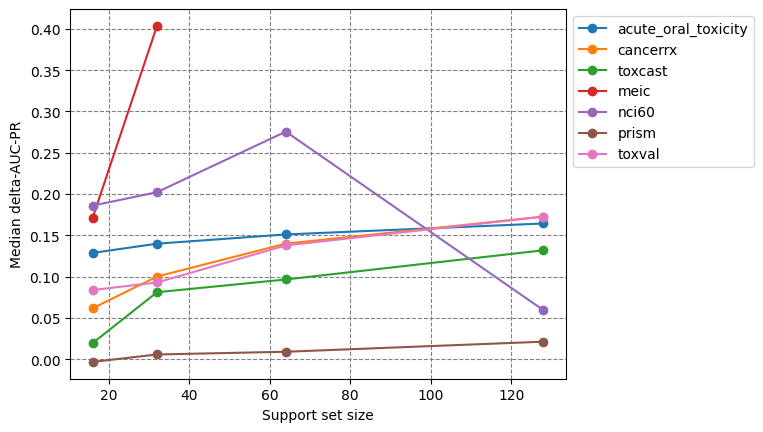

In [19]:
support_sizes = [16, 32, 64, 128]

#plt.rcParams['font.family'] = 'Times New Roman'
median_collate = []
# Get median delta-AUC-PR for each support set size
for dataset in datasets:
    median_vals = []
    for support_size in support_sizes:
        tmp = combined_df[(combined_df["support_set_size"] == support_size) & (combined_df["dataset_match"] == dataset)]
        median_vals.append(tmp["delta_auc_pr"].median())
    median_collate.append(median_vals)

    if not all(np.isnan(median_vals)):
        # Filter out any NaN values and plot
        valid_indices = ~np.isnan(median_vals)
        plt.plot(np.array(support_sizes)[valid_indices], np.array(median_vals)[valid_indices], marker="o", label=dataset)

plt.grid(True,which="both",ls="--",c='gray')
plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
# Place the legend to the right of the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

# Updating plot with additional tasks of size 128 for nci60

In [20]:
nci60_tasks = os.listdir("/rds/general/user/ssh22/home/FS-Tox/multirun/2023-08-16/15-09-01/params.dataset=nci60,params.feature=ecfp4_1024/data/processed/task")

In [21]:
nci60_tasks = [nci60_task for nci60_task in nci60_tasks if "128" in nci60_task]

In [22]:
len(nci60_tasks)

42

In [23]:
len(combined_df[(combined_df['dataset'] == 'nci60') & (combined_df['support_set_size'] == 128)])

17

In [24]:
combined_df['task_id'].duplicated().sum()

0

I can add more to the plot

In [25]:
nci60_paths = [f"/rds/general/user/ssh22/home/FS-Tox/multirun/2023-08-16/15-09-01/params.dataset=nci60,params.feature=ecfp4_1024/data/processed/task/{nci60_task}" for nci60_task in nci60_tasks]

In [37]:
dataset = 'nci60'
for task in tqdm(nci60_paths):
    # Load data
    support_selfies, support_labels, query_selfies, query_labels = load_data(task)

    # Tokenize data
    support_encodings = tokenize_data(support_selfies)
    query_encodings = tokenize_data(query_selfies)

    # Create support and query data 
    support_dataset = ChemDataset(support_encodings, support_labels)
    query_dataset = ChemDataset(query_encodings, query_labels)

    # Get the finetuned model
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
    finetuned_model.config.pad_token_id = tokenizer.pad_token_id

    # Get task_id
    task_id = os.path.splitext(os.path.basename(task))[0]

    # Set finetuned model path
    model_path = os.path.join(model_dir, dataset, task_id)

    # Finetune model
    finetune_model(support_dataset, query_dataset, finetuned_model, model_path)

    # Load baseline and finetuned models 
    finetuned_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
    finetuned_model.config.pad_token_id = tokenizer.pad_token_id

    # Generate predictions
    finetune_acc, finetune_auc = generate_predictions(finetuned_model, query_dataset)
    finetuned_accuracy.append(finetune_acc)
    finetuned_auc_pr.append(finetune_auc)
    dataset_match.append(dataset)
    task_id_match.append(task_id)

    
# Combine the lists into a dictionary
data_to_save = {
    "finetuned_accuracy": finetuned_accuracy,
    "finetuned_auc_pr": finetuned_auc_pr,
    "dataset_match": dataset_match,
    "task_id_match": task_id_match
}

# Save the dictionary to a pickle file
with open("/rds/general/user/ssh22/home/FS-Tox/nci60_performance.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

  0%|          | 0/42 [00:00<?, ?it/s]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 7.2407, 'train_samples_per_second': 53.033, 'train_steps_per_second': 6.629, 'train_loss': 0.5124642451604208, 'epoch': 3.0}


  2%|▏         | 1/42 [01:38<1:06:59, 98.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5911, 'train_samples_per_second': 106.93, 'train_steps_per_second': 13.366, 'train_loss': 0.6349910895029703, 'epoch': 3.0}


  5%|▍         | 2/42 [01:45<29:40, 44.51s/it]  /rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5981, 'train_samples_per_second': 106.723, 'train_steps_per_second': 13.34, 'train_loss': 0.560473640759786, 'epoch': 3.0}


  7%|▋         | 3/42 [01:49<17:07, 26.35s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2827, 'train_samples_per_second': 116.978, 'train_steps_per_second': 14.622, 'train_loss': 0.5543678204218546, 'epoch': 3.0}


 10%|▉         | 4/42 [03:16<31:45, 50.14s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.729, 'train_samples_per_second': 102.977, 'train_steps_per_second': 12.872, 'train_loss': 0.6848628520965576, 'epoch': 3.0}


 12%|█▏        | 5/42 [03:23<21:23, 34.70s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5839, 'train_samples_per_second': 107.145, 'train_steps_per_second': 13.393, 'train_loss': 0.6431010166803995, 'epoch': 3.0}


 14%|█▍        | 6/42 [03:30<15:07, 25.20s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2792, 'train_samples_per_second': 117.103, 'train_steps_per_second': 14.638, 'train_loss': 0.649020791053772, 'epoch': 3.0}


 17%|█▋        | 7/42 [04:21<19:32, 33.51s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.385, 'train_samples_per_second': 113.44, 'train_steps_per_second': 14.18, 'train_loss': 0.6436960299809774, 'epoch': 3.0}


 19%|█▉        | 8/42 [04:27<14:01, 24.74s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7321, 'train_samples_per_second': 102.892, 'train_steps_per_second': 12.862, 'train_loss': 0.6762930552164713, 'epoch': 3.0}


 21%|██▏       | 9/42 [04:33<10:23, 18.90s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2764, 'train_samples_per_second': 117.203, 'train_steps_per_second': 14.65, 'train_loss': 0.6261404355367025, 'epoch': 3.0}


 24%|██▍       | 10/42 [05:58<21:05, 39.54s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7675, 'train_samples_per_second': 101.924, 'train_steps_per_second': 12.74, 'train_loss': 0.6571005980173746, 'epoch': 3.0}


 26%|██▌       | 11/42 [06:07<15:33, 30.12s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7461, 'train_samples_per_second': 102.506, 'train_steps_per_second': 12.813, 'train_loss': 0.6003590822219849, 'epoch': 3.0}


 29%|██▊       | 12/42 [06:59<18:17, 36.59s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.5909, 'train_samples_per_second': 106.938, 'train_steps_per_second': 13.367, 'train_loss': 0.6724891662597656, 'epoch': 3.0}


 31%|███       | 13/42 [07:10<13:59, 28.96s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.1839, 'train_samples_per_second': 120.608, 'train_steps_per_second': 15.076, 'train_loss': 0.5914538304011027, 'epoch': 3.0}


 33%|███▎      | 14/42 [08:01<16:37, 35.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7669, 'train_samples_per_second': 101.941, 'train_steps_per_second': 12.743, 'train_loss': 0.6580883264541626, 'epoch': 3.0}


 36%|███▌      | 15/42 [08:07<11:59, 26.63s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.735, 'train_samples_per_second': 102.811, 'train_steps_per_second': 12.851, 'train_loss': 0.6223103205362955, 'epoch': 3.0}


 38%|███▊      | 16/42 [08:14<08:56, 20.64s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7258, 'train_samples_per_second': 103.066, 'train_steps_per_second': 12.883, 'train_loss': 0.6312392552693685, 'epoch': 3.0}


 40%|████      | 17/42 [08:19<06:45, 16.24s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7361, 'train_samples_per_second': 102.78, 'train_steps_per_second': 12.848, 'train_loss': 0.6232378482818604, 'epoch': 3.0}


 43%|████▎     | 18/42 [09:11<10:41, 26.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3379, 'train_samples_per_second': 115.043, 'train_steps_per_second': 14.38, 'train_loss': 0.6089359919230143, 'epoch': 3.0}


 45%|████▌     | 19/42 [10:38<17:10, 44.82s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.2172, 'train_samples_per_second': 119.359, 'train_steps_per_second': 14.92, 'train_loss': 0.6230749289194742, 'epoch': 3.0}


 48%|████▊     | 20/42 [12:05<21:06, 57.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7433, 'train_samples_per_second': 102.584, 'train_steps_per_second': 12.823, 'train_loss': 0.584640105565389, 'epoch': 3.0}


 50%|█████     | 21/42 [12:11<14:43, 42.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3979, 'train_samples_per_second': 113.012, 'train_steps_per_second': 14.126, 'train_loss': 0.549857497215271, 'epoch': 3.0}


 52%|█████▏    | 22/42 [13:02<14:56, 44.80s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6394, 'train_samples_per_second': 105.513, 'train_steps_per_second': 13.189, 'train_loss': 0.6085085868835449, 'epoch': 3.0}


 55%|█████▍    | 23/42 [13:09<10:34, 33.39s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8614, 'train_samples_per_second': 99.445, 'train_steps_per_second': 12.431, 'train_loss': 0.6520271698633829, 'epoch': 3.0}


 57%|█████▋    | 24/42 [13:16<07:37, 25.41s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8447, 'train_samples_per_second': 99.877, 'train_steps_per_second': 12.485, 'train_loss': 0.6562258005142212, 'epoch': 3.0}


 60%|█████▉    | 25/42 [13:23<05:41, 20.09s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6219, 'train_samples_per_second': 106.021, 'train_steps_per_second': 13.253, 'train_loss': 0.6873354117075602, 'epoch': 3.0}


 62%|██████▏   | 26/42 [13:35<04:39, 17.45s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6115, 'train_samples_per_second': 106.326, 'train_steps_per_second': 13.291, 'train_loss': 0.64271612962087, 'epoch': 3.0}


 64%|██████▍   | 27/42 [13:46<03:53, 15.58s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7696, 'train_samples_per_second': 101.868, 'train_steps_per_second': 12.734, 'train_loss': 0.6550207535425822, 'epoch': 3.0}


 67%|██████▋   | 28/42 [13:51<02:53, 12.38s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.74, 'train_samples_per_second': 102.675, 'train_steps_per_second': 12.834, 'train_loss': 0.6716658274332682, 'epoch': 3.0}


 69%|██████▉   | 29/42 [13:58<02:19, 10.73s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.3367, 'train_samples_per_second': 115.084, 'train_steps_per_second': 14.386, 'train_loss': 0.5973036686579386, 'epoch': 3.0}


 71%|███████▏  | 30/42 [15:25<06:43, 33.61s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7554, 'train_samples_per_second': 102.253, 'train_steps_per_second': 12.782, 'train_loss': 0.6087698936462402, 'epoch': 3.0}


 74%|███████▍  | 31/42 [15:32<04:44, 25.88s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7473, 'train_samples_per_second': 102.474, 'train_steps_per_second': 12.809, 'train_loss': 0.6180537939071655, 'epoch': 3.0}


 76%|███████▌  | 32/42 [16:18<05:17, 31.75s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7297, 'train_samples_per_second': 102.957, 'train_steps_per_second': 12.87, 'train_loss': 0.5786623160044352, 'epoch': 3.0}


 79%|███████▊  | 33/42 [16:25<03:38, 24.29s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7066, 'train_samples_per_second': 103.598, 'train_steps_per_second': 12.95, 'train_loss': 0.6946824391682943, 'epoch': 3.0}


 81%|████████  | 34/42 [16:31<02:32, 19.03s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7135, 'train_samples_per_second': 103.407, 'train_steps_per_second': 12.926, 'train_loss': 0.6151699622472128, 'epoch': 3.0}


 83%|████████▎ | 35/42 [17:17<03:08, 26.97s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8674, 'train_samples_per_second': 99.292, 'train_steps_per_second': 12.411, 'train_loss': 0.6607027053833008, 'epoch': 3.0}


 86%|████████▌ | 36/42 [17:23<02:04, 20.71s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7613, 'train_samples_per_second': 102.093, 'train_steps_per_second': 12.762, 'train_loss': 0.6181720097859701, 'epoch': 3.0}


 88%|████████▊ | 37/42 [17:30<01:22, 16.46s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.8617, 'train_samples_per_second': 99.438, 'train_steps_per_second': 12.43, 'train_loss': 0.5826497475306193, 'epoch': 3.0}


 90%|█████████ | 38/42 [17:35<00:52, 13.07s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.4819, 'train_samples_per_second': 110.283, 'train_steps_per_second': 13.785, 'train_loss': 0.5761615037918091, 'epoch': 3.0}


 93%|█████████▎| 39/42 [18:27<01:14, 24.72s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6901, 'train_samples_per_second': 104.063, 'train_steps_per_second': 13.008, 'train_loss': 0.5798778533935547, 'epoch': 3.0}


 95%|█████████▌| 40/42 [19:14<01:02, 31.36s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.7781, 'train_samples_per_second': 101.638, 'train_steps_per_second': 12.705, 'train_loss': 0.5776932239532471, 'epoch': 3.0}


 98%|█████████▊| 41/42 [19:21<00:24, 24.05s/it]/rds/general/user/ssh22/home/anaconda3/envs/fs-tox/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'train_runtime': 3.6356, 'train_samples_per_second': 105.621, 'train_steps_per_second': 13.203, 'train_loss': 0.6704436937967936, 'epoch': 3.0}


100%|██████████| 42/42 [19:27<00:00, 27.80s/it]


In [38]:
# Save the dictionary to a pickle file
with open("/rds/general/user/ssh22/home/FS-Tox/nci60_performance.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

In [58]:

# Combine the lists into a dictionary
nci60_data = {
    "finetuned_accuracy": finetuned_accuracy,
    "finetuned_auc_pr": finetuned_auc_pr,
    "dataset_match": dataset_match,
    "task_id_match": task_id_match
}

nci60_df = pd.DataFrame(nci60_data)

In [61]:
con = duckdb.connect()

nci60_ratio_df = pd.DataFrame(columns=['dataset', 'task_id', 'ratio'])

dataset = 'nci60'
for nci60_path, nci60_task in zip(nci60_paths, nci60_tasks):
    row = {}
    query = f"SELECT ground_truth FROM read_parquet('{nci60_path}')"
    res = con.execute(query).df()
    ratio = res['ground_truth'].sum() / len(res['ground_truth'])
    row['dataset'] = dataset
    row['task_id'] = nci60_task.split('.')[0]
    row['ratio'] = ratio
    nci60_ratio_df = pd.concat([nci60_ratio_df, pd.DataFrame([row])], ignore_index=True)  # Convert the row dictionary to a DataFrame and then concatenate

In [62]:
nci60_ratio_df

,dataset,task_id,ratio
0,nci60,7c3f25271fd30fa_support-128_permutation-2,0.691789
1,nci60,01db96bc277c315_support-128_permutation-3,0.635063
2,nci60,4a05df1ec22b512_support-128_permutation-3,0.672840
3,nci60,7c3f25271fd30fa_support-128_permutation-1,0.691789
4,nci60,d01419737a74a9a_support-128_permutation-1,0.592822
5,nci60,67b851a0ba34173_support-128_permutation-1,0.526627
6,nci60,9136cdcad8fe8fe_support-128_permutation-3,0.669432
7,nci60,bd403f56651408c_support-128_permutation-1,0.616756
8,nci60,bd403f56651408c_support-128_permutation-3,0.616756
9,nci60,2862267c4c0653d_support-128_permutation-3,0.672317


In [64]:
combined_nci60 = nci60_df.merge(nci60_ratio_df, left_on=['dataset_match', 'task_id_match'], right_on=['dataset', 'task_id'])

In [67]:
combined = pd.concat([combined_df, combined_nci60])

In [69]:
combined['delta_auc_pr'] = combined['finetuned_auc_pr'] - combined['ratio']

In [77]:
combined['support_set_size'] = combined['support_set_size'].fillna(128)

In [79]:
combined

,finetuned_accuracy,finetuned_auc_pr,dataset_match,task_id_match,support_set_size,dataset,task_id,ratio,delta_auc_pr
0,0.561677,0.604197,acute_oral_toxicity,18f5384d58bcb1b_support-16_permutation-3,16.0,acute_oral_toxicity,18f5384d58bcb1b_support-16_permutation-3,0.500068,0.104129
1,0.560169,0.652662,acute_oral_toxicity,18f5384d58bcb1b_support-64_permutation-3,64.0,acute_oral_toxicity,18f5384d58bcb1b_support-64_permutation-3,0.500068,0.152595
2,0.628221,0.664422,acute_oral_toxicity,18f5384d58bcb1b_support-128_permutation-2,128.0,acute_oral_toxicity,18f5384d58bcb1b_support-128_permutation-2,0.500068,0.164355
3,0.595547,0.651165,acute_oral_toxicity,18f5384d58bcb1b_support-64_permutation-1,64.0,acute_oral_toxicity,18f5384d58bcb1b_support-64_permutation-1,0.500068,0.151097
4,0.578539,0.628458,acute_oral_toxicity,18f5384d58bcb1b_support-32_permutation-3,32.0,acute_oral_toxicity,18f5384d58bcb1b_support-32_permutation-3,0.500068,0.128390
...,...,...,...,...,...,...,...,...,...
37,0.705882,0.915674,nci60,4a05df1ec22b512_support-128_permutation-1,128.0,nci60,4a05df1ec22b512_support-128_permutation-1,0.672840,0.242834
38,0.698316,0.757920,nci60,d7c9562a98f62c7_support-128_permutation-3,128.0,nci60,d7c9562a98f62c7_support-128_permutation-3,0.698551,0.059369
39,0.697087,0.711242,nci60,8491cca19882d2b_support-128_permutation-1,128.0,nci60,8491cca19882d2b_support-128_permutation-1,0.697365,0.013877
40,0.687500,0.737976,nci60,41ea2a4151619ca_support-128_permutation-1,128.0,nci60,41ea2a4151619ca_support-128_permutation-1,0.674632,0.063343


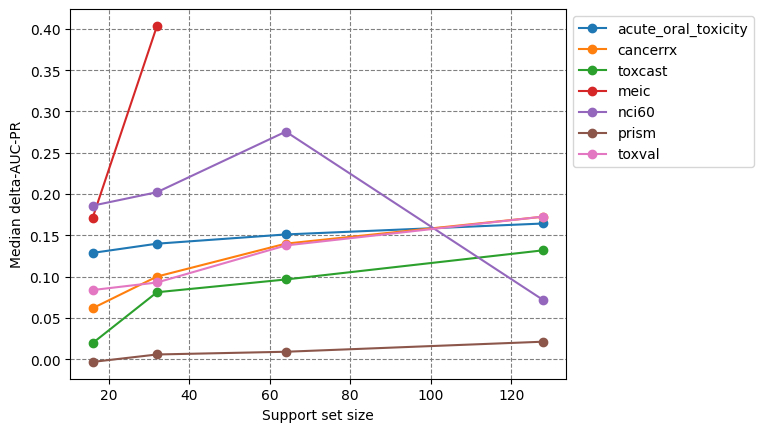

In [80]:
support_sizes = [16, 32, 64, 128]

#plt.rcParams['font.family'] = 'Times New Roman'
median_collate = []
# Get median delta-AUC-PR for each support set size
for dataset in datasets:
    median_vals = []
    for support_size in support_sizes:
        tmp = combined[(combined["support_set_size"] == support_size) & (combined["dataset_match"] == dataset)]
        median_vals.append(tmp["delta_auc_pr"].median())
    median_collate.append(median_vals)

    if not all(np.isnan(median_vals)):
        # Filter out any NaN values and plot
        valid_indices = ~np.isnan(median_vals)
        plt.plot(np.array(support_sizes)[valid_indices], np.array(median_vals)[valid_indices], marker="o", label=dataset)

plt.grid(True,which="both",ls="--",c='gray')
plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
# Place the legend to the right of the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

In [83]:
combined[(combined['dataset_match'] == "nci60") & (combined['support_set_size'] == 128)]['ratio'].median()

0.6522471376706207

In [84]:
combined[(combined['dataset_match'] == "nci60") & (combined['support_set_size'] == 64)]['ratio'].median()

0.5764705882352941